# import library

In [10]:
from functools import partial

import numpy as np
import pandas as pd
import os
import random
import time
import tensorflow as tf, re, math
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model, Sequential
from tensorflow.keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import gc
import uproot

### Checking for TPUs

In [11]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()
    
!nvidia-smi

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
/usr/bin/sh: nvidia-smi: command not found


### Loading the data

In [12]:
def get_features():
    return ['FatJet_pt', 'FatJet_eta', 'FatJet_phi', 'FatJet_DDX_jetNSecondaryVertices', 'FatJet_DDX_jetNTracks', 'FatJet_DDX_z_ratio', 'FatJet_Proba', 'FatJet_area', 'FatJet_jetId', 'FatJet_lsf3', 'FatJet_mass', 'FatJet_msoftdrop', 'FatJet_rawFactor', 'FatJet_n2b1', 'FatJet_n3b1', 'FatJet_tau1', 'FatJet_DDX_tau1_flightDistance2dSig', 'FatJet_DDX_tau1_trackEtaRel_0', 'FatJet_DDX_tau1_trackEtaRel_1', 'FatJet_DDX_tau1_trackEtaRel_2', 'FatJet_DDX_tau1_trackSip3dSig_0', 'FatJet_DDX_tau1_trackSip3dSig_1', 'FatJet_DDX_tau1_vertexDeltaR', 'FatJet_DDX_tau1_vertexEnergyRatio', 'FatJet_DDX_tau1_vertexMass', 'FatJet_tau2', 'FatJet_DDX_tau2_flightDistance2dSig', 'FatJet_DDX_tau2_trackEtaRel_0', 'FatJet_DDX_tau2_trackEtaRel_1', 'FatJet_DDX_tau2_trackEtaRel_3', 'FatJet_DDX_tau2_trackSip3dSig_0', 'FatJet_DDX_tau2_trackSip3dSig_1', 'FatJet_DDX_tau2_vertexEnergyRatio', 'FatJet_DDX_tau2_vertexMass', 'FatJet_tau3', 'FatJet_tau4', 'FatJet_DDX_trackSip2dSigAboveBottom_0', 'FatJet_DDX_trackSip2dSigAboveBottom_1', 'FatJet_DDX_trackSip2dSigAboveCharm', 'FatJet_DDX_trackSip3dSig_0', 'FatJet_DDX_trackSip3dSig_1', 'FatJet_DDX_trackSip3dSig_2', 'FatJet_DDX_trackSip3dSig_3', 'FatJet_subjet1_pt', 'FatJet_subjet1_eta', 'FatJet_subjet1_phi', 'FatJet_subjet1_Proba', 'FatJet_subjet1_mass', 'FatJet_subjet1_tau1', 'FatJet_subjet1_tau2', 'FatJet_subjet1_tau3', 'FatJet_subjet1_tau4', 'FatJet_subjet1_n2b1', 'FatJet_subjet1_n3b1', 'FatJet_subjet2_pt', 'FatJet_subjet2_eta', 'FatJet_subjet2_phi', 'FatJet_subjet2_Proba', 'FatJet_subjet2_mass', 'FatJet_subjet2_tau1', 'FatJet_subjet2_tau2', 'FatJet_subjet2_tau3', 'FatJet_subjet2_tau4', 'FatJet_subjet2_n2b1', 'FatJet_subjet2_n3b1', 'FatJet_hadronFlavour', 'FatJet_sv_costhetasvpv', 'FatJet_sv_d3dsig', 'FatJet_sv_deltaR', 'FatJet_sv_dxysig', 'FatJet_sv_enration', 'FatJet_sv_mass', 'FatJet_sv_normchi2', 'FatJet_sv_ntracks', 'FatJet_sv_phirel', 'FatJet_sv_pt', 'FatJet_sv_ptrel', 'FatJet_nFatJetPFCands', 'FatJet_pfcand_max_deltar', 'FatJet_pfcand_mean_deltar', 'FatJet_gen_pt', 'FatJet_gen_eta', 'FatJet_gen_phi', 'FatJet_gen_hadronFlavour']

In [13]:
def get_df(root_file_name, filter_name):
    events = uproot.open(root_file_name, filter_name=filter_name)["tree"]
    df = events.arrays(library="pd")
    return df

features = []
# variables: general
features += ['FatJet_pt', 'FatJet_eta', 'FatJet_phi', 'FatJet_DDX_jetNSecondaryVertices', \
             'FatJet_DDX_jetNTracks', 'FatJet_DDX_z_ratio', 'FatJet_Proba', 'FatJet_area', \
             'FatJet_jetId', 'FatJet_lsf3', 'FatJet_rawFactor', 'FatJet_n2b1', 'FatJet_n3b1', \
            ]

# variables: tau1
features += ['FatJet_tau1', 'FatJet_DDX_tau1_flightDistance2dSig', 'FatJet_DDX_tau1_trackEtaRel_0', \
             'FatJet_DDX_tau1_trackEtaRel_1', 'FatJet_DDX_tau1_trackEtaRel_2', 'FatJet_DDX_tau1_trackSip3dSig_0', \
             'FatJet_DDX_tau1_trackSip3dSig_1', 'FatJet_DDX_tau1_vertexDeltaR', 'FatJet_DDX_tau1_vertexEnergyRatio', \
            ]

# variables: tau2
features += ['FatJet_tau2', 'FatJet_DDX_tau2_flightDistance2dSig', 'FatJet_DDX_tau2_trackEtaRel_0', \
             'FatJet_DDX_tau2_trackEtaRel_1', 'FatJet_DDX_tau2_trackEtaRel_3', 'FatJet_DDX_tau2_trackSip3dSig_0', \
             'FatJet_DDX_tau2_trackSip3dSig_1', 'FatJet_DDX_tau2_vertexEnergyRatio', \
            ]

# variables: tau3 and tau4
features += ['FatJet_tau3', 'FatJet_tau4',]

# variables: track
features += ['FatJet_DDX_trackSip2dSigAboveBottom_0', 'FatJet_DDX_trackSip2dSigAboveBottom_1', \
             'FatJet_DDX_trackSip2dSigAboveCharm', 'FatJet_DDX_trackSip3dSig_0', \
             'FatJet_DDX_trackSip3dSig_1', 'FatJet_DDX_trackSip3dSig_2', 'FatJet_DDX_trackSip3dSig_3', \
            ]

# variables: subjet 1
features += ['FatJet_subjet1_pt', 'FatJet_subjet1_eta', 'FatJet_subjet1_phi', \
             'FatJet_subjet1_Proba', 'FatJet_subjet1_tau1', 'FatJet_subjet1_tau2', \
             'FatJet_subjet1_tau3', 'FatJet_subjet1_tau4', 'FatJet_subjet1_n2b1', 'FatJet_subjet1_n3b1', \
            ]

# variables: subjet 2
features += ['FatJet_subjet2_pt', 'FatJet_subjet2_eta', 'FatJet_subjet2_phi', \
             'FatJet_subjet2_Proba', 'FatJet_subjet2_tau1', 'FatJet_subjet2_tau2', \
             'FatJet_subjet2_tau3', 'FatJet_subjet2_tau4', 'FatJet_subjet2_n2b1', 'FatJet_subjet2_n3b1', \
            ]

# variables: fatjet sv
features += ['FatJet_sv_costhetasvpv', 'FatJet_sv_d3dsig', 'FatJet_sv_deltaR', 'FatJet_sv_dxysig', \
             'FatJet_sv_enration', 'FatJet_sv_normchi2', 'FatJet_sv_ntracks', 'FatJet_sv_phirel', \
             'FatJet_sv_pt', 'FatJet_sv_ptrel', \
            ]

features = sorted(features)

root_dir = "/eos/user/a/afriberg/datasets/QCD_samples/"

dirs = os.listdir(root_dir)

first_file = dirs.pop(0)
while ".root" not in first_file:
    first_file = dirs.pop(0)

first_file = root_dir + first_file
df = get_df(first_file, '*')
# Select a particular type of particle 0 means QCD
df.query("FatJet_gen_hadronFlavour == 0", inplace=True)
df.dropna(inplace=True)
df = df[features]
# Prior to this, df is a pandas dataframe
X = df.to_numpy().astype(np.float32)
print(np.shape(X))


for inputfile in dirs:
    if ".root" not in inputfile:
        continue
    inputfile = root_dir + inputfile
    df = get_df(inputfile, '*')
    df.dropna(inplace=True)
    df = df[features]
    # Prior to this, df is a pandas dataframe
    next_data = df.to_numpy().astype(np.float32)
    print(f"next data has shape {np.shape(next_data)}")
    # appending it to the whole thing
    X = np.append(X, next_data, axis=0)

print(f"X has shape {np.shape(X)}")

(376907, 69)
next data has shape (353590, 69)
next data has shape (340485, 69)
next data has shape (74979, 69)
next data has shape (361458, 69)
next data has shape (399367, 69)
X has shape (1906786, 69)


# Run this when you want to add HToBB Data to the tests

In [14]:
new_path = "/eos/user/a/afriberg/datasets/has_B/ZH_HToBB_ZToLL_M125_13TeV_powheg_pythia8.root"
df = get_df(new_path, '*')
# Select a particular type of particle 4 means Charm 5 means B quark?
df.query("FatJet_gen_hadronFlavour == 5", inplace=True)

df.dropna(inplace=True)
df = df[features]

new_X = df.to_numpy()
new_X = new_X.astype("float32")

This scales the HToBB data and the QCD data together, and then splits them in two parts afterwards

In [15]:
num_new = np.size(new_X, axis=0)
X = np.append(X, new_X, axis=0)
print(f"new_X has shape {np.shape(new_X)}\nX has shape {np.shape(X)}")
# print(np.allclose(X[-num_new:, :], new_X))

# Scale our data using a MinMaxScaler that will scale
# each number so that it will be between 0 and 1
scaler = MinMaxScaler()
data = scaler.fit_transform(X)
new_X = data[-num_new:, :]
X = data[:-num_new, :]

print(f"X now has shape {np.shape(X)}\n new_X now has shape {np.shape(new_X)}")

new_X has shape (23350, 69)
X has shape (1930136, 69)
X now has shape (1906786, 69)
 new_X now has shape (23350, 69)


## Run this regardless of presence or lack of HToBB data

In [16]:
x_train, x_test = train_test_split(data, test_size=0.20)
original_dim = np.size(data, axis=1)
print(original_dim)

69


In [17]:
batch_size = 32

def build_dset(df): 
    df = df.copy()
    dataset = tf.data.Dataset.from_tensor_slices((df, df))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset
    
x_train_dataset = build_dset(x_train)
x_test_dataset = build_dset(x_test)

### loss function

In [24]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the encoding vector."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### build model

In [38]:
def get_encoder(original_dim, latent_dim):
    # Encoder
    encoder_inputs = layers.Input(shape=(original_dim,))
    h = layers.Dense(32, activation='relu')(encoder_inputs)
    h = layers.Dense(16, activation='relu')(h)
    h = layers.Dense(8, activation='relu')(h)
    h = layers.Dense(latent_dim, activation='sigmoid')(h)
    z_mu = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)
    z = Sampling()([z_mu, z_log_var])
    
    encoder = Model(encoder_inputs, [z_mu, z_log_var, z], name="encoder")
    return encoder
    
def get_decoder(original_dim, latent_dim):
    decoder_inputs = layers.Input(shape=(latent_dim,))
    d = layers.Dense(8, activation='relu')(decoder_inputs)
    d = layers.Dense(16, activation='relu')(d)
    d = layers.Dense(32, activation='relu')(d)
    d = layers.Dense(original_dim, activation='relu')(d)
    
    decoder = Model(decoder_inputs, d, name="decoder")
    return decoder

def get_sigmoid_decoder(original_dim, latent_dim):
    decoder_inputs = layers.Input(shape=(latent_dim,))
    d = layers.Dense(8, activation='relu')(decoder_inputs)
    d = layers.Dense(16, activation='relu')(d)
    d = layers.Dense(32, activation='relu')(d)
    d = layers.Dense(original_dim, activation='sigmoid')(d)
    
    decoder = Model(decoder_inputs, d, name="decoder")
    return decoder

class vae(Model):
    def __init__(self, encoder, decoder, verbose=True, **kwargs):
        super(vae, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        if verbose:
            self.encoder.summary()
            self.decoder.summary()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=-1
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.encoder.trainable_weights + self.decoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights + self.decoder.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        y_pred = self.decoder(z)
        return y_pred 

### get model

In [37]:
latent_dim = 2

with strategy.scope():
    encoder = get_encoder(original_dim, latent_dim)
    decoder = get_decoder(original_dim, latent_dim)
    model = vae(encoder, decoder)
    model.compile(optimizer=tf.keras.optimizers.Adam(1.e-3))
    #model.compile(optimizer=tf.keras.optimizers.RMSprop())


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 69)]         0                                            
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 32)           2240        input_12[0][0]                   
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 16)           528         dense_44[0][0]                   
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 8)            136         dense_45[0][0]                   
____________________________________________________________________________________________

In [39]:
model_output_config = model.decoder.layers[-1].get_config()

relu_decoder = get_sigmoid_decoder(original_dim, latent_dim)
relu_output_config = relu_decoder.layers[-1].get_config()

print(model_output_config == relu_output_config)

print(model_output_config)
print(model.decoder.layers[-1].output_shape)

print(relu_output_config)
print(relu_decoder.layers[-1].output_shape)

False
{'name': 'dense_51', 'trainable': True, 'dtype': 'float32', 'units': 69, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
(None, 69)
{'name': 'dense_55', 'trainable': True, 'dtype': 'float32', 'units': 69, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
(None, 69)


### train model

In [23]:
def get_lr_callback():
    lr_start   = 0.000001
    lr_max     = 0.01
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 10
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    return lr_callback

checkpoint_path = "checkpoints/tsg_vae weights.{epoch:05d}.hdf5"
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor = 'val_loss',
                                                 save_weights_only=True,
                                                 save_best_only=False,
                                                 mode = 'min',
                                                 verbose=1)

num_epochs = 20

history = model.fit(
    x_train_dataset,
    shuffle=True,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[cp_callback]
    #callbacks=[cp_callback, get_lr_callback()]
)

Epoch 1/20
INFO:tensorflow:Error reported to Coordinator: logits and labels must have the same shape ((32, 69) vs (2, 32, 69))
Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py", line 947, in merge_with
    self.assert_same_rank(other)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py", line 1001, in assert_same_rank
    raise ValueError("Shapes %s and %s must have the same rank" %
ValueError: Shapes (2, 32, 69) and (32, 69) must have the same rank

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/ops/nn_impl.py", line 171, in sigmoid_cross_entropy_with_logits
    labels.get_shape().merge_with(logits.get_s

ValueError: in user code:

    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/distribute/mirrored_strategy.py:584 _call_for_each_replica
        return mirrored_run.call_for_each_replica(
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/distribute/mirrored_run.py:96 call_for_each_replica
        return _call_for_each_replica(strategy, fn, args, kwargs)
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/distribute/mirrored_run.py:237 _call_for_each_replica
        coord.join(threads)
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/training/coordinator.py:389 join
        six.reraise(*self._exc_info_to_raise)
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/six.py:693 reraise
        raise value
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/training/coordinator.py:297 stop_on_exception
        yield
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/distribute/mirrored_run.py:323 run
        self.main_result = self.main_fn(*self.main_args, **self.main_kwargs)
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    <ipython-input-21-7ab2f7fde238>:53 train_step
        tf.keras.losses.binary_crossentropy(data, reconstruction), axis=-1
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1605 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4823 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/tensorflow/python/ops/nn_impl.py:173 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((32, 69) vs (2, 32, 69))


In [ ]:
model.evaluate(x_test)
predictions = model.predict(x_test)


In [ ]:
print(history.history.keys())
plt.plot(history.history["loss"])
# plt.plot(history.history["kl_loss"])
# plt.plot(history.history["reconstruction_loss"])
# plt.yscale('log')
plt.show()

# Loading a model from a checkpoint

In [40]:
latent_dim = 2
encoder = get_encoder(original_dim, latent_dim)
decoder = get_decoder(original_dim, latent_dim)
model = vae(encoder, decoder)
model.compile(optimizer=tf.keras.optimizers.Adam(1.e-3))
model.evaluate(x_test)
model.load_weights("working_QCD_checkpoints/tsg_vae weights.00020.hdf5")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 69)]         0                                            
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 32)           2240        input_15[0][0]                   
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 16)           528         dense_56[0][0]                   
__________________________________________________________________________________________________
dense_58 (Dense)                (None, 8)            136         dense_57[0][0]                   
____________________________________________________________________________________________

# Plotting the test data errors

(386028,)


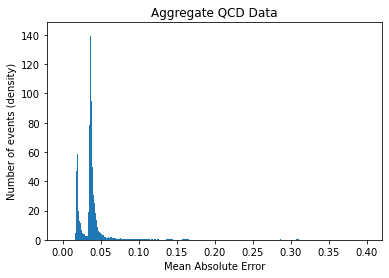

In [42]:
predict = model.predict(x_test)
err = np.mean(np.abs(predict - x_test), axis=1)
print(np.shape(err))

bins = np.linspace(0, 0.4, 1000)
# plt.hist(err, density=True)
plt.hist(err, density=True, bins=bins)
plt.xlabel("Mean Absolute Error")
plt.ylabel("Number of events (density)")
# Getting the name of the file we ran on
plt.title("Aggregate QCD Data")
plt.show()


### Plotting it with two peaks

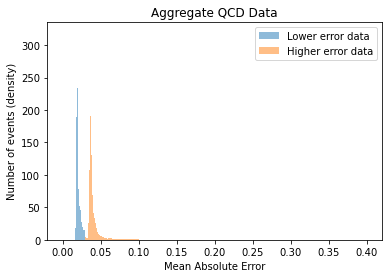

In [45]:
# There are two humps, so we're plotting those separately to visualize well
demarcation = 0.03
first_peaks = []
second_peaks = []
for idx, val in enumerate(err):
    if val < demarcation:
        first_peaks.append(idx)
    elif demarcation <= val < 0.1:
        second_peaks.append(idx)

low_err = err[first_peaks]
high_err = err[second_peaks]

low_err_test = x_test[first_peaks]
high_err_test = x_test[second_peaks]

# There are two humps, so we're plotting those separately to visualize well
plt.hist(low_err, density=True, bins=bins, alpha=0.5, label="Lower error data")
plt.hist(high_err, density=True, bins=bins, alpha=0.5, label="Higher error data")
plt.xlabel("Mean Absolute Error")
plt.ylabel("Number of events (density)")
# Getting the name of the file we ran on
plt.title("Aggregate QCD Data")
plt.legend()
plt.show()

### Plotting pt, eta, and phi in case something looks immediately wrong

In [ ]:
pt_idx = features.index('FatJet_pt')
eta_idx = features.index('FatJet_eta')
phi_idx = features.index('FatJet_phi')

print(features[pt_idx])
print(features[eta_idx])
print(features[phi_idx])

# Getting the data to plot eta, phi, and pt for both high and low error data
high_err_pt = high_err_test[:, pt_idx]
low_err_pt = low_err_test[:, pt_idx]

high_err_eta = high_err_test[:, eta_idx]
low_err_eta = low_err_test[:, eta_idx]

high_err_phi = high_err_test[:, phi_idx]
low_err_phi = low_err_test[:, phi_idx]

In [ ]:
bins = np.linspace(0, 0.6, 1000)
plt.hist(high_err_pt, density=True, bins=bins, alpha=0.5, label="Lower error data")
plt.hist(low_err_pt, density=True, bins=bins, alpha=0.5, label="Higher error data")
plt.xlabel("Transverse Momentum")
plt.ylabel("Number of events (density)")
# Getting the name of the file we ran on
plt.title("Aggregate QCD Data")
plt.legend()
plt.show()

bins = np.linspace(0.9, 1, 1000)
plt.hist(high_err_eta, density=True, bins=bins, alpha=0.5, label="Lower error data")
plt.hist(low_err_eta, density=True, bins=bins, alpha=0.5, label="Higher error data")
plt.xlabel("Eta")
plt.ylabel("Number of events (density)")
# Getting the name of the file we ran on
plt.title("Aggregate QCD Data")
plt.legend()
plt.show()

# bins = np.linspace(0, 1, 1000)
plt.hist(high_err_phi, density=True, bins=bins, alpha=0.5, label="Lower error data")
plt.hist(low_err_phi, density=True, bins=bins, alpha=0.5, label="Higher error data")
plt.xlabel("Phi")
plt.ylabel("Number of events (density)")
# Getting the name of the file we ran on
plt.title("Aggregate QCD Data")
plt.legend()
plt.show()

## Plotting Latent Space Distributions

In [ ]:
trained_encoder = model.encoder
z_mean_high, z_log_var_high, z_high = trained_encoder.predict(high_err_test)
z_mean_low, z_log_var_low, z_low = trained_encoder.predict(low_err_test)

In [ ]:
print(np.shape(z_high))
num_high = np.size(z_high, axis=0) // 10
num_low = np.size(z_low, axis=0) // 10
print(num_high)
plt.scatter(z_high[:num_high, 0], z_high[:num_high, 1], s=1, alpha=0.5, label="high error data")
plt.scatter(z_low[:num_low, 0], z_low[:num_low, 1], s=1, alpha=0.5, label="low error data")
plt.title("latent space representation")
plt.xlabel("z_0")
plt.ylabel("z_1")
plt.legend()
plt.show()

In [ ]:
bins = np.linspace(-4, 4, 500)
plt.hist(z_high[:, 0], density=True, bins=bins, alpha=0.4, label="high error data")
plt.hist(z_low[:, 0], density=True, bins=bins, alpha=0.4, label="low error data")
plt.legend()
plt.xlabel("z_0")
plt.ylabel("density")
plt.show()

plt.hist(z_high[:, 1], density=True, bins=bins, alpha=0.4, label="high error data")
plt.hist(z_low[:, 1], density=True, bins=bins, alpha=0.4, label="low error data")
plt.legend()
plt.xlabel("z_1")
plt.ylabel("density")
plt.show()

### Plotting more features

0.99388015
0.9926007
0.993011
0.9936746
0.9936746
0.99506354
0.99261177
0.9938398
0.9928523
0.99275434
0.99262494
0.99267083
0.99304163
0.9931031
0.992777
0.9941237
0.99310064
0.9925953
0.992773
0.99291956
0.9934488
0.9946205
0.9935063
0.99281216
0.9940038
0.9945728
0.99313617
0.99442106
0.9925385
0.9941702
0.9949387
0.9940454
0.9933478
0.9925953
0.99279964
0.99260193
0.99667394
0.99288225
0.9928473
0.99320346
0.99433786
0.99274117
0.9938912
0.99281216
0.99334663
0.99275434
0.99267083
0.9940038
0.9924729
0.99257153
0.993956
0.99298716
0.99388015
0.992777
0.9936538
0.99334663
0.99250996
0.99342006
0.9931019
0.99464625
0.99305016
0.9938912
0.9934188
0.9960621
0.9926525
0.9926007
0.9925655
0.993406
0.99295443
0.99289536
0.99295443
0.99257153
0.9928685
0.99286145
0.9925471
0.9934176
0.9928605
0.99289536
0.9926254
0.992632
0.9940209
0.9940209
0.9936746
0.992896
0.99261177
0.9949387
0.9940209
0.9928473
0.9925953
0.9933038
0.9926347
0.99270904
0.99304163
0.992632
0.99249643
0.9928467
0.994395

0.99322426
0.99305016
0.99360543
0.9946279
0.9928467
0.99388015
0.99261177
0.99410045
0.993011
0.9933393
0.9930428
0.99276966
0.9928467
0.9925953
0.99250996
0.994995
0.9926465
0.99316674
0.9938912
0.99298716
0.99249893
0.99380183
0.99253154
0.99249893
0.99277884
0.99253154
0.99288225
0.993406
0.9925385
0.9928605
0.992777
0.99509776
0.9926525
0.9927441
0.9926007
0.9924921
0.99295443
0.9949387
0.9925607
0.99276966
0.9927837
0.9960621
0.99301255
0.9941702
0.9925324
0.9925471
0.99380183
0.9951125
0.9939487
0.9945789
0.9949387
0.9925385
0.99260795
0.99313617
0.99253154
0.9935063
0.99288225
0.99320346
0.9925471
0.99310064
0.9928685
0.99281216
0.993253
0.99276507
0.9939487
0.9927602
0.99275434
0.994995
0.99275434
0.9927837
0.9955041
0.99329156
0.9935908
0.99277884
0.9960621
0.99276507
0.99249095
0.99279964
0.9938912
0.99310863
0.9926007
0.99304163
0.99288225
0.99255085
0.9925655
0.99289536
0.99313617
0.99380183
0.99284
0.994995
0.9928523
0.99349105
0.9928605
0.9926254
0.99384713
0.99267375
0.

0.9932175
0.9925657
0.9925655
0.9960621
0.9943954
0.9960621
0.9927441
0.9927929
0.9926254
0.99442106
0.99327135
0.99342006
0.992784
0.99299264
0.99320346
0.99298257
0.99410045
0.9926774
0.99281216
0.9924978
0.99334663
0.9936972
0.9925607
0.99274117
0.9948738
0.99295443
0.9933393
0.9933736
0.9925607
0.993406
0.99276656
0.9927397
0.992896
0.9926985
0.9925655
0.99406743
0.99335825
0.9925682
0.9924921
0.9928605
0.99403435
0.9928467
0.9927807
0.99261177
0.99285287
0.99329215
0.99316674
0.99275434
0.99295807
0.9945789
0.9925682
0.99253666
0.9925607
0.9930722
0.99295443
0.99327135
0.99667394
0.99388015
0.99289536
0.99253154
0.9928605
0.9941359
0.9951198
0.99281216
0.9925953
0.994995
0.9924978
0.9945789
0.9937321
0.9931019
0.9926254
0.99304163
0.99360543
0.99317837
0.992547
0.9933913
0.9925655
0.9931031
0.9940209
0.99253154
0.9939536
0.9949583
0.99274117
0.9928302
0.99320346
0.9948567
0.99506354
0.9929529
0.9934653
0.99334663
0.9931031
0.9927637
0.99249744
0.9925655
0.9933393
0.993406
0.992497

0.99249524
0.9925607
0.9926774
0.99320346
0.99310064
0.994995
0.994995
0.9945789
0.9960621
0.9927387
0.9926684
0.99285287
0.99509776
0.99286145
0.99276507
0.99295443
0.9926254
0.99334663
0.9925471
0.99412245
0.9926436
0.9941237
0.9927807
0.993406
0.99360543
0.9928523
0.9934188
0.99296665
0.9948738
0.9931031
0.9949387
0.9927271
0.99276507
0.99277884
0.9955041
0.9926254
0.9940038
0.99250996
0.99249744
0.99506354
0.9926254
0.9926191
0.99486285
0.99402213
0.99273384
0.9929529
0.993011
0.99277884
0.9932151
0.99253666
0.9929514
0.9940576
0.9928467
0.99276507
0.992547
0.9929529
0.9925471
0.99384713
0.9941996
0.992896
0.99260116
0.9925607
0.994995
0.9938459
0.99256635
0.992727
0.9933393
0.9940209
0.99306
0.9960621
0.99276656
0.99266714
0.9933478
0.99298716
0.9926436
0.9940038
0.99320346
0.9927602
0.99298257
0.9925607
0.99249524
0.99274117
0.9931019
0.9939536
0.9936746
0.9929514
0.9938912
0.993406
0.99384713
0.9931019
0.9946279
0.9927837
0.9960621
0.99325424
0.9932151
0.99304163
0.99277884
0.99

0.992784
0.992784
0.992652
0.9938459
0.9928473
0.9938912
0.99284
0.99759173
0.9925953
0.9925682
0.9940038
0.993406
0.9933038
0.9934849
0.9938912
0.9975477
0.993253
0.99256635
0.99250996
0.99288225
0.9940209
0.9927837
0.99262494
0.992784
0.9925471
0.9936654
0.9945789
0.99249524
0.992727
0.9952373
0.9925655
0.9925682
0.9955041
0.992652
0.9939487
0.9955041
0.99285287
0.9932175
0.9927602
0.9925953
0.9940576
0.99490446
0.9929529
0.9925272
0.9925324
0.99249524
0.99281216
0.99249643
0.99274117
0.9936746
0.9928473
0.99360543
0.9926649
0.9949583
0.99274117
0.99273384
0.992896
0.9925471
0.9925685
0.9948738
0.99316674
0.9926525
0.9926465
0.9926007
0.99270904
0.99261177
0.9926436
0.9929529
0.99285287
0.9926436
0.9929777
0.9965638
0.9925682
0.9938912
0.99464625
0.9927637
0.9948738
0.994377
0.9925655
0.9926525
0.99316674
0.9934488
0.9934653
0.9927314
0.9938716
0.9965638
0.9931031
0.99403435
0.9933038
0.9925682
0.99334663
0.9925655
0.9928467
0.9926852
0.9943954
0.99316674
0.99281216
0.9943954
0.99333

0.99260116
0.9929761
0.99334663
0.99320346
0.99306
0.99342006
0.9928685
0.99327135
0.99261177
0.9940038
0.99288225
0.993406
0.9941702
0.9926525
0.9945789
0.99320346
0.9932175
0.99249524
0.9924729
0.9927441
0.9941702
0.9927837
0.992547
0.99249744
0.99442106
0.9929807
0.9926191
0.9941237
0.993011
0.99301714
0.9929529
0.99285287
0.99317837
0.99334663
0.992896
0.99295443
0.9927602
0.9933393
0.9929807
0.993011
0.99329215
0.99276507
0.9928685
0.9932151
0.99250996
0.9949387
0.99285287
0.9925971
0.9927837
0.9928467
0.99298257
0.9926774
0.992652
0.99304163
0.9948738
0.99327135
0.9926774
0.99252796
0.99380183
0.9926525
0.99258614
0.99260795
0.994377
0.9934849
0.99329215
0.9941359
0.9940038
0.9927602
0.99298257
0.99295443
0.9926525
0.99313617
0.992547
0.99295807
0.99403435
0.9943954
0.9936746
0.99275434
0.9932218
0.992896
0.9955041
0.99285287
0.9925655
0.9925607
0.99298716
0.993011
0.9928685
0.9936538
0.9935063
0.99509776
0.99276507
0.993011
0.99298257
0.99384713
0.99277884
0.99334663
0.9926301
0

0.9929529
0.993011
0.9928467
0.99334663
0.99273384
0.99410045
0.9928685
0.99958396
0.99509776
0.99277884
0.99249524
0.9933393
0.9932579
0.9934176
0.99253666
0.992896
0.992632
0.99360543
0.9927602
0.99402213
0.99284
0.992773
0.99281615
0.99277884
0.99260116
0.9926646
0.99281216
0.99316674
0.99320346
0.99291956
0.9931019
0.9927271
0.99403435
0.9949387
0.9955041
0.9933864
0.99267083
0.99281216
0.9926646
0.993011
0.99285287
0.992547
0.99275434
0.9936746
0.99261177
0.99667394
0.9931533
0.99267083
0.99253154
0.9965638
0.9927397
0.99327135
0.9928467
0.99257547
0.9933478
0.9936746
0.99349105
0.99313617
0.993253
0.99317837
0.99295443
0.9938912
0.9926774
0.99276507
0.9965638
0.9927441
0.9949583
0.9927397
0.9926007
0.99295443
0.9931814
0.99280024
0.9935186
0.9940576
0.9925369
0.9946279
0.99313617
0.9926959
0.99276656
0.992652
0.99509776
0.9924978
0.99270296
0.99355465
0.9930878
0.9940576
0.99286145
0.9938276
0.9940931
0.9940038
0.9932861
0.9925385
0.99334663
0.9926525
0.99260795
0.99298257
0.9928

0.9938276
0.992896
0.99286604
0.99464625
0.9940038
0.9941237
0.9927271
0.99260795
0.993011
0.9935908
0.9945789
0.9925685
0.9926436
0.99442106
0.9951198
0.99260193
0.992652
0.9927314
0.9925471
0.9925471
0.9927441
0.9929529
0.9931031
0.99267375
0.9935063
0.99359685
0.9933038
0.9938276
0.99327135
0.9949387
0.994995
0.9931031
0.992652
0.9927837
0.9929761
0.99320346
0.9928523
0.9926254
0.99442106
0.9925243
0.99281216
0.99414694
0.9931019
0.99288225
0.9926852
0.9928605
0.9949387
0.9934653
0.9926525
0.99279964
0.9927271
0.99305016
0.9929529
0.9926774
0.993011
0.99402213
0.993956
0.9943954
0.99320346
0.9940038
0.99320346
0.99316674
0.99298257
0.9940576
0.99304163
0.9937309
0.9932151
0.9926254
0.9926254
0.9949387
0.992896
0.99306
0.9955041
0.99298257
0.9936538
0.9949387
0.99298716
0.9925682
0.99289536
0.9946205
0.9925971
0.9927602
0.99593973
0.992773
0.9928685
0.9927602
0.9935063
0.99288225
0.9925682
0.99258196
0.9928605
0.99464625
0.9934188
0.9925369
0.9945789
0.99295443
0.99275434
0.9926774
0

0.9926254
0.9975477
0.99334663
0.99276656
0.99276966
0.9940576
0.99316674
0.99281615
0.9925243
0.99281216
0.9928473
0.99295443
0.9924978
0.9935063
0.99249095
0.99286604
0.9929807
0.9930428
0.9929529
0.9955041
0.99281216
0.9941702
0.99329215
0.9926774
0.9949387
0.99262494
0.99394995
0.9928685
0.99249095
0.99281615
0.99298745
0.99433786
0.99261177
0.9941237
0.9928467
0.99261177
0.9928467
0.99252254
0.9925607
0.9926254
0.99334663
0.9941996
0.99299264
0.99295443
0.9941237
0.99425954
0.99327135
0.9927837
0.99320346
0.9931343
0.9940209
0.9929529
0.9925682
0.9928467
0.9925369
0.9935063
0.9928605
0.99509776
0.9932151
0.99388015
0.99249893
0.9965638
0.9928302
0.9934849
0.9951125
0.992547
0.9925685
0.9928473
0.99273384
0.9933393
0.99317837
0.99506354
0.9926254
0.9924978
0.99285287
0.9948738
0.9949387
0.99249643
0.99289536
0.9948738
0.99304163
0.9932848
0.9926007
0.99394995
0.9929529
0.9938912
0.9926007
0.9924729
0.99258614
0.99305016
0.99273384
0.99486285
0.9930722
0.9934653
0.9931343
0.99275434

0.99277884
0.9933393
0.9940038
0.9936978
0.9929761
0.9931343
0.99262494
0.9927602
0.9960621
0.99276507
0.9927441
0.9925685
0.99276507
0.9939487
0.99349105
0.9926007
0.9926959
0.9925607
0.9926436
0.99310064
0.9943954
0.99279964
0.993406
0.99305016
0.992777
0.9926646
0.9925607
0.99267375
0.99305016
0.9927602
0.9926436
0.99273384
0.9928605
0.9926774
0.9925471
0.993011
0.99276656
0.99320346
0.9927637
0.9925685
0.99320346
0.99388015
0.99442106
0.9939487
0.9927929
0.9929529
0.9925385
0.99302846
0.9946205
0.99360543
0.9929979
0.9925471
0.99288315
0.9926774
0.99509287
0.99320346
0.99353266
0.9934488
0.99281216
0.994377
0.99288225
0.9925682
0.9924978
0.99327135
0.99260193
0.99279964
0.9925655
0.992632
0.9928467
0.99262494
0.99301255
0.9955041
0.9926361
0.994995
0.9927807
0.99316674
0.9971561
0.9926254
0.9955041
0.99274117
0.9928302
0.992652
0.99288774
0.9928299
0.9927271
0.9932218
0.9932989
0.99304163
0.99394995
0.9925471
0.992777
0.9931031
0.993406
0.9933393
0.99402213
0.9926191
0.9926436
0.99

0.99288315
0.9945728
0.9924729
0.9925971
0.9960621
0.99380183
0.99306
0.9928467
0.9927837
0.9968844
0.9971561
0.9949387
0.99267083
0.9926007
0.9926436
0.9927271
0.99260795
0.9936746
0.9924729
0.99490446
0.9928473
0.9948738
0.9928473
0.9928523
0.99412245
0.9932175
0.99304163
0.9935063
0.99262494
0.9955041
0.994995
0.9949387
0.99262494
0.9935063
0.9926525
0.99249095
0.99254066
0.9928685
0.9926774
0.9926254
0.9926436
0.992547
0.9926361
0.99329215
0.992547
0.9934188
0.993406
0.99267083
0.9928473
0.99281216
0.99305016
0.9938276
0.992896
0.9925682
0.99253154
0.9941702
0.9926774
0.9928467
0.9927602
0.9931343
0.99327135
0.9926436
0.992632
0.99286145
0.99252796
0.9938912
0.99304163
0.9932175
0.99276656
0.9925953
0.99285287
0.99304163
0.9925243
0.99310064
0.99275434
0.99388015
0.9924978
0.9926976
0.9926525
0.9926649
0.99276656
0.9927387
0.99394995
0.99249893
0.9927271
0.9940038
0.9925682
0.9925243
0.9940038
0.9941237
0.9931019
0.9926007
0.9947196
0.9925655
0.9925471
0.992652
0.9946279
0.9928685


0.9945789
0.99260116
0.9925607
0.9928605
0.9933393
0.9940209
0.9926959
0.9941702
0.9927384
0.9926007
0.9941702
0.9925655
0.99285287
0.99316674
0.99392545
0.9934188
0.9927602
0.99406743
0.99281216
0.9941237
0.9940038
0.9941359
0.99295807
0.99262494
0.9927602
0.9924729
0.9928605
0.9925953
0.9925471
0.9929529
0.9928467
0.9936978
0.9941702
0.99298257
0.9971561
0.9929529
0.9925243
0.9928685
0.9927271
0.9960621
0.99316674
0.99380183
0.99486285
0.9948738
0.99317837
0.9926646
0.99288225
0.994262
0.9926646
0.9955041
0.9934849
0.9932175
0.99317837
0.99342006
0.99310064
0.99286145
0.9941702
0.9938276
0.9943954
0.99402213
0.9926436
0.993011
0.9951198
0.99317837
0.9925385
0.99249744
0.99276507
0.9924921
0.99249893
0.99464625
0.9936746
0.99272317
0.99311227
0.9926347
0.9935063
0.9934488
0.992896
0.99279964
0.99276507
0.99486285
0.9932848
0.9926525
0.9929352
0.99442106
0.992652
0.9925243
0.9940038
0.9924978
0.99310064
0.99316674
0.992981
0.99276966
0.99509776
0.99276507
0.9925655
0.99310863
0.993406


0.9933393
0.9928685
0.9941237
0.99509776
0.9938276
0.99258614
0.992576
0.9941237
0.9934488
0.99267375
0.9927314
0.99667394
0.99249643
0.9927066
0.99486285
0.99334663
0.99327135
0.99310064
0.99667394
0.9928559
0.99249095
0.9926007
0.99274117
0.9926525
0.99288225
0.9926774
0.9939487
0.9924978
0.99380183
0.9941702
0.99414694
0.99388015
0.9928685
0.9926436
0.99274117
0.9926774
0.99316674
0.99261284
0.9926525
0.9925382
0.99298257
0.9936746
0.99281216
0.99285287
0.99305016
0.99257547
0.9934488
0.99442106
0.9940209
0.9932175
0.99324507
0.9927066
0.9945728
0.9939536
0.99310064
0.9926525
0.9924978
0.9940454
0.9931019
0.99329215
0.9928605
0.9945728
0.9926254
0.9932175
0.9940038
0.99360543
0.99388015
0.99249893
0.99322426
0.99257153
0.9946658
0.9955041
0.99275434
0.99285287
0.9938459
0.99380183
0.9931343
0.9927271
0.9934488
0.9928473
0.9945728
0.9925655
0.9927271
0.9925471
0.9925385
0.99288225
0.9927271
0.99388015
0.9926436
0.9925243
0.9929777
0.99304163
0.992896
0.992632
0.99258614
0.9935063
0.9

0.99260193
0.9934488
0.9925385
0.99305016
0.9929529
0.99260795
0.993406
0.99288774
0.9926347
0.99320346
0.9929761
0.9932218
0.994262
0.99359685
0.99285287
0.9928299
0.9940038
0.9926774
0.9928473
0.99316674
0.9925682
0.9936978
0.99388015
0.9926436
0.99509776
0.99506354
0.9925471
0.9927637
0.99295443
0.9939536
0.99442106
0.99281216
0.99250996
0.99316674
0.9929352
0.9926007
0.9925953
0.99388015
0.9940209
0.99316674
0.9931533
0.99317837
0.992784
0.9940038
0.992896
0.9925655
0.9924826
0.99273384
0.99304163
0.9929352
0.99384713
0.9946205
0.9925655
0.99288774
0.9955041
0.992632
0.99305016
0.9955041
0.99260795
0.9951125
0.9965638
0.9924978
0.99283236
0.9934188
0.9934488
0.9934188
0.9925682
0.9926254
0.992784
0.9941237
0.9934176
0.9925682
0.99286145
0.992784
0.99262494
0.9934176
0.994995
0.992981
0.9940038
0.99464625
0.9946279
0.993011
0.9939536
0.9928523
0.99281216
0.9935063
0.99283236
0.9935063
0.993398
0.9940038
0.99249524
0.9931031
0.9926774
0.9925655
0.9926347
0.99325424
0.9928473
0.992744

0.99260795
0.9925682
0.99272317
0.9938912
0.9951125
0.9925655
0.9965638
0.99298257
0.9935063
0.9926646
0.9925243
0.9926007
0.99260193
0.99275434
0.99286145
0.9927929
0.9934188
0.9949387
0.99304163
0.9938912
0.99329215
0.9945789
0.99267375
0.99329156
0.99298745
0.99490446
0.9934488
0.9965638
0.9929352
0.9926254
0.9960621
0.9932175
0.992719
0.9927602
0.9926525
0.9926254
0.99320346
0.9933736
0.9924729
0.99305016
0.992547
0.99252796
0.9925953
0.99260193
0.9926007
0.99257547
0.99442106
0.99298745
0.994377
0.99273384
0.99253666
0.9932151
0.9935063
0.9934188
0.9949387
0.9925953
0.9926525
0.99320346
0.99329215
0.9936978
0.99276507
0.9927837
0.9927271
0.99304163
0.99298257
0.993406
0.99442106
0.9949583
0.99304163
0.99288225
0.9936978
0.9936538
0.9941702
0.9949387
0.9925971
0.993406
0.99277884
0.99256635
0.992896
0.9925607
0.992777
0.99295443
0.9926254
0.9955041
0.9925682
0.9934849
0.9929529
0.9949583
0.99276507
0.99442106
0.99249893
0.992981
0.992632
0.99249744
0.9952373
0.9928523
0.9927837
0.9

0.99281216
0.99274117
0.992727
0.99288225
0.9938912
0.993011
0.9929352
0.99276656
0.99349105
0.99279964
0.99433786
0.9931019
0.9926774
0.99384713
0.9925682
0.99388015
0.9940209
0.99255276
0.99279964
0.9931031
0.992547
0.9927837
0.99958396
0.99320346
0.99257153
0.9929777
0.9929352
0.9928467
0.9965638
0.9965638
0.99272317
0.99286604
0.9927837
0.9924921
0.9925471
0.992777
0.9933038
0.99509776
0.99308354
0.9924978
0.9926436
0.99249643
0.99667394
0.993011
0.99442106
0.9925655
0.99384713
0.9929514
0.9932175
0.99273384
0.99254066
0.9925385
0.9928299
0.9941702
0.9928473
0.9965638
0.9929529
0.9938459
0.9940038
0.99253154
0.9924921
0.99249524
0.9929529
0.9960621
0.9934188
0.9926852
0.9925953
0.99266714
0.9925584
0.9972271
0.99285287
0.9936654
0.9933736
0.99304163
0.9924921
0.9940209
0.99262494
0.99275434
0.9928467
0.9929979
0.99260795
0.9927271
0.99261177
0.9926254
0.992632
0.99267375
0.9940038
0.99320346
0.99486285
0.9946279
0.9927602
0.9928473
0.9926007
0.99260795
0.9949387
0.99252796
0.992847

0.99320346
0.9934188
0.9924729
0.99285287
0.9960621
0.9946205
0.9932175
0.9938459
0.9928473
0.9945789
0.9936978
0.99274117
0.99320346
0.9933736
0.99298257
0.99334663
0.99464625
0.9933393
0.9945789
0.99283236
0.9934488
0.99305016
0.9933393
0.99281216
0.992896
0.9934188
0.9938912
0.9934488
0.992896
0.99410045
0.9925655
0.9924978
0.9971561
0.99442106
0.9943954
0.9927837
0.9925655
0.99384713
0.9936978
0.9934488
0.993406
0.9927602
0.9946744
0.9927271
0.9926007
0.99334663
0.992896
0.99305016
0.9946279
0.9927837
0.9945728
0.9926436
0.99267083
0.9928685
0.99275434
0.9948738
0.99349105
0.99267083
0.9941237
0.992547
0.992777
0.99759173
0.9927837
0.9927807
0.99360543
0.99249095
0.99384713
0.99267083
0.9926774
0.9926436
0.99250996
0.9936746
0.9940038
0.993048
0.99327135
0.99359685
0.9927602
0.9933393
0.99359685
0.9932175
0.99334663
0.9934488
0.9928467
0.99314654
0.99388015
0.99253154
0.9929514
0.9927271
0.99384713
0.9925471
0.99506354
0.9928523
0.9936746
0.99298257
0.9936746
0.99384713
0.9933393
0

0.9928605
0.99281216
0.993011
0.99254066
0.9927602
0.992547
0.9955041
0.99288225
0.9926436
0.9934188
0.9965638
0.9940038
0.9965638
0.99327135
0.9934488
0.99250996
0.99335825
0.99486285
0.99316674
0.99442106
0.99329156
0.9938912
0.9926465
0.9949387
0.99388015
0.9926525
0.9940454
0.9926852
0.9941237
0.9933393
0.9927314
0.99327135
0.99276656
0.9926436
0.9929352
0.9928523
0.9926436
0.99285287
0.99316674
0.9941237
0.992896
0.9924978
0.9960621
0.99279964
0.9926774
0.99257153
0.99267375
0.9926985
0.99442106
0.99388015
0.99442106
0.99320346
0.9932151
0.99276507
0.9927637
0.9926774
0.99285287
0.9934488
0.992727
0.9926959
0.9945728
0.9939536
0.99509776
0.9928473
0.992896
0.99286145
0.99384713
0.9927271
0.9949387
0.993011
0.9925682
0.9946744
0.9925385
0.9926436
0.99288225
0.9940038
0.99288315
0.9925243
0.99304163
0.992547
0.99310064
0.992632
0.9927314
0.99342006
0.9946279
0.9965638
0.99295807
0.9933736
0.992652
0.9926646
0.99267083
0.99272954
0.992652
0.993011
0.993011
0.99258614
0.99273384
0.996

0.9934653
0.99267083
0.99334663
0.9935063
0.99276507
0.9927271
0.9938912
0.9933736
0.99286145
0.9960621
0.99276507
0.9927602
0.992632
0.9928467
0.9960621
0.9926774
0.9928523
0.9933393
0.99275434
0.9928473
0.99509776
0.99301714
0.99310064
0.99267083
0.9925682
0.99525195
0.993406
0.99316674
0.993011
0.99253154
0.9926007
0.9937309
0.9955041
0.993011
0.9933393
0.99298257
0.99359685
0.9940209
0.9925607
0.99342006
0.9943954
0.99256635
0.9935186
0.9927602
0.9934488
0.9924978
0.99327135
0.9965638
0.992896
0.9934176
0.99316674
0.99279964
0.9927387
0.99258524
0.99310064
0.9932861
0.9928523
0.992896
0.9925971
0.9926525
0.9927602
0.99288225
0.9932861
0.9941237
0.99277884
0.9925471
0.99249643
0.9940209
0.9926254
0.99442106
0.99310064
0.99304163
0.9934488
0.99258614
0.99285287
0.99288225
0.9928467
0.9934849
0.9928467
0.99327135
0.99667394
0.99317837
0.99276507
0.9965638
0.9926436
0.993011
0.99249643
0.992547
0.9933393
0.99388015
0.9940038
0.99249095
0.99509776
0.9934849
0.9926525
0.9927271
0.9925754

0.9928685
0.992896
0.99316674
0.99310064
0.9924978
0.99275434
0.99277884
0.99305016
0.99274117
0.99272954
0.99279964
0.99317837
0.9926774
0.9940454
0.99298745
0.99334663
0.9965638
0.992784
0.9925682
0.99414694
0.99442106
0.99289536
0.9927314
0.9934188
0.99279964
0.993398
0.99325424
0.99257547
0.9940209
0.99406743
0.9928605
0.9934849
0.99276966
0.9926007
0.9925243
0.99261177
0.993011
0.99392545
0.99249744
0.9940038
0.99277884
0.99759173
0.9928523
0.994262
0.9930566
0.99320346
0.99276656
0.9928467
0.99305016
0.9924729
0.99256635
0.9924978
0.99667394
0.99254066
0.9926774
0.9933038
0.993011
0.993048
0.9925471
0.9934488
0.9945728
0.9934188
0.992632
0.9926347
0.99267787
0.9941702
0.9936654
0.99249893
0.99258614
0.99281216
0.99259204
0.99272317
0.9932151
0.992981
0.9927837
0.9941702
0.9925607
0.9925655
0.9927602
0.992896
0.994262
0.99249893
0.99276507
0.9929352
0.9925953
0.992777
0.99273384
0.99335825
0.9935063
0.9925655
0.9935063
0.99286145
0.9929352
0.99316674
0.9941702
0.99349105
0.9926774

0.9940209
0.99380183
0.9928605
0.9926007
0.9941702
0.99310064
0.99281615
0.99316674
0.9926436
0.9925607
0.99276507
0.9934488
0.9931019
0.99486285
0.9927441
0.9936746
0.992547
0.99298745
0.99253154
0.9924978
0.9931111
0.99320346
0.99506354
0.9928473
0.99276507
0.9926985
0.9926436
0.99272954
0.99262494
0.99359685
0.9926774
0.99279964
0.9940209
0.9932946
0.992784
0.99276656
0.99509776
0.9928473
0.99304163
0.992632
0.993398
0.99509776
0.9946279
0.992547
0.99334663
0.99262494
0.9924729
0.9943954
0.99642676
0.99249643
0.9924978
0.9934653
0.9927602
0.9926361
0.9928467
0.993011
0.9926959
0.9931325
0.99334663
0.99298745
0.99272954
0.9925953
0.9930404
0.9926646
0.9949387
0.9945789
0.99288225
0.99310064
0.9940209
0.99272317
0.9925655
0.9955041
0.99274117
0.992641
0.9929529
0.9926649
0.9929352
0.9924978
0.9955041
0.99259204
0.99262494
0.99289536
0.99380183
0.9925685
0.99267083
0.99298745
0.99506354
0.99252254
0.99258614
0.9941702
0.9925382
0.99384713
0.992632
0.9928467
0.9945728
0.9924978
0.993956

0.99313617
0.99277884
0.99310064
0.99250996
0.9929529
0.9952373
0.99281216
0.9934188
0.9937529
0.9929529
0.9925607
0.9943954
0.99276966
0.9955041
0.99272954
0.99327135
0.99469393
0.99253154
0.9941359
0.99267375
0.9940209
0.993011
0.9935908
0.9929529
0.9926959
0.99250996
0.9946279
0.99320346
0.99272317
0.99667394
0.9951125
0.9940038
0.99305016
0.99288225
0.9929529
0.992773
0.9924978
0.9933393
0.99249744
0.9924921
0.9926525
0.99304163
0.99261177
0.99305016
0.9938912
0.99406743
0.99490446
0.99442106
0.99279964
0.99283236
0.9925385
0.9924921
0.99320346
0.9931019
0.9941702
0.99355465
0.9955041
0.994377
0.99273384
0.9972271
0.99260795
0.99279964
0.99257547
0.9926436
0.99261177
0.99281216
0.9933038
0.99334663
0.99267375
0.99281216
0.99277884
0.99310064
0.992896
0.9930428
0.9955041
0.9927441
0.99320346
0.99320346
0.99266714
0.9934488
0.9948738
0.9926959
0.99304163
0.99253154
0.99273384
0.9926774
0.99279964
0.99316674
0.9932151
0.99295443
0.992652
0.9926646
0.99316674
0.9935063
0.9925685
0.9931

0.99320346
0.99289536
0.9929514
0.9949387
0.99442106
0.9928523
0.99279964
0.9928523
0.99257696
0.99267083
0.99258614
0.99310064
0.992784
0.9929529
0.9925607
0.99384713
0.99281216
0.9927271
0.9925471
0.9927602
0.9926254
0.9941359
0.9934849
0.9940209
0.99283236
0.9933393
0.9925734
0.99329215
0.9925385
0.9927397
0.99285287
0.9945728
0.99304163
0.9926436
0.993406
0.99259204
0.9926525
0.9945728
0.9928605
0.9925243
0.99275434
0.99334663
0.99276507
0.9931533
0.992632
0.9941237
0.9940038
0.99249095
0.99320346
0.9940209
0.9946205
0.9926436
0.99286145
0.995088
0.99272317
0.99276656
0.9926465
0.9929979
0.99260795
0.9929777
0.9926007
0.9930404
0.99442106
0.9938459
0.99291956
0.9934849
0.9927929
0.993011
0.9927271
0.9927314
0.9932218
0.992784
0.9926525
0.992896
0.9927637
0.99249744
0.9934488
0.9965638
0.99276507
0.99249893
0.9935063
0.99279964
0.9924978
0.992652
0.9928467
0.9946279
0.99304163
0.99249744
0.99325424
0.9927602
0.9925682
0.9926191
0.99304163
0.9925243
0.9924978
0.9932175
0.99442106
0.9

0.9946205
0.9925471
0.993253
0.99283236
0.9926254
0.99298257
0.992547
0.993406
0.99276656
0.9938459
0.9928605
0.99306
0.9934488
0.9934653
0.99388015
0.9927271
0.99285287
0.99255276
0.99249095
0.9925607
0.99249643
0.99281216
0.99281216
0.99388015
0.992784
0.99304163
0.992632
0.99281216
0.9965638
0.99305016
0.99267083
0.99272317
0.99275035
0.993406
0.9931031
0.99281216
0.9926857
0.99349105
0.99317837
0.99277884
0.9928467
0.9929529
0.9938912
0.99275434
0.9938912
0.9928523
0.992547
0.9926254
0.99295443
0.99298257
0.9931019
0.99277884
0.9927441
0.9927271
0.9936538
0.99260795
0.9933393
0.99249744
0.99276507
0.9927441
0.9926436
0.9925953
0.992773
0.9929529
0.99276656
0.99442106
0.9931533
0.99272954
0.9924729
0.99380183
0.9924921
0.994995
0.99342006
0.9955041
0.9965638
0.9929979
0.9925655
0.9927441
0.9935063
0.9965638
0.9940209
0.9924729
0.99267375
0.9926985
0.9927397
0.99260116
0.9941237
0.99249095
0.9938912
0.99327135
0.9939536
0.9926774
0.9934849
0.9933393
0.9932175
0.9933393
0.99276507
0.9

0.9933393
0.9928605
0.99272954
0.992719
0.9927602
0.9925655
0.99267375
0.9926774
0.993406
0.9924921
0.9945728
0.9925657
0.99360543
0.99249524
0.99284
0.9935063
0.9925471
0.99276507
0.992784
0.99258614
0.9960621
0.9965638
0.99281216
0.99298257
0.9929761
0.99275434
0.99310064
0.99275434
0.9936538
0.99285287
0.9932175
0.9926985
0.9938459
0.9936654
0.992719
0.9941237
0.99384713
0.9927602
0.99273384
0.9927602
0.99268305
0.9926525
0.99506354
0.9933393
0.9926254
0.9933393
0.9934488
0.99273384
0.9925243
0.9938459
0.9925471
0.9928605
0.9941702
0.9946279
0.9928473
0.9936538
0.99506354
0.99486285
0.9936746
0.99325424
0.99360543
0.9931019
0.99253154
0.99509776
0.9927271
0.99281216
0.99262494
0.9926007
0.99249095
0.992896
0.9936978
0.992547
0.99384713
0.9933038
0.99267375
0.99442106
0.994995
0.993011
0.9928473
0.9936538
0.9940454
0.993406
0.992652
0.9926956
0.99759173
0.99334663
0.9924729
0.9940038
0.9925657
0.99314654
0.99253154
0.9929761
0.99249893
0.9929979
0.9926465
0.99317837
0.9940038
0.99263

0.99289536
0.99295443
0.992652
0.99252796
0.9926007
0.9951125
0.9925379
0.9939536
0.9926525
0.99261177
0.99349105
0.99359685
0.9945789
0.99299264
0.99276507
0.99252254
0.9940038
0.99304163
0.9926254
0.99259204
0.9948738
0.992547
0.99310863
0.9934488
0.99256635
0.9929761
0.99288315
0.9925243
0.9934176
0.99276507
0.9948738
0.9928467
0.9960621
0.99249744
0.99253774
0.99304163
0.99304163
0.99260795
0.99304163
0.99276507
0.9948738
0.99279964
0.99249095
0.9933393
0.99285287
0.9972271
0.9928523
0.99295443
0.99316674
0.9940038
0.9928523
0.99442106
0.9925655
0.9926774
0.99380183
0.9926774
0.9931031
0.99304163
0.9925243
0.9945789
0.9934188
0.99281216
0.9960621
0.99276507
0.9926525
0.99281216
0.99260116
0.992896
0.992784
0.9965638
0.9945789
0.99310064
0.9925655
0.9926007
0.9926959
0.99273384
0.99327135
0.9925682
0.9936538
0.993398
0.99357486
0.99300885
0.99273384
0.9932151
0.99253154
0.99433786
0.9934849
0.993406
0.99298257
0.99327135
0.992784
0.99273384
0.99380183
0.9926347
0.992784
0.9946744
0.

0.99257547
0.99277884
0.992719
0.9926436
0.9927837
0.99273384
0.99334663
0.9935063
0.9948738
0.9925682
0.9925471
0.992896
0.9946279
0.9927314
0.99262494
0.99304163
0.9925953
0.99250996
0.9926436
0.99253154
0.99380183
0.9925243
0.993011
0.9946205
0.9929979
0.9946205
0.9940038
0.9926007
0.99249095
0.9932175
0.992652
0.99250996
0.9936538
0.9945789
0.9940038
0.9926436
0.99316674
0.9949387
0.99279964
0.9935063
0.9925471
0.9926254
0.9926959
0.99298745
0.9926525
0.9938276
0.9926649
0.99334663
0.9928473
0.9925471
0.9925971
0.992632
0.9932151
0.99249643
0.99276656
0.9940454
0.9926436
0.99286145
0.99302846
0.99276656
0.99291956
0.9949387
0.99316674
0.99327135
0.9946744
0.9928473
0.99394995
0.9965638
0.99273384
0.9925655
0.9934488
0.9931325
0.9938276
0.9925971
0.9927837
0.99272954
0.9927271
0.9935063
0.99249893
0.9925607
0.9933393
0.99279964
0.9927602
0.9932151
0.9932175
0.99667394
0.99305016
0.9938912
0.99295807
0.99277884
0.9941237
0.9926254
0.992896
0.99295443
0.99279964
0.9926347
0.992652
0.9

0.993011
0.99442106
0.992652
0.9928467
0.99388015
0.9940038
0.9932151
0.99261177
0.9928467
0.9934849
0.9931019
0.99275434
0.99329215
0.99288225
0.99249643
0.9926646
0.992547
0.9926436
0.9949387
0.99253154
0.9925272
0.99313617
0.9926646
0.9949387
0.9965638
0.9926646
0.99394995
0.9925953
0.99349105
0.9926347
0.9929529
0.9949387
0.9931031
0.9926191
0.9925471
0.9925607
0.9940209
0.9927441
0.9940576
0.9927271
0.9926465
0.99272317
0.9938276
0.992652
0.99349105
0.9925471
0.99388015
0.9940576
0.99249095
0.99260795
0.9971561
0.9925243
0.993406
0.9926465
0.9925655
0.9934488
0.99249524
0.99285287
0.9949387
0.99407595
0.99310064
0.9945728
0.9926985
0.9965638
0.99310064
0.9946205
0.9927441
0.9925953
0.99273384
0.9938716
0.99260795
0.9938912
0.992896
0.9925953
0.9938459
0.9928299
0.99310064
0.99295807
0.9925471
0.9946279
0.9925655
0.99286145
0.9925243
0.9936746
0.99273384
0.99403435
0.99425954
0.99267375
0.9926436
0.9925953
0.99249744
0.9940209
0.9934488
0.9927271
0.9946205
0.9951125
0.9926436
0.992

0.99410045
0.99281216
0.9925471
0.99276507
0.9965638
0.9927271
0.99249643
0.99255276
0.99284
0.99266714
0.99249744
0.9938276
0.9931533
0.9924921
0.99258614
0.99260795
0.9948738
0.99281216
0.99304163
0.9935063
0.9925471
0.99349105
0.992773
0.9941359
0.99388015
0.99267083
0.9929979
0.99249893
0.9933393
0.9926436
0.9926959
0.992652
0.992576
0.99277884
0.9925243
0.99317837
0.994995
0.9927271
0.9926436
0.9940038
0.9935908
0.9927314
0.9930722
0.99509776
0.99667394
0.99402213
0.9940454
0.9924978
0.99281216
0.9928685
0.992896
0.99384713
0.993406
0.9925607
0.992896
0.99279964
0.99394995
0.993253
0.9928559
0.9926436
0.9928467
0.99256384
0.992632
0.99667394
0.9948738
0.99273384
0.99279964
0.9926465
0.9924921
0.9932175
0.9926774
0.9924978
0.9945789
0.9933393
0.99317837
0.9945789
0.99250996
0.99286145
0.9928473
0.99258524
0.9933393
0.9926436
0.9933393
0.99275434
0.9933736
0.992547
0.99349165
0.9926436
0.99298716
0.9946205
0.9934188
0.9925685
0.993406
0.9929529
0.99342006
0.992652
0.9925971
0.993339

0.99642676
0.9926774
0.99442106
0.9965638
0.99316674
0.99249893
0.993398
0.9926073
0.9960621
0.9926436
0.9933393
0.9927384
0.9925971
0.9941702
0.9936654
0.9934849
0.99249095
0.9926959
0.9925243
0.99253774
0.99442106
0.9960621
0.99310064
0.99506354
0.9926982
0.9925471
0.9926436
0.9925685
0.9925471
0.9929847
0.99295807
0.9925243
0.992784
0.99360543
0.9926007
0.99304163
0.99295807
0.9934176
0.99667394
0.99327135
0.99257153
0.99274117
0.99388015
0.99313617
0.992632
0.99316674
0.9932218
0.99255276
0.9924729
0.9936538
0.9926007
0.9928523
0.9940038
0.99273384
0.99298257
0.99304163
0.9931973
0.9925607
0.9932579
0.99334663
0.99486285
0.99279964
0.9926254
0.99304163
0.99310064
0.9934849
0.9926985
0.9932175
0.9928467
0.993011
0.9926347
0.99288225
0.99295443
0.9927602
0.99273384
0.9925243
0.99255276
0.9948738
0.9929529
0.9927602
0.9925324
0.99509776
0.9925243
0.9949387
0.99433786
0.9931325
0.99279964
0.9925471
0.99288225
0.99267083
0.9936654
0.9931325
0.9938912
0.9965638
0.99258614
0.9933736
0.993

0.99279964
0.992784
0.99325424
0.9938276
0.9960621
0.99334663
0.9940038
0.9929807
0.992632
0.992911
0.99442106
0.99388015
0.9926007
0.99310064
0.99310064
0.9926436
0.9927387
0.9925971
0.99304163
0.99273384
0.99360543
0.993011
0.99286145
0.992773
0.9926254
0.992547
0.99355465
0.9926436
0.992777
0.9928559
0.99442106
0.9925928
0.994377
0.99320346
0.99272954
0.99275434
0.9926436
0.99288225
0.9945728
0.99349105
0.994995
0.9933393
0.993406
0.99304163
0.9926007
0.993011
0.99310064
0.9929352
0.99286145
0.9927929
0.9926191
0.9925655
0.99285287
0.99327135
0.9925607
0.99273384
0.99304163
0.9936978
0.99275434
0.993011
0.99276507
0.9940209
0.99299264
0.99288225
0.99253666
0.99276507
0.9926525
0.99442106
0.9932861
0.992632
0.992784
0.99388015
0.99442106
0.99249095
0.9926347
0.99380183
0.99334663
0.99327135
0.99260795
0.99275434
0.99276507
0.992632
0.9925734
0.99298257
0.992784
0.9932218
0.9926436
0.9929529
0.9925243
0.9925369
0.99320346
0.99257153
0.9935908
0.9931019
0.99276507
0.9948983
0.9926191
0

0.99317837
0.9926525
0.9929529
0.99267375
0.9933736
0.9945789
0.9925385
0.99249893
0.9955041
0.99286145
0.9926525
0.9940454
0.9928473
0.99329215
0.9926774
0.99288774
0.9931019
0.99258614
0.99279964
0.99442106
0.99442106
0.9929761
0.99261177
0.9925655
0.993011
0.99316674
0.993398
0.9926436
0.9925382
0.99355465
0.99261177
0.99273384
0.9925657
0.9931325
0.9933393
0.993011
0.99288225
0.9933478
0.9924978
0.99260193
0.9941702
0.9926465
0.9925607
0.99279964
0.9926007
0.99286145
0.9926436
0.9928473
0.994262
0.99372846
0.99305016
0.992784
0.99275434
0.9934488
0.9925212
0.9940038
0.9926985
0.9932151
0.9938912
0.9927066
0.9925655
0.9925953
0.992652
0.99286145
0.99289536
0.99255276
0.9925655
0.9925953
0.99442106
0.9940454
0.9926254
0.99316674
0.9925657
0.99509776
0.9934849
0.99298257
0.99509776
0.99261177
0.99267083
0.99275434
0.99611837
0.992652
0.99360543
0.99285287
0.99255276
0.9945789
0.99334663
0.9936538
0.9925953
0.9927271
0.99304163
0.9929529
0.9925607
0.99285287
0.9949387
0.992727
0.992861

0.993406
0.99277884
0.9965638
0.9926007
0.99259204
0.9925272
0.9938912
0.99277884
0.9929529
0.9929529
0.9935063
0.99272954
0.99291956
0.9929529
0.993011
0.99274117
0.9941359
0.9934488
0.993406
0.9933736
0.9924921
0.992632
0.99284
0.9940454
0.99276656
0.9925243
0.99275434
0.9926007
0.9941702
0.9926007
0.99276656
0.9926956
0.99304163
0.99320346
0.9925243
0.99304163
0.9938912
0.99261177
0.9924978
0.9951198
0.9934488
0.99310064
0.992632
0.9939536
0.9925682
0.99262494
0.9945728
0.9940209
0.993406
0.9926436
0.9946279
0.992777
0.9931973
0.9926774
0.99486285
0.9926852
0.99442106
0.994995
0.9931019
0.99275434
0.994995
0.993011
0.992547
0.99272317
0.992896
0.9924921
0.9927602
0.9925607
0.9929777
0.992727
0.99276656
0.99261177
0.9928685
0.9926525
0.9941702
0.9948738
0.99262494
0.9975477
0.992652
0.99252254
0.9946279
0.99305016
0.9927837
0.9924978
0.99509776
0.992896
0.994262
0.99305016
0.99372846
0.9938912
0.99258614
0.9925471
0.99388015
0.9965638
0.99305016
0.9928523
0.9926646
0.99310064
0.99344

0.99260795
0.9926436
0.9931031
0.9951125
0.9941237
0.9936746
0.99260193
0.9941702
0.9925607
0.9928299
0.99253154
0.99262494
0.99284
0.9934188
0.99288315
0.9941702
0.9924978
0.9960621
0.9940576
0.99277884
0.99295443
0.99284
0.9932218
0.9934488
0.9926007
0.9938459
0.9932218
0.9934488
0.99261177
0.9927271
0.9927602
0.9924978
0.99388015
0.9933393
0.9926774
0.992784
0.9925471
0.9924729
0.9934188
0.99276507
0.9928523
0.9925243
0.99334663
0.9927643
0.99295443
0.99334663
0.993253
0.9940038
0.9940038
0.992784
0.99506354
0.99284
0.9926073
0.9936746
0.99313617
0.99288225
0.9928605
0.9938459
0.99295443
0.99249643
0.992896
0.992896
0.9927271
0.9936746
0.9943954
0.9940038
0.9929529
0.99281216
0.99253666
0.9949387
0.9933393
0.9928473
0.99334663
0.99320346
0.9926525
0.9927314
0.9932175
0.99281216
0.993406
0.9928467
0.9949387
0.99295443
0.9938276
0.994377
0.9927602
0.9934849
0.9925682
0.99275434
0.992896
0.9928605
0.99317837
0.9927441
0.9933393
0.99275434
0.9949387
0.9933736
0.99310064
0.9926525
0.9933

0.9926959
0.9929761
0.9932151
0.99267375
0.994995
0.9925655
0.9949387
0.9925953
0.99349105
0.99291956
0.9928467
0.99288225
0.992727
0.9935063
0.9932175
0.99310064
0.99268305
0.9934488
0.9925471
0.9938912
0.992773
0.99310064
0.99316674
0.992547
0.992896
0.9948738
0.9955041
0.992896
0.9925655
0.9936746
0.99295443
0.99289536
0.99304163
0.993406
0.992896
0.9940209
0.992652
0.9928559
0.9926436
0.993011
0.9926007
0.9940038
0.99295807
0.9934849
0.994377
0.9924921
0.9938912
0.9927387
0.993011
0.9965173
0.9945728
0.9929979
0.9925607
0.99310064
0.9932848
0.99509776
0.9929761
0.99304163
0.9927398
0.9931343
0.993406
0.9946279
0.99279964
0.99310064
0.99388015
0.9928302
0.9965638
0.99298257
0.99268323
0.9925471
0.99276966
0.99286145
0.99317837
0.992632
0.9924921
0.99258524
0.99275434
0.9933736
0.9925953
0.99279964
0.993398
0.9938276
0.99273384
0.9940209
0.99273384
0.99255276
0.9939487
0.9927314
0.99276656
0.99384713
0.99276507
0.9926254
0.9951125
0.99335825
0.9932151
0.9926852
0.9926436
0.99252796
0

0.9960621
0.9925607
0.9943954
0.99327135
0.99291956
0.99384713
0.99305016
0.99249744
0.9934188
0.99274117
0.99273384
0.9926774
0.9925657
0.99285287
0.99249744
0.99349105
0.9924729
0.9926774
0.99275434
0.993406
0.9926465
0.99288225
0.992896
0.99258614
0.99281216
0.9949387
0.9958051
0.993406
0.992896
0.9925385
0.99342006
0.99310064
0.9933736
0.99407595
0.9925471
0.99509776
0.99277884
0.9927441
0.99258935
0.99281216
0.9934849
0.9925471
0.9927837
0.9927602
0.99316674
0.99283236
0.9931533
0.99279964
0.9925382
0.99272954
0.99259204
0.9926254
0.992632
0.9929529
0.992719
0.9945728
0.9941702
0.9926254
0.992547
0.9927314
0.9928523
0.9936746
0.99759173
0.9938912
0.9934188
0.9940038
0.9928605
0.99442106
0.99249893
0.994995
0.993406
0.9928467
0.9929979
0.99258196
0.992632
0.99401236
0.9943954
0.9926254
0.9928523
0.9926254
0.9945789
0.99306
0.9940038
0.9931019
0.99394995
0.99509776
0.9948738
0.9934488
0.99276507
0.992719
0.9928523
0.9934188
0.99249095
0.9929529
0.99253154
0.9932151
0.9925607
0.99249

0.9934488
0.9943954
0.993011
0.99486285
0.9927602
0.99276656
0.99388015
0.99486285
0.9924978
0.99268305
0.99299264
0.99320346
0.9933393
0.9934849
0.99288225
0.9955041
0.99273384
0.99334663
0.9925953
0.9933478
0.9927602
0.99249744
0.9927637
0.99249744
0.99279964
0.993011
0.9927602
0.9945728
0.99257547
0.9929761
0.992547
0.99253154
0.9925682
0.9925471
0.9925385
0.992632
0.9938276
0.992773
0.9926347
0.992777
0.99320346
0.993406
0.992896
0.9933393
0.9939487
0.9931019
0.9927271
0.99285287
0.9928559
0.99310863
0.99304163
0.99253154
0.992784
0.99442106
0.99759173
0.99279964
0.99249643
0.992896
0.9925382
0.9926525
0.99272954
0.99267083
0.99275434
0.9946279
0.9932861
0.9934188
0.99305016
0.99276507
0.9931031
0.99384713
0.99275434
0.9926347
0.99325424
0.9928467
0.99279964
0.9931019
0.99298257
0.9931178
0.9940038
0.99259204
0.9928523
0.9926646
0.99295443
0.9933736
0.99261177
0.9925243
0.99288315
0.99260193
0.99295443
0.992896
0.99258614
0.9925471
0.99288225
0.9929529
0.9926525
0.9931325
0.992632


0.9933478
0.99334663
0.99509776
0.9960621
0.99342006
0.99277884
0.99305016
0.9933038
0.9936746
0.99288315
0.9936538
0.9926436
0.9936538
0.9926007
0.9949387
0.9927271
0.9929352
0.99286145
0.9934188
0.99304163
0.994995
0.99262494
0.99295807
0.9925385
0.9928605
0.9949387
0.99267083
0.99260193
0.9925953
0.99275434
0.9949387
0.9934188
0.9928385
0.994995
0.99317837
0.99311227
0.9925655
0.9934176
0.99288225
0.9929352
0.9945789
0.99260795
0.9926646
0.992896
0.9927384
0.99320346
0.9933393
0.9934653
0.99266714
0.9949387
0.9926774
0.9925471
0.99357605
0.99249095
0.9938459
0.9951198
0.9929529
0.9938459
0.99384713
0.9940454
0.99273384
0.99359685
0.9960621
0.99250996
0.992777
0.9926985
0.99275434
0.9949387
0.9928302
0.99304163
0.9925682
0.99384713
0.99299264
0.99281615
0.9928299
0.99279964
0.9924921
0.99316674
0.9927384
0.99486285
0.9925953
0.99260116
0.992896
0.9932175
0.9927602
0.992784
0.99250996
0.99509776
0.9926646
0.9931019
0.99261177
0.99261177
0.99261177
0.9925607
0.9925953
0.99267083
0.9932

0.9949387
0.99334663
0.992784
0.99259204
0.9934849
0.99407595
0.9929529
0.99276507
0.99407595
0.99274117
0.9932175
0.993011
0.9965638
0.9955041
0.9928523
0.9931343
0.99509776
0.99276507
0.9955041
0.9925655
0.9928473
0.9938276
0.9928523
0.9926774
0.9927441
0.9924978
0.9925607
0.99249524
0.9929807
0.9924978
0.9936746
0.9925685
0.99304163
0.993398
0.99334663
0.99357486
0.9933393
0.99260116
0.9929529
0.99314654
0.99288225
0.9926436
0.992547
0.9940038
0.9926774
0.9928473
0.99304163
0.9925471
0.9928685
0.9926956
0.9925655
0.99277884
0.99384713
0.99253154
0.99320346
0.9929979
0.9933478
0.9943954
0.99490446
0.99301255
0.9943954
0.9924729
0.99317837
0.9928473
0.9925655
0.9927602
0.99277884
0.99464625
0.9945789
0.9924978
0.9932151
0.9933038
0.99288225
0.9925212
0.9927602
0.9945789
0.9926436
0.9928473
0.9951125
0.99275434
0.9925243
0.993406
0.9925272
0.99250996
0.994995
0.99276507
0.9925655
0.9932848
0.9933393
0.99276507
0.9925243
0.99276656
0.99360543
0.9933736
0.9926436
0.9965638
0.9925243
0.99

0.992547
0.992896
0.9929529
0.9934488
0.99250996
0.9927837
0.99259204
0.9940038
0.99273384
0.9949387
0.993406
0.9927837
0.99298716
0.9926465
0.9932175
0.99299264
0.9939536
0.9941702
0.99384713
0.9926191
0.9925682
0.9934488
0.99260193
0.9946205
0.9926976
0.9931019
0.99285287
0.9940038
0.99279964
0.9938716
0.993406
0.9925382
0.9926254
0.9924921
0.99316674
0.9925607
0.992896
0.9925607
0.99335825
0.9925682
0.992784
0.9927602
0.9965638
0.99285287
0.9925471
0.9955041
0.9932175
0.9930933
0.9927602
0.9971561
0.9928523
0.9925655
0.9929761
0.9928467
0.99320346
0.99388015
0.9945789
0.99486285
0.99525195
0.9960621
0.99267375
0.9934488
0.9925971
0.99267375
0.99279964
0.99249524
0.99250996
0.9952373
0.9927441
0.9929529
0.99320346
0.9936746
0.9945789
0.99334663
0.99274117
0.9928467
0.9924978
0.992652
0.9927271
0.99273384
0.993253
0.9926361
0.992547
0.992784
0.992773
0.9946279
0.99277884
0.9925607
0.99277884
0.9952373
0.9927387
0.99288315
0.993011
0.99388015
0.9925971
0.99380183
0.99258614
0.9961624
0

0.99272317
0.99298745
0.9940038
0.99320346
0.99667394
0.9925607
0.99273384
0.9933478
0.99276966
0.99295443
0.9925971
0.9927384
0.9925471
0.9934849
0.9927271
0.9927271
0.99388015
0.9926774
0.9936978
0.9925471
0.99274117
0.9945789
0.9925657
0.99275434
0.9936697
0.99273384
0.9933038
0.9925734
0.9936538
0.9928467
0.99254066
0.99249095
0.99286145
0.99295443
0.9948738
0.9929529
0.9925685
0.9926646
0.99276507
0.9931019
0.993406
0.9933478
0.9940038
0.99249744
0.99317837
0.9927271
0.9948738
0.992896
0.9928467
0.9929979
0.9928559
0.9946279
0.99249095
0.9933393
0.9938912
0.9930428
0.9933393
0.99320346
0.9928523
0.99355465
0.9926007
0.99305016
0.9927314
0.99272954
0.9926649
0.9925385
0.99304163
0.99325424
0.9925369
0.9928523
0.993011
0.9935063
0.9926465
0.993011
0.99334663
0.9924921
0.99275434
0.99310064
0.99329215
0.9925243
0.9941237
0.99304163
0.9948738
0.99360543
0.9924978
0.99642676
0.9933393
0.9926649
0.992777
0.99279964
0.99349105
0.9927271
0.9929777
0.99260193
0.9925655
0.9929529
0.99320346

0.9932848
0.9931019
0.9928523
0.993011
0.99310064
0.9929529
0.99327135
0.99249095
0.99273384
0.99490446
0.992896
0.9927314
0.9926525
0.99642676
0.9935908
0.9926007
0.9936538
0.992727
0.9928605
0.9927602
0.99267375
0.9926465
0.992632
0.99284
0.994262
0.9948738
0.9960621
0.9928685
0.99262494
0.99388015
0.9925445
0.9926347
0.9926347
0.9927602
0.9940209
0.993406
0.99276966
0.99380183
0.9932151
0.99249524
0.9926525
0.99281216
0.9925471
0.99310064
0.9926191
0.9941702
0.99275434
0.9940038
0.993048
0.99260116
0.9925685
0.9927397
0.99611837
0.9931031
0.992896
0.9934188
0.9929529
0.99281216
0.9955041
0.9924978
0.9946279
0.9935063
0.9940209
0.9935063
0.9929529
0.993406
0.9933393
0.9934188
0.99276656
0.99320346
0.9926646
0.99295443
0.9929529
0.99281216
0.99317837
0.9933736
0.99249893
0.99279964
0.9925607
0.99384713
0.9941359
0.992652
0.9926436
0.9941702
0.99667394
0.9929529
0.9933393
0.99384713
0.99320346
0.99286145
0.99667394
0.9933736
0.99509776
0.9926436
0.992727
0.993406
0.992777
0.99360543
0.

0.99359685
0.9945789
0.9932579
0.99253154
0.9925471
0.9940038
0.992896
0.9929529
0.9960621
0.99249095
0.9925385
0.99275434
0.9928467
0.9925471
0.992632
0.9928467
0.99327135
0.99384713
0.9927441
0.9926649
0.99298257
0.99262494
0.99252254
0.9933393
0.992547
0.9945728
0.9926774
0.9925369
0.992652
0.9927384
0.9926646
0.99262494
0.992777
0.99276656
0.9926774
0.99262494
0.9926525
0.9928523
0.99249893
0.9941702
0.99261177
0.9925243
0.99316674
0.9928523
0.9926774
0.99410045
0.9938459
0.9949387
0.99642676
0.99288315
0.9926525
0.99316674
0.9928559
0.99360543
0.99260116
0.99442106
0.9925243
0.99295443
0.9946279
0.992632
0.9945728
0.9936746
0.99298257
0.99310064
0.9927602
0.9929979
0.99285287
0.9926774
0.99285287
0.99255276
0.9960621
0.9928523
0.99304163
0.9928605
0.9932175
0.993406
0.9934488
0.99317837
0.994377
0.9925655
0.9938276
0.9935908
0.99327135
0.99275434
0.99384713
0.9940209
0.99274117
0.99313617
0.99286604
0.9945728
0.9937639
0.99384713
0.99262494
0.99260795
0.99283236
0.994262
0.993011


0.994995
0.9931031
0.9941237
0.99335825
0.9927314
0.99380183
0.9936746
0.9938912
0.9936654
0.99288225
0.99279964
0.99276656
0.9927929
0.99274117
0.99509287
0.99334663
0.9928605
0.99384713
0.9929807
0.9924729
0.99284
0.9940576
0.9927314
0.99295807
0.99327135
0.9940038
0.99253154
0.99295807
0.9934176
0.9927271
0.99525195
0.9929529
0.9927384
0.99310064
0.9933038
0.99253154
0.99267083
0.99249893
0.99249643
0.99288225
0.9938912
0.9941359
0.99249524
0.9925953
0.9948738
0.99255276
0.99276656
0.9931031
0.9929352
0.99305016
0.9925685
0.99384713
0.9929979
0.99320346
0.9928467
0.9925607
0.9955041
0.9925607
0.9935063
0.99276507
0.99276507
0.9925522
0.99273384
0.99288225
0.9939487
0.9929529
0.9943954
0.99388015
0.9924978
0.99288225
0.9928467
0.9927602
0.9929979
0.9943954
0.9925953
0.9945789
0.99401236
0.9933393
0.9929979
0.9939536
0.99295807
0.9946744
0.99276507
0.9926525
0.992547
0.9927837
0.99281216
0.9940038
0.99433786
0.99304163
0.9929529
0.9934849
0.99249107
0.9943954
0.99285287
0.9941702
0.99

0.9924978
0.99281615
0.99276507
0.99349105
0.9936538
0.99268305
0.99349105
0.99433786
0.99402213
0.99276656
0.9925243
0.9928523
0.9927441
0.9933393
0.99267375
0.9941359
0.9946205
0.9927271
0.99301714
0.9926774
0.993406
0.99355465
0.99275434
0.99338824
0.99274117
0.9928523
0.99267083
0.9926436
0.9928302
0.9927271
0.99360543
0.992652
0.99360543
0.993406
0.9924978
0.99249744
0.9935063
0.993406
0.9932848
0.9924978
0.99275434
0.992652
0.9927384
0.9927632
0.99276656
0.9929529
0.99295443
0.9948738
0.99272317
0.9933393
0.99320346
0.99273384
0.9940209
0.99327135
0.992896
0.99261177
0.9955041
0.9960621
0.9936978
0.9933736
0.9941702
0.9929529
0.99360543
0.99305016
0.9938912
0.9955041
0.9946279
0.9940209
0.9927837
0.9928473
0.9961624
0.99262494
0.9926007
0.9924921
0.9924921
0.9924978
0.9939487
0.9926436
0.9926347
0.9925243
0.9927837
0.9951125
0.994377
0.99277884
0.9925607
0.99310064
0.99313617
0.9927066
0.9931533
0.9960621
0.99281216
0.9925655
0.99314654
0.992547
0.9925243
0.9934176
0.99320346
0.9

0.99276656
0.992896
0.99317837
0.99288315
0.9925655
0.99667394
0.99276966
0.99266714
0.99298257
0.99349105
0.99310064
0.992547
0.99285287
0.9928299
0.9925243
0.99327135
0.9926436
0.99464625
0.9926436
0.9926525
0.99285287
0.992632
0.9926436
0.9928467
0.99284
0.99276966
0.9936978
0.99275434
0.9925324
0.9934849
0.9929529
0.9925607
0.9925655
0.9934488
0.99335825
0.9929529
0.9949387
0.99286145
0.99334663
0.9940209
0.9931343
0.99257153
0.993011
0.99279964
0.9925953
0.993406
0.99276507
0.9927271
0.99320346
0.9925243
0.99276656
0.9933393
0.9926646
0.9934188
0.9927271
0.9928685
0.99285287
0.9924978
0.9929529
0.99320346
0.9925607
0.9936538
0.992576
0.9932218
0.99509776
0.99277884
0.99254066
0.9933393
0.99316674
0.9927271
0.9931533
0.9951125
0.994995
0.9938276
0.99258614
0.9926007
0.99304163
0.9925682
0.99320346
0.9940038
0.9946205
0.99327135
0.992547
0.9926774
0.99314654
0.99317837
0.9932861
0.993011
0.99253666
0.99253154
0.99304163
0.9941702
0.99314654
0.99275434
0.99611837
0.9928685
0.99316674

0.99274117
0.993011
0.9931973
0.9934849
0.99317837
0.99304163
0.99262494
0.99291956
0.9929979
0.992652
0.9965638
0.99275434
0.99486285
0.9926436
0.9926525
0.9932175
0.993011
0.993011
0.9928523
0.99258614
0.99281216
0.9925682
0.99249524
0.99509776
0.9928473
0.993231
0.9929979
0.9960621
0.99464625
0.9925953
0.9949387
0.9926525
0.9928299
0.9925607
0.99277884
0.99253154
0.9926347
0.99349105
0.99272954
0.9951198
0.9927929
0.9929529
0.99442106
0.9938912
0.9934653
0.993011
0.9925685
0.99260193
0.9927637
0.9926347
0.992652
0.99266714
0.99253154
0.9934849
0.99262494
0.99267375
0.9940038
0.9932848
0.9941702
0.9946744
0.99252796
0.9928473
0.9955041
0.9925382
0.9951125
0.99272954
0.9938276
0.9938459
0.994377
0.9924978
0.9928467
0.992652
0.99281216
0.9928523
0.9925471
0.9949583
0.99310064
0.9924729
0.993398
0.99253154
0.992652
0.9932861
0.993406
0.9926254
0.9926646
0.994262
0.99279964
0.9928523
0.9926774
0.9925652
0.9939536
0.99279964
0.99349105
0.9952373
0.9955041
0.9927271
0.9940931
0.99317837
0.

0.99284
0.9925682
0.99267375
0.9945789
0.992632
0.9929979
0.99298257
0.9927398
0.993406
0.99288225
0.9930878
0.9928523
0.9949583
0.99334663
0.99313617
0.9928605
0.9932151
0.993011
0.99276656
0.9925607
0.9934488
0.992896
0.9946744
0.99286145
0.9926646
0.992652
0.99252254
0.99316674
0.99272317
0.99289536
0.993048
0.99304163
0.99260795
0.9925243
0.9933736
0.9932175
0.99277884
0.9926436
0.9925607
0.99320346
0.99276656
0.9940931
0.99388015
0.99442106
0.99267787
0.9928605
0.992784
0.99252254
0.9927314
0.9929529
0.9926254
0.992784
0.99281216
0.992547
0.99286145
0.99316674
0.9936538
0.99320346
0.99254066
0.9928523
0.992784
0.993398
0.99304163
0.9931343
0.99317837
0.99285287
0.9938276
0.9949387
0.9940038
0.99279964
0.99464625
0.99320346
0.99288225
0.9925971
0.9938912
0.99281216
0.9927271
0.994995
0.9925382
0.9955041
0.9928473
0.9926436
0.9927602
0.9927397
0.9926436
0.99334663
0.9928467
0.992896
0.99360543
0.99317837
0.99335825
0.9975477
0.9936538
0.99288225
0.9941359
0.99275434
0.992896
0.99499

0.99320346
0.993011
0.9955041
0.99249643
0.99410045
0.9926254
0.99249095
0.99267083
0.99253154
0.9926254
0.99304163
0.9928473
0.9933393
0.9926436
0.99249744
0.992784
0.9936538
0.99295443
0.9936978
0.9928302
0.9938459
0.9941359
0.994262
0.9926774
0.9928605
0.9926007
0.99334663
0.99272317
0.99283236
0.99477106
0.99486285
0.9965638
0.9926525
0.9928302
0.9928467
0.99301714
0.99279964
0.9927271
0.99275434
0.992777
0.99305016
0.9926774
0.9931019
0.9934488
0.994995
0.9941702
0.99304163
0.99327135
0.99267083
0.99258614
0.9955041
0.99288225
0.9928523
0.9941237
0.99285287
0.99285287
0.994995
0.9941702
0.9934488
0.9941237
0.9949387
0.99262494
0.9925243
0.99281216
0.99289536
0.9925682
0.9929422
0.9945789
0.9934488
0.9927602
0.99272954
0.99273384
0.99299264
0.99266714
0.99490446
0.9927837
0.9929352
0.99261177
0.9926436
0.992632
0.992547
0.99304163
0.9926525
0.9932175
0.9925471
0.9925385
0.99384713
0.99288225
0.992784
0.9925953
0.9934488
0.99283236
0.99272317
0.9934188
0.99384713
0.99288225
0.993847

0.99667394
0.99260795
0.99316674
0.9925682
0.99334663
0.9933393
0.9924921
0.992777
0.9925953
0.9941237
0.99267375
0.99262494
0.9934188
0.99349105
0.993253
0.9928302
0.9928605
0.9930358
0.9940038
0.9945789
0.992727
0.993011
0.9926646
0.9926774
0.992784
0.9948738
0.99667394
0.9932848
0.9925953
0.9939536
0.9929514
0.9926774
0.9929761
0.9926774
0.99342006
0.9949387
0.992777
0.9925607
0.99249893
0.99260116
0.992652
0.9940209
0.992896
0.9960621
0.992652
0.9933393
0.9936746
0.9940209
0.9946279
0.9940209
0.9949387
0.9927397
0.9935063
0.99329156
0.99272954
0.9925471
0.9938912
0.9951125
0.9934653
0.9926985
0.9940038
0.9943954
0.9924978
0.99259204
0.9926976
0.992777
0.9926646
0.9926774
0.9965638
0.9926774
0.99253154
0.9928523
0.9925655
0.993011
0.9955041
0.9933393
0.992547
0.99442106
0.99355465
0.9941237
0.9927837
0.9927837
0.99334663
0.9932812
0.992896
0.99295443
0.9928685
0.99525195
0.9925385
0.992784
0.9940454
0.9934488
0.99260116
0.992773
0.9925471
0.99360543
0.9934488
0.9927602
0.9927637
0.9

0.9949387
0.9929352
0.9926852
0.9924729
0.99334663
0.99310064
0.99267083
0.9926525
0.9925607
0.99273384
0.99249524
0.99334663
0.9925243
0.9927929
0.99304163
0.99286145
0.9939536
0.9928523
0.99275434
0.9928473
0.994995
0.9931973
0.9938276
0.9929529
0.9935063
0.99268353
0.99259204
0.99506354
0.99262494
0.99355465
0.99667394
0.9926093
0.99310064
0.9936746
0.9932175
0.99288225
0.99327135
0.9945789
0.9949387
0.9934188
0.99258614
0.99305016
0.9924978
0.9935063
0.99304163
0.9925655
0.9931019
0.9934488
0.9931343
0.9928523
0.99276507
0.99316674
0.99288225
0.99317837
0.9941702
0.9928467
0.9927637
0.9928605
0.99285287
0.9940038
0.9926073
0.9931019
0.994377
0.9926347
0.99281216
0.99304163
0.9949387
0.99249643
0.9941359
0.9925655
0.9928467
0.9924978
0.9926774
0.99259204
0.99276656
0.993011
0.9939487
0.9925685
0.993253
0.99310064
0.99313617
0.992773
0.9965638
0.99249095
0.9934488
0.993406
0.9925471
0.9924978
0.9938459
0.9927271
0.9965638
0.9926852
0.9939487
0.9939487
0.99281615
0.99276966
0.99272317

0.9945789
0.99249893
0.99288225
0.993011
0.9940038
0.99279964
0.99267375
0.9933038
0.9926774
0.99320346
0.9924921
0.99384713
0.9926525
0.99313617
0.9925471
0.9932175
0.9927643
0.9952373
0.99442106
0.9927837
0.9933478
0.99281615
0.99284
0.99509776
0.992896
0.99327135
0.993011
0.9928523
0.9934188
0.99316674
0.9925953
0.9929807
0.99295443
0.99309087
0.9928473
0.99249095
0.99276656
0.99380183
0.9960621
0.9939536
0.99260795
0.9926347
0.9972271
0.99267083
0.9940454
0.99295443
0.9925655
0.9925272
0.99279964
0.9925385
0.994377
0.99249524
0.9925243
0.9939536
0.992652
0.99277884
0.9949387
0.9945789
0.9924921
0.99254066
0.9924921
0.99442106
0.99286145
0.9927807
0.99289536
0.99275434
0.99260193
0.9951125
0.99267375
0.9933393
0.9933393
0.9929979
0.9926525
0.99298745
0.99295807
0.9941359
0.99276507
0.9933393
0.9941359
0.99279964
0.9926774
0.99279964
0.9934188
0.99442106
0.9924729
0.99267375
0.99266714
0.9929847
0.9925682
0.99285287
0.99262494
0.9927602
0.992547
0.99310064
0.9934176
0.99442106
0.9949

0.9931019
0.9949583
0.99310064
0.9955041
0.99261177
0.9936746
0.9926436
0.99260795
0.99304163
0.992896
0.9931031
0.99277884
0.9925243
0.9938459
0.99288225
0.99260795
0.99334663
0.99253154
0.99320346
0.9926436
0.9951125
0.99289536
0.99273384
0.99320346
0.9939487
0.993011
0.99349105
0.99249643
0.9941237
0.99486285
0.994377
0.9949387
0.99442106
0.99320346
0.992896
0.9965638
0.9926191
0.99267375
0.99260116
0.9926956
0.99267083
0.99262494
0.992547
0.99257547
0.99329215
0.9928685
0.9931019
0.99250996
0.9928473
0.99402213
0.9924921
0.9928685
0.99288225
0.99360543
0.9924826
0.99285287
0.99276507
0.99276656
0.99327135
0.9929352
0.99260116
0.99334663
0.9951125
0.99283236
0.99249524
0.9929529
0.99425954
0.9925272
0.9928467
0.9926436
0.9945789
0.99253154
0.99275434
0.9926436
0.9928523
0.992773
0.9928473
0.9932175
0.9928523
0.9925471
0.9935063
0.99509776
0.99260795
0.9926191
0.993253
0.99401236
0.99317837
0.9940038
0.9934488
0.99310064
0.99316674
0.9925655
0.994377
0.99286145
0.99250996
0.99267083


0.9924729
0.9927807
0.9927602
0.99506354
0.9926976
0.9934188
0.99275434
0.9926649
0.9928302
0.9960621
0.9925471
0.99275434
0.99249524
0.9927602
0.9928605
0.9932848
0.9927602
0.9926774
0.99249893
0.99249893
0.993406
0.99260795
0.9934849
0.9929761
0.9939487
0.9940209
0.9928302
0.9928523
0.993011
0.9927066
0.9926774
0.99291956
0.99410045
0.99388015
0.99667394
0.99288315
0.9941702
0.99249095
0.99249095
0.9965638
0.9940209
0.9939536
0.9927271
0.99349105
0.9955041
0.9932218
0.99310064
0.9925685
0.9931343
0.9931031
0.9926525
0.9925471
0.99250996
0.9932848
0.9960621
0.99310064
0.99279964
0.9925272
0.992777
0.99288225
0.992632
0.9948738
0.9951125
0.993048
0.9931031
0.9925682
0.99667394
0.9928473
0.99384713
0.99310064
0.9926985
0.99279964
0.9945789
0.993011
0.9928467
0.992784
0.994262
0.9934188
0.99477106
0.99360543
0.993264
0.99320346
0.9927441
0.99316674
0.99283236
0.99249524
0.9924729
0.99380183
0.99249893
0.9940454
0.9925379
0.99509776
0.9926525
0.9931533
0.9949387
0.99313617
0.9925324
0.992

0.9941359
0.99288225
0.994262
0.99288315
0.99320346
0.99329156
0.9960621
0.9928467
0.9926436
0.9924978
0.9926959
0.99388015
0.99360543
0.99260116
0.99262494
0.9925385
0.9926436
0.99277884
0.99334663
0.9951125
0.9965638
0.99509287
0.9928302
0.9933038
0.99388015
0.993406
0.9932175
0.9924729
0.99320346
0.992632
0.99486285
0.99320346
0.99267375
0.9928523
0.9925655
0.9932151
0.994377
0.9926465
0.9926347
0.992896
0.9936746
0.9933393
0.99275434
0.99320346
0.99249643
0.99304163
0.99299264
0.99327135
0.992784
0.9926007
0.99667394
0.9925369
0.9924729
0.9936978
0.9940038
0.9926191
0.9925682
0.99295443
0.99490446
0.99335825
0.9931031
0.99281216
0.99295443
0.9948738
0.9926774
0.9936978
0.99261177
0.9926007
0.99304163
0.99253154
0.992652
0.9928523
0.9936746
0.99273384
0.9926525
0.99285287
0.99249744
0.9949387
0.9936746
0.992777
0.9940038
0.9939536
0.992632
0.9945728
0.9927837
0.99667394
0.99334663
0.993406
0.99253154
0.99360543
0.99286145
0.992547
0.9938912
0.99329215
0.993048
0.9931019
0.99304163
0

0.99260193
0.9925682
0.99327135
0.99249893
0.9934488
0.99284
0.99291956
0.99329215
0.9932218
0.99249744
0.993011
0.99272317
0.9926525
0.992652
0.9929529
0.99490446
0.99642676
0.99272954
0.9924978
0.9934188
0.9935908
0.9934176
0.9925971
0.992632
0.9965638
0.992652
0.9924921
0.99403435
0.99509776
0.9929761
0.9946744
0.9936746
0.99253666
0.9931973
0.9926774
0.9928605
0.99486285
0.99262875
0.9928605
0.9934488
0.993406
0.99274117
0.9941702
0.99359685
0.99486285
0.9925607
0.9925607
0.9936746
0.9926007
0.99252796
0.99275434
0.9931533
0.99298257
0.9938276
0.9931019
0.99327135
0.9934849
0.99310064
0.99288225
0.9931343
0.9943954
0.992777
0.9932848
0.99295443
0.993406
0.9940576
0.992547
0.992896
0.99285287
0.99253154
0.9926774
0.9936978
0.9949387
0.9927384
0.99329215
0.9926436
0.994377
0.9939487
0.9927837
0.9925243
0.99316674
0.9965638
0.99316674
0.992652
0.992547
0.9933478
0.9927398
0.9925607
0.99442106
0.9925607
0.99486285
0.99262875
0.9926774
0.99260795
0.9926465
0.9926347
0.9965638
0.992632
0

0.9949387
0.99258614
0.9932861
0.9934488
0.9925682
0.99486285
0.9931019
0.99255276
0.99270904
0.99380183
0.993011
0.992784
0.9926436
0.9934488
0.9933393
0.9936746
0.99285287
0.9949583
0.9927441
0.9927271
0.99288315
0.9952373
0.9924729
0.99273384
0.99306
0.9925657
0.9928467
0.99288225
0.99288225
0.9948738
0.992743
0.99291956
0.9925471
0.99298257
0.99276656
0.99275434
0.9929761
0.9926857
0.9925655
0.9936978
0.992896
0.992547
0.99273384
0.99388015
0.9925685
0.9945789
0.99276507
0.99288225
0.9941359
0.992777
0.9928523
0.99310064
0.9928302
0.99384713
0.99286145
0.9936538
0.994995
0.99249893
0.99255276
0.9934849
0.992777
0.99249095
0.99313617
0.99279964
0.9926774
0.99295443
0.99509776
0.9928473
0.99252254
0.992896
0.992784
0.9929529
0.9952373
0.992632
0.9925657
0.99442106
0.9933393
0.9927066
0.9933393
0.9926436
0.9934176
0.99298257
0.9928605
0.9935063
0.9946744
0.9975232
0.9925243
0.9926525
0.9926254
0.9924729
0.99288225
0.99273384
0.99276966
0.9948738
0.9928605
0.992777
0.99276656
0.9931031

0.9926436
0.99276656
0.9949387
0.99442106
0.99284
0.9929529
0.99275434
0.9938459
0.99258614
0.9928467
0.9955041
0.9948738
0.9926007
0.9945728
0.9928523
0.9941237
0.99329215
0.992777
0.992773
0.992632
0.99273384
0.9946205
0.99252254
0.99261177
0.992652
0.9928473
0.9932175
0.9940454
0.99384713
0.9929807
0.99276507
0.9925655
0.992632
0.992576
0.9926465
0.99273384
0.9926254
0.9924921
0.99506354
0.9934488
0.9931533
0.9936654
0.99298257
0.99334663
0.9932848
0.99327135
0.9924921
0.9926436
0.9934176
0.99260795
0.9925379
0.99267083
0.9925655
0.9924978
0.9925655
0.9925471
0.99253154
0.9938716
0.9925657
0.9925471
0.9928473
0.9945728
0.9928605
0.9926774
0.9933478
0.9925212
0.9935908
0.9924978
0.99276656
0.99260116
0.99256635
0.99249893
0.992632
0.99509776
0.99310064
0.99380183
0.993406
0.99276507
0.99384713
0.99284
0.992784
0.9929979
0.9924921
0.992777
0.9934849
0.9935063
0.9925953
0.99249524
0.9933393
0.9926436
0.9926774
0.9926254
0.99380183
0.9925471
0.99273384
0.9924729
0.992773
0.99276656
0.99

0.9926436
0.9934849
0.9938912
0.99274117
0.9926191
0.9926774
0.99342006
0.99284
0.993011
0.99310064
0.9925682
0.992547
0.99267375
0.99310064
0.99249643
0.99304163
0.9926436
0.99384713
0.9924729
0.9928523
0.9926007
0.9948738
0.99276966
0.9924729
0.9946205
0.9927602
0.9924978
0.99442106
0.99295443
0.9933393
0.9925471
0.99267375
0.9937639
0.99295443
0.992727
0.99388015
0.99249095
0.99260795
0.9936746
0.9925471
0.99667394
0.9927387
0.9948738
0.99276507
0.9933393
0.99298257
0.9938912
0.99295807
0.9933736
0.9940038
0.993011
0.99258524
0.9927271
0.99275434
0.99320346
0.9925471
0.9929352
0.9925607
0.9926774
0.9925682
0.99274117
0.9928685
0.9925682
0.99380183
0.9928473
0.99261177
0.9965638
0.99305016
0.9928559
0.9946279
0.99249095
0.99272954
0.9928467
0.9941359
0.9936746
0.99388015
0.9936538
0.9951125
0.99509776
0.99392545
0.9948738
0.99329215
0.99267083
0.9924978
0.99275434
0.99276507
0.99267787
0.99272954
0.99279964
0.9926436
0.99362934
0.99357605
0.99334663
0.99276507
0.9926525
0.992896
0.99

0.99360543
0.99327135
0.99327135
0.99286145
0.9925139
0.99486285
0.9948738
0.9930722
0.9940209
0.99642676
0.99317837
0.99274117
0.9937309
0.992784
0.9955041
0.99277884
0.9949387
0.9931141
0.9925607
0.992896
0.992652
0.9925685
0.99410045
0.9940209
0.99279964
0.99281216
0.99254066
0.9926774
0.9927602
0.9927271
0.994995
0.9951125
0.99334663
0.9927837
0.9925682
0.9946205
0.992896
0.9940038
0.99267375
0.99349105
0.9926959
0.99276656
0.99316674
0.99310863
0.9925445
0.99284
0.993011
0.9926347
0.9933393
0.99384713
0.9925953
0.9932848
0.9936697
0.9933478
0.99252796
0.9928473
0.9926007
0.99273384
0.992547
0.99384713
0.9936654
0.99267083
0.9928467
0.99388015
0.9925471
0.9951125
0.992652
0.99401236
0.99256635
0.9929979
0.9928467
0.99410045
0.9928605
0.99442106
0.993406
0.992632
0.9927929
0.9968844
0.993011
0.99260795
0.993406
0.9934653
0.99286145
0.99276507
0.9949387
0.99320346
0.99642676
0.9928467
0.9925272
0.99285287
0.9925655
0.9925471
0.9930878
0.99327135
0.99285287
0.9945728
0.99380183
0.9926

0.992777
0.99310064
0.9931031
0.9975477
0.99334663
0.9927397
0.9926525
0.9941359
0.9936746
0.992784
0.99277884
0.9926254
0.9928299
0.9965638
0.99275434
0.9933038
0.9927837
0.99261284
0.992532
0.9936654
0.99260795
0.9928605
0.99320346
0.9933393
0.9926347
0.9926347
0.9927441
0.99349105
0.99394995
0.992632
0.99276507
0.994377
0.99249893
0.9927271
0.99288225
0.9938276
0.99256635
0.9934849
0.9925471
0.99305016
0.99267375
0.9940209
0.99259204
0.99486285
0.99313617
0.99249095
0.9929529
0.992547
0.9934176
0.9940038
0.9926436
0.99276507
0.9926774
0.992896
0.994262
0.99327135
0.9925971
0.99267083
0.9938276
0.99349105
0.99316674
0.9941237
0.9926525
0.99279964
0.99267375
0.99262494
0.993406
0.99304163
0.9936746
0.99249893
0.9925385
0.99304163
0.99285287
0.99384713
0.99249524
0.994377
0.9932218
0.99388015
0.9927387
0.9928467
0.9943954
0.9928605
0.992632
0.9928467
0.9928473
0.993253
0.9926525
0.9928467
0.992632
0.99410045
0.9934188
0.9925243
0.9927384
0.9929514
0.9925953
0.99279964
0.993398
0.992952

0.99249643
0.9925385
0.99260193
0.9926985
0.9928685
0.99279964
0.99509776
0.99262494
0.99272317
0.9926465
0.99305016
0.9952373
0.99320346
0.9929777
0.992911
0.99327135
0.9948738
0.9933736
0.99506354
0.99298716
0.99276966
0.99249524
0.993011
0.992777
0.9934849
0.9926465
0.99384713
0.99277884
0.99667394
0.9949387
0.9928467
0.99273384
0.9929529
0.9934188
0.9971561
0.9925471
0.99342006
0.992547
0.99334663
0.992576
0.9938276
0.99442106
0.99316674
0.99273384
0.99279964
0.99249524
0.99276656
0.9927602
0.99281216
0.992773
0.99286145
0.9929529
0.99320346
0.9927602
0.99261177
0.992896
0.9924921
0.9939536
0.9929514
0.9928605
0.99394995
0.9934488
0.9933393
0.9925607
0.992896
0.99274117
0.99327135
0.9925655
0.9927271
0.9925607
0.99311227
0.9929807
0.9940209
0.99267083
0.99304163
0.9928605
0.9926007
0.9934188
0.992784
0.9925243
0.9936746
0.9931019
0.99255276
0.99275434
0.9965638
0.99295443
0.9925243
0.9925471
0.99260795
0.99355465
0.99380183
0.9925243
0.9945728
0.99295443
0.99360543
0.9925243
0.9927

0.99276966
0.9927807
0.9925471
0.9946279
0.9936538
0.99286145
0.99316674
0.9926436
0.992652
0.99310064
0.99273384
0.9925655
0.99276966
0.9934488
0.9929847
0.992896
0.99249095
0.99304163
0.99334663
0.9928473
0.9928299
0.99276656
0.99276966
0.99380183
0.99442106
0.9949387
0.9929529
0.9941237
0.99262494
0.9925953
0.9941702
0.9927441
0.9932175
0.9941702
0.99334663
0.9926347
0.99304163
0.9960621
0.9925607
0.9955041
0.9934488
0.9933038
0.9932175
0.9927602
0.9945728
0.992784
0.99275434
0.99388015
0.9949387
0.9924921
0.99274117
0.992547
0.99304163
0.99273384
0.9941359
0.9928473
0.992896
0.99279964
0.99442106
0.9924729
0.9926982
0.99355465
0.99359685
0.9934488
0.9928523
0.9933393
0.9941237
0.99335825
0.99486285
0.99262494
0.99286145
0.9925685
0.99276656
0.9934176
0.9925382
0.993398
0.99304163
0.9945728
0.9925243
0.99334663
0.9949583
0.9951125
0.9949387
0.9924978
0.9928605
0.9929979
0.9929777
0.99273384
0.9934488
0.9930878
0.993011
0.99260116
0.99285287
0.99759173
0.99317837
0.9927271
0.99261177

0.99260795
0.99258614
0.9925971
0.9926436
0.99253154
0.99249095
0.994377
0.99299264
0.99288315
0.99274117
0.9927271
0.9925682
0.9941996
0.9925971
0.9924978
0.992784
0.9926646
0.9932151
0.9926436
0.9927837
0.9933393
0.99273384
0.9925655
0.9955041
0.9940454
0.9927271
0.992632
0.99267083
0.993011
0.9926959
0.992773
0.99433786
0.99275434
0.9933393
0.9931019
0.99509776
0.99320346
0.99288225
0.993253
0.9948983
0.9925534
0.9925682
0.99310064
0.9928523
0.99486285
0.99349105
0.9931031
0.9925953
0.99285287
0.9926774
0.99272317
0.99256635
0.9945789
0.99256635
0.99394995
0.9955041
0.9933736
0.99295443
0.9936538
0.99295807
0.99322426
0.9926774
0.99506354
0.99279964
0.99384713
0.9926347
0.99249095
0.9955041
0.9931031
0.9926525
0.9935063
0.9925379
0.992896
0.9926436
0.99276656
0.9924729
0.9932218
0.9928467
0.9940038
0.99464625
0.9946279
0.9955041
0.99317837
0.9926007
0.99486285
0.9925471
0.99305016
0.99281216
0.99334663
0.9928302
0.99327135
0.99322426
0.99273384
0.9940038
0.9926774
0.9927066
0.993011

0.9935063
0.99295807
0.993011
0.9934188
0.9927837
0.9938912
0.99320346
0.99285287
0.9934488
0.9934188
0.9924978
0.99260193
0.9926007
0.9933393
0.992532
0.99509776
0.99260795
0.99279964
0.9936152
0.992784
0.99320346
0.9941237
0.9926436
0.9929529
0.9927441
0.99275434
0.9936538
0.993011
0.99262875
0.9948738
0.99275434
0.9926774
0.9955041
0.9927314
0.9960621
0.9932848
0.9929514
0.99268305
0.99299264
0.9928467
0.9946658
0.99298257
0.992773
0.9924978
0.99275434
0.9934849
0.9925243
0.99304163
0.9938912
0.9960621
0.9936978
0.99301714
0.99277884
0.99259204
0.9925369
0.99267083
0.9941237
0.99267083
0.992652
0.99275434
0.9930722
0.9935063
0.99260116
0.9928523
0.99275434
0.99258614
0.99442106
0.9935063
0.9949387
0.9943954
0.99260795
0.99249744
0.9925682
0.99667394
0.9926254
0.99281216
0.993406
0.9932848
0.9934176
0.99384713
0.99260795
0.9941237
0.992896
0.9951125
0.99642676
0.9934488
0.9925655
0.992896
0.99334663
0.9925655
0.9940576
0.9932579
0.99253154
0.993398
0.99273384
0.9926254
0.9927271
0.99

0.99262494
0.9940454
0.9936978
0.99285287
0.9938912
0.99355465
0.9925655
0.9934488
0.9927271
0.992727
0.99276507
0.9927271
0.99402213
0.9924729
0.9928467
0.9935063
0.99260193
0.9926254
0.9926959
0.993253
0.99267375
0.9955041
0.9941359
0.9932848
0.9940038
0.992652
0.99276507
0.993011
0.9926774
0.993011
0.9924921
0.9925953
0.9928467
0.99276507
0.9941359
0.9928473
0.9928605
0.9928605
0.99490446
0.99298257
0.9932579
0.99275434
0.99349105
0.9928467
0.99291956
0.99401236
0.9927314
0.9933393
0.99305016
0.99310064
0.99506354
0.9926093
0.9929529
0.9927314
0.99295443
0.9933393
0.99261177
0.9926525
0.9925607
0.99266714
0.994377
0.9955041
0.99279964
0.9941359
0.99250996
0.993406
0.99249095
0.9924729
0.9936972
0.9935908
0.99320346
0.99249095
0.9932175
0.99388015
0.9940454
0.9941359
0.9933736
0.99262494
0.992896
0.9925682
0.99273384
0.99334663
0.9941702
0.99273384
0.99281216
0.9935186
0.99388015
0.99327135
0.9929807
0.9926007
0.99509776
0.9926436
0.9933393
0.99327135
0.9927271
0.9934188
0.9933393
0.

0.9928685
0.9928523
0.9934188
0.9929529
0.99486285
0.9941237
0.99313617
0.9928467
0.9924978
0.99249893
0.99289536
0.99279964
0.9931343
0.99295807
0.9935063
0.99322426
0.9926774
0.9931019
0.992773
0.99317837
0.99310064
0.99401236
0.9960621
0.9925682
0.9926646
0.99267083
0.993011
0.99276966
0.9929529
0.993011
0.99317837
0.9926646
0.992727
0.9924921
0.9928605
0.9927271
0.99250996
0.99253154
0.99667394
0.9927837
0.99509776
0.99325424
0.99288774
0.9946205
0.99388015
0.99274117
0.9932848
0.9946279
0.99253666
0.9924729
0.9955041
0.992896
0.9925445
0.9946279
0.99298257
0.9924729
0.9925953
0.9926649
0.99249893
0.9935908
0.9925953
0.99394995
0.99419343
0.9925682
0.99299264
0.99262494
0.9926985
0.9928523
0.9936978
0.9972271
0.99272317
0.9933038
0.9927271
0.9928523
0.9938459
0.99486285
0.99276966
0.99274117
0.9925251
0.9938276
0.9945789
0.99316674
0.9941359
0.9926007
0.99277884
0.9924921
0.993011
0.9926649
0.9972271
0.99277884
0.99261177
0.9931973
0.99285287
0.9925471
0.9928473
0.9940038
0.9927996

0.99283236
0.9924729
0.9925685
0.992777
0.993253
0.99258614
0.99360543
0.99253154
0.9952373
0.99285287
0.9926347
0.9927602
0.99506354
0.992547
0.993398
0.99272954
0.9924978
0.9940038
0.9928605
0.9925431
0.99273384
0.99464625
0.9935063
0.99288225
0.9926436
0.992547
0.9941359
0.9924978
0.99334663
0.99273384
0.992896
0.99267083
0.9927837
0.9951125
0.99388015
0.9941702
0.99260116
0.99268305
0.9925369
0.99322426
0.992632
0.9925953
0.9945789
0.993406
0.99329215
0.9926436
0.9928299
0.9927271
0.9965638
0.9955041
0.99249893
0.9955041
0.9928467
0.9925655
0.9925607
0.993011
0.99394995
0.993406
0.99425954
0.9941359
0.99611837
0.99327135
0.99275434
0.9928467
0.9927837
0.9928685
0.9929352
0.99642676
0.992896
0.992632
0.9935063
0.9929761
0.99256635
0.99274117
0.99286145
0.99285287
0.9960621
0.9926525
0.9934176
0.9931019
0.9927837
0.9934488
0.99261177
0.9931111
0.9933393
0.99295443
0.99486285
0.99273384
0.9925655
0.99267083
0.9929979
0.99257696
0.9925431
0.99490446
0.99316674
0.993253
0.99320346
0.992

0.99281216
0.9926465
0.99285287
0.9928523
0.9927637
0.9925682
0.99310064
0.9934188
0.9933393
0.9926985
0.9927637
0.99667394
0.9934849
0.992896
0.99327135
0.9925243
0.9940038
0.9924978
0.9965638
0.99327135
0.9925297
0.99276507
0.99349105
0.9926985
0.99380183
0.99469393
0.9925243
0.99388015
0.9925471
0.99384713
0.99281216
0.9934849
0.99276507
0.9928467
0.993011
0.9929979
0.9938912
0.9936978
0.99425954
0.9928467
0.9927837
0.99325424
0.99260795
0.99310064
0.9949387
0.994995
0.9926191
0.99283236
0.9928523
0.99322426
0.992547
0.9955041
0.99667394
0.992777
0.9927397
0.9924729
0.99320346
0.9946205
0.99288225
0.99289536
0.99259204
0.99410045
0.99281216
0.992727
0.992784
0.99253154
0.9928523
0.9924729
0.992547
0.9926191
0.9932175
0.9925471
0.99285287
0.9928473
0.99289536
0.9925385
0.9938459
0.99279964
0.992896
0.9926525
0.9926254
0.9925251
0.9948738
0.9934176
0.9928605
0.99259204
0.99316674
0.9927314
0.994995
0.99274117
0.9933393
0.9965638
0.99253154
0.99266714
0.99272317
0.99288774
0.99316674
0

0.9948738
0.99310064
0.9928559
0.9934653
0.99320346
0.9926007
0.99261177
0.99317837
0.99273384
0.99272954
0.992719
0.9929807
0.9926774
0.9949387
0.9938276
0.9924978
0.9941702
0.9948738
0.9924978
0.9939487
0.9924978
0.9924978
0.9925655
0.99288225
0.9926774
0.99253666
0.9935186
0.99256635
0.9925607
0.99388015
0.9928473
0.9933038
0.9932151
0.9928523
0.992652
0.99335825
0.9925471
0.9927441
0.9941237
0.9929979
0.9936746
0.99275434
0.9924729
0.9938912
0.99252254
0.99279964
0.9928473
0.99249744
0.99291956
0.99285287
0.99464625
0.99276507
0.9925607
0.9927271
0.99486285
0.99325424
0.99322426
0.9925655
0.99281216
0.9927929
0.9935063
0.9945728
0.992652
0.9926525
0.992784
0.9925471
0.9929807
0.9934653
0.99327135
0.9926852
0.9925243
0.994262
0.9934488
0.99486285
0.9931533
0.992784
0.9945728
0.99262494
0.9972271
0.9955041
0.99260795
0.9924729
0.99388015
0.9945789
0.99254066
0.99305016
0.9949387
0.9940209
0.9931019
0.99304163
0.9925379
0.99281615
0.99281216
0.992632
0.9971561
0.9939487
0.9927602
0.99

0.99276966
0.9936746
0.99286145
0.99273384
0.99388015
0.9924978
0.99295443
0.99304163
0.99281216
0.9927384
0.99256635
0.99252796
0.99410045
0.99254066
0.9926774
0.9931031
0.9924978
0.99316674
0.992727
0.9925471
0.992652
0.9924978
0.9927271
0.9940454
0.99305016
0.9931031
0.993406
0.9932151
0.9925243
0.9960621
0.99360543
0.99486285
0.99295443
0.99288225
0.99310064
0.9933393
0.9928605
0.99310064
0.9926774
0.99320346
0.9928385
0.99360543
0.9938276
0.9951125
0.99334663
0.9926436
0.9925385
0.99272317
0.99258614
0.99275434
0.99286145
0.9938912
0.99276656
0.99506354
0.99322426
0.992896
0.99267083
0.99279964
0.99258614
0.99759173
0.992784
0.99279964
0.9926007
0.99260193
0.99295807
0.99253154
0.99249893
0.9936746
0.99279964
0.992652
0.9928523
0.9928685
0.9932151
0.99274117
0.99486285
0.9932848
0.994262
0.9945728
0.99266714
0.9931031
0.99310064
0.99285287
0.9928467
0.99279964
0.99317837
0.99268305
0.99262494
0.992632
0.99509287
0.99274117
0.99274117
0.99327135
0.99276507
0.9926525
0.9933393
0.993

0.99253154
0.99349105
0.9927929
0.9926361
0.9926774
0.9934849
0.992784
0.992652
0.9955041
0.9929352
0.994262
0.99260193
0.9928299
0.9926525
0.99611837
0.99249744
0.9925243
0.9930428
0.99285287
0.99276656
0.9932175
0.9926436
0.9952373
0.99289536
0.9931031
0.99276507
0.99335825
0.99327135
0.9925607
0.995088
0.9935063
0.99272317
0.99255276
0.9931031
0.9929529
0.9927066
0.9926525
0.9925655
0.9940209
0.9931031
0.9925655
0.99334663
0.9928467
0.9940038
0.9925655
0.9926959
0.993406
0.992784
0.99305016
0.99250996
0.9945728
0.9928523
0.992632
0.99276656
0.9934488
0.9928523
0.9931019
0.9946205
0.99396217
0.9926525
0.99258935
0.9926646
0.9926361
0.99327135
0.99305016
0.9934488
0.992632
0.9927314
0.99506354
0.9939536
0.992632
0.9929529
0.99304163
0.9943954
0.9951125
0.9927602
0.9925655
0.99286145
0.9934188
0.9926436
0.9931343
0.992547
0.9945728
0.99388015
0.9925385
0.99285287
0.9940209
0.99288315
0.9934488
0.9925607
0.9932848
0.99276507
0.9929529
0.99275434
0.99276507
0.9925655
0.99276656
0.9944210

0.9926774
0.9943954
0.9925655
0.99284
0.9925655
0.9927441
0.9932175
0.99317837
0.99274117
0.9928523
0.9925685
0.99325424
0.99327135
0.9936978
0.99316674
0.9931031
0.9925953
0.9924729
0.9925243
0.9932175
0.994377
0.99285287
0.99273384
0.9945728
0.99286145
0.9931019
0.9960621
0.9933393
0.9925655
0.9925243
0.9943954
0.9948738
0.99298257
0.99259204
0.9928473
0.99279964
0.99285287
0.9934488
0.99260116
0.9936654
0.9927602
0.9932861
0.99384713
0.99272954
0.9926774
0.9927314
0.9933736
0.99327135
0.993011
0.9924978
0.99433786
0.99335825
0.9933736
0.99260795
0.9936746
0.99402213
0.99249095
0.992777
0.9934488
0.9929529
0.9928299
0.99288225
0.99259204
0.9925682
0.99506354
0.99253154
0.9929979
0.9940038
0.9965638
0.9945728
0.9928473
0.9925607
0.9946279
0.99253154
0.992896
0.992896
0.9938459
0.99506354
0.993406
0.99509776
0.9928559
0.99667394
0.99259204
0.9945728
0.9929761
0.9925971
0.9925382
0.99464625
0.9926465
0.9929979
0.99262494
0.99667394
0.9940209
0.99260795
0.99249524
0.9926436
0.9925655
0.9

0.99267083
0.9926436
0.9925682
0.9928523
0.99276656
0.9938276
0.992896
0.9926436
0.99281216
0.9941702
0.99289536
0.9948738
0.99256635
0.9925655
0.99260795
0.99304163
0.992632
0.99298745
0.9940038
0.9925607
0.99295443
0.99262494
0.99276966
0.9968844
0.9926959
0.99253666
0.9929514
0.99281216
0.9925607
0.9933393
0.9925471
0.9925607
0.99281615
0.993406
0.992632
0.99261177
0.9925243
0.9929979
0.99249744
0.99305016
0.9946279
0.99273384
0.9932848
0.9940209
0.9961624
0.99506354
0.99316674
0.992632
0.9945728
0.9924729
0.9925682
0.99275434
0.9925682
0.992896
0.99262494
0.9926191
0.9949387
0.992632
0.99509776
0.99288225
0.99260795
0.9938276
0.992652
0.992547
0.99384713
0.9940038
0.9924978
0.9955041
0.99253666
0.9926774
0.9925369
0.9936978
0.99262494
0.9926436
0.99298257
0.9940209
0.99384713
0.9931533
0.9939487
0.9925607
0.9960621
0.9940209
0.99259204
0.9945789
0.99349105
0.9925657
0.99253154
0.9949387
0.99295807
0.9945728
0.9938912
0.9935063
0.99334663
0.99295807
0.99249095
0.99279964
0.9924978
0

0.99298257
0.9926007
0.9924978
0.99298745
0.9945789
0.9926347
0.9941702
0.9925607
0.9927929
0.99759173
0.9925607
0.9928467
0.99274117
0.993011
0.99298257
0.9941359
0.9955041
0.99267375
0.99509776
0.9941702
0.9928385
0.9929514
0.9925607
0.9925655
0.992547
0.9933393
0.99249744
0.99260116
0.9928302
0.9928685
0.9965638
0.9925607
0.99267083
0.99396217
0.99284
0.99276507
0.9931019
0.9936746
0.9937529
0.99285287
0.99334663
0.9938912
0.9925971
0.9940209
0.9948738
0.99260193
0.9965638
0.99253154
0.99509776
0.99279964
0.99304163
0.9949387
0.9924978
0.9927837
0.99262494
0.9929979
0.9927837
0.9931343
0.9928473
0.99667394
0.9924978
0.99267375
0.9933736
0.99285287
0.99394995
0.9948738
0.99258524
0.9946205
0.9927314
0.9975477
0.99253154
0.993011
0.99334663
0.99281216
0.99486285
0.9926007
0.99255276
0.99310064
0.9925685
0.99442106
0.9925537
0.99295443
0.99260116
0.9925471
0.9929979
0.9933038
0.9946205
0.9933393
0.99316674
0.9926361
0.9941702
0.9948738
0.9948738
0.9925243
0.99249744
0.9925953
0.993011


0.99275434
0.9928467
0.993011
0.99252254
0.9933393
0.9934849
0.9926191
0.9943954
0.9925685
0.9926347
0.99267375
0.9945728
0.99317837
0.99359685
0.9926774
0.99279964
0.99250996
0.99464625
0.9938912
0.9929529
0.9936746
0.99277884
0.993011
0.99276507
0.992547
0.9940209
0.9965638
0.99286145
0.9946279
0.9924729
0.992784
0.9938276
0.99384713
0.99288225
0.99317837
0.99276507
0.99295807
0.99279964
0.9926436
0.9965638
0.9933736
0.99253154
0.9960621
0.9927314
0.9934653
0.992896
0.99267375
0.992784
0.9949387
0.99285287
0.9936538
0.99277884
0.99442106
0.9951198
0.9928467
0.9928467
0.99394995
0.9927271
0.9965638
0.9925471
0.9928523
0.9926774
0.992547
0.99259204
0.9927807
0.992777
0.9934653
0.9935186
0.99304163
0.99349105
0.993406
0.994995
0.9928467
0.9941702
0.99253154
0.99335825
0.992773
0.99486285
0.99255276
0.9926073
0.9925243
0.9925369
0.9925953
0.992547
0.99298257
0.99442106
0.99258614
0.9960621
0.9940038
0.99279964
0.99388015
0.992896
0.99316674
0.99249643
0.9933393
0.99334663
0.9925685
0.992

0.99279964
0.9925953
0.99281216
0.9926436
0.99667394
0.9926959
0.9931031
0.99442106
0.992632
0.99442106
0.9934849
0.99266714
0.9929979
0.99305016
0.9926436
0.9924921
0.9939536
0.9926191
0.99255085
0.99276507
0.9925655
0.99281615
0.9928605
0.99310064
0.99442106
0.9926007
0.9929529
0.992719
0.99268305
0.9933393
0.992896
0.9934188
0.99258614
0.99286145
0.9924921
0.99276656
0.99329215
0.9955041
0.99288225
0.99442106
0.9924978
0.993406
0.99317837
0.9925369
0.9935063
0.9926436
0.9926959
0.99316674
0.99334663
0.99317837
0.9932848
0.99298257
0.9928523
0.9927602
0.99272954
0.99310064
0.99388015
0.9924978
0.9928467
0.99297005
0.99255276
0.99394995
0.9927384
0.992777
0.9945728
0.9928523
0.99316674
0.9928302
0.9955041
0.99295807
0.9934188
0.9933393
0.9940038
0.99249095
0.9924729
0.99281216
0.9929529
0.9927602
0.99262494
0.99304163
0.9927441
0.9949387
0.9927441
0.9929979
0.9938459
0.9924978
0.9934488
0.9934188
0.9968844
0.99279964
0.9924729
0.9928685
0.9934849
0.9940038
0.9925471
0.99261177
0.99273

0.9932848
0.99277884
0.99250996
0.9928473
0.9934488
0.9924978
0.9925655
0.9940038
0.99335825
0.993406
0.9924978
0.9927602
0.99260116
0.99267375
0.9934653
0.9972271
0.992784
0.99509776
0.99253666
0.992632
0.992784
0.9926361
0.99275434
0.9955041
0.9933393
0.99329215
0.9933393
0.992896
0.9965638
0.99272317
0.9927314
0.99261177
0.99286145
0.99464625
0.9926347
0.9936978
0.99281216
0.9929529
0.99249095
0.99288225
0.99259204
0.9941702
0.99313617
0.99252254
0.99304163
0.99288225
0.9929847
0.9940038
0.992547
0.9926852
0.9941359
0.99276507
0.9932861
0.9945789
0.9926525
0.9936746
0.99284
0.99509776
0.99276507
0.9934849
0.99329156
0.99310064
0.99257153
0.99261177
0.9925953
0.99490446
0.9928467
0.9955041
0.9926525
0.9926646
0.9933393
0.99281615
0.9926347
0.9929979
0.9931031
0.9933478
0.9933736
0.9925607
0.99288225
0.9928523
0.99262494
0.9960621
0.99355465
0.99273384
0.99327135
0.99249643
0.9925953
0.9929529
0.99281216
0.9928302
0.9926436
0.9926436
0.9926007
0.9960621
0.9935063
0.99273384
0.9934488


0.99249744
0.9925379
0.99509776
0.99388015
0.9940209
0.9931343
0.99288774
0.99288225
0.99273384
0.99464625
0.99262494
0.99275434
0.9926254
0.99388015
0.99267787
0.99281216
0.9934488
0.99310064
0.9929979
0.99272954
0.99380183
0.9934488
0.9940209
0.993048
0.992773
0.9929529
0.9933393
0.9941359
0.99320346
0.992896
0.99276656
0.99286145
0.992784
0.99316674
0.99306
0.9925243
0.9940209
0.9926436
0.9928467
0.99288315
0.9934653
0.99288225
0.993011
0.99252796
0.9925382
0.99506354
0.9937394
0.99272317
0.9928523
0.9972271
0.99254066
0.99316674
0.99360543
0.9933736
0.993406
0.9928302
0.9924921
0.99667394
0.9927837
0.99275434
0.9960621
0.9926007
0.992784
0.9929979
0.993406
0.992773
0.992784
0.9925471
0.9927602
0.99394995
0.99349105
0.9927637
0.99388015
0.9938459
0.99394995
0.9934488
0.99442106
0.99276656
0.99276507
0.9940576
0.99286145
0.9955041
0.9940038
0.992777
0.9925445
0.9926436
0.99285287
0.99285287
0.99298257
0.9925655
0.9932151
0.99316674
0.9943954
0.99316674
0.99267375
0.99327135
0.9938716

0.99403435
0.9929529
0.992784
0.99295807
0.99273384
0.9933393
0.99322426
0.9928467
0.9945728
0.9928523
0.99249524
0.9928467
0.99275434
0.99289536
0.9925243
0.9926857
0.99317837
0.9941702
0.99334663
0.9927441
0.99255085
0.9931545
0.9926525
0.99304163
0.9931019
0.99277884
0.99286145
0.992632
0.9929529
0.99254066
0.9926525
0.9948738
0.9925655
0.9935063
0.9960621
0.99334663
0.9933038
0.9932175
0.9929529
0.994262
0.99283236
0.99254066
0.9925655
0.99295807
0.9928473
0.9938912
0.9932218
0.99320346
0.99316674
0.992652
0.99267375
0.99667394
0.9932848
0.9925657
0.992632
0.99304163
0.99279964
0.992632
0.9949583
0.9929529
0.9925607
0.99281216
0.99283236
0.99388015
0.99275434
0.9940209
0.9940038
0.9928523
0.99388015
0.9934849
0.99298257
0.992896
0.99268305
0.99253154
0.9945789
0.99304163
0.99281216
0.9925272
0.9925682
0.9924978
0.9955041
0.99260116
0.9955041
0.9928473
0.99273384
0.9948738
0.9925369
0.9925607
0.9949387
0.99611837
0.9938276
0.9936746
0.9934849
0.99274117
0.9928523
0.9925655
0.9926007

0.9941237
0.992652
0.9928605
0.9945789
0.99509776
0.9928523
0.99255276
0.99329215
0.9929352
0.99255276
0.99506354
0.99274117
0.99276656
0.99267375
0.99279964
0.9939487
0.9925682
0.99313617
0.99288315
0.99256635
0.9927271
0.99276507
0.9925971
0.99276656
0.99249744
0.99320346
0.9927441
0.9928685
0.992896
0.99317837
0.99304163
0.99256635
0.99276656
0.9951198
0.9926254
0.99327135
0.99276966
0.9931019
0.992632
0.9938276
0.99320346
0.9938459
0.992777
0.99249744
0.9955041
0.9936746
0.993406
0.99509776
0.99276656
0.9926646
0.994995
0.9925607
0.9926774
0.9925385
0.9940038
0.993011
0.9927441
0.99252254
0.99284
0.9941702
0.99249524
0.99298257
0.993398
0.99642676
0.9925607
0.99281216
0.99314654
0.9925655
0.9926774
0.9949387
0.99285287
0.9928685
0.9924921
0.992896
0.99274117
0.9925607
0.9925243
0.9932848
0.9928523
0.99464625
0.9936746
0.99317837
0.99275434
0.99464625
0.992547
0.99258935
0.9925385
0.9934188
0.99274117
0.99279964
0.9965638
0.9940209
0.9928685
0.9924729
0.9933393
0.9926254
0.9948738
0

0.99334663
0.99759173
0.99667394
0.9949583
0.9945728
0.9948738
0.9926774
0.99255276
0.9951125
0.99384713
0.99464625
0.99329215
0.9941359
0.992784
0.99273384
0.99272954
0.992632
0.99279964
0.992773
0.9924921
0.9928605
0.9928299
0.99298257
0.9926254
0.9925953
0.9925953
0.9924729
0.9933038
0.9925369
0.9926959
0.99509776
0.99305016
0.9928523
0.99276507
0.9946279
0.9926646
0.9931019
0.992777
0.9926976
0.99281216
0.9925657
0.99388015
0.9936538
0.99276966
0.9932218
0.99273384
0.99262494
0.9933478
0.99313617
0.99380183
0.99281216
0.9949387
0.9928467
0.9926436
0.99359685
0.9928523
0.9936538
0.9940576
0.9926347
0.992981
0.99317837
0.9926525
0.9926361
0.9948738
0.9961624
0.9929807
0.9927637
0.99433786
0.99360543
0.9961624
0.9925471
0.99273384
0.9934176
0.99286145
0.9945728
0.99260795
0.99288225
0.9925385
0.99260795
0.99273384
0.9925682
0.9925445
0.9927384
0.9925385
0.99276966
0.99342006
0.99288225
0.99260795
0.9925655
0.993011
0.9925685
0.99262494
0.9925607
0.99279964
0.99267083
0.99266714
0.9926

0.9938912
0.9932151
0.9955041
0.9925953
0.9935186
0.9934188
0.99256635
0.99320346
0.9934488
0.9945789
0.99267375
0.99277884
0.99281615
0.992632
0.992632
0.9955041
0.992547
0.9929777
0.9924921
0.99261177
0.99273384
0.99388015
0.99279964
0.9941237
0.9926254
0.99276507
0.99291956
0.9927929
0.9925471
0.99275434
0.99667394
0.9934849
0.99288225
0.9926436
0.99329156
0.9930722
0.9926436
0.992652
0.99274117
0.9928467
0.9925682
0.99316674
0.994377
0.9938263
0.9927098
0.99320346
0.992896
0.99320346
0.9934488
0.99261284
0.99262875
0.9949387
0.99320346
0.99384713
0.9928302
0.9925369
0.99268305
0.9929529
0.99486285
0.9925655
0.9938912
0.99261177
0.9928302
0.992773
0.9948738
0.9924921
0.9925682
0.9928523
0.99260116
0.9945728
0.99360543
0.99272954
0.99380183
0.9927837
0.994995
0.9955041
0.9927929
0.99276507
0.99288225
0.99289536
0.9928302
0.99277884
0.9926959
0.9926465
0.99316674
0.99295443
0.9933913
0.9926525
0.9928302
0.9926525
0.9927271
0.9926646
0.9943954
0.9925953
0.9927602
0.99262494
0.9946744
0

0.99283236
0.9955041
0.9960621
0.99267375
0.99305016
0.9941237
0.9965638
0.9929529
0.994995
0.99464625
0.9938459
0.99260795
0.9928523
0.9926774
0.99310064
0.99275434
0.99317837
0.99257547
0.99279964
0.99281216
0.9941702
0.9926254
0.99442106
0.99311227
0.9931019
0.99255276
0.99286145
0.9941702
0.9929761
0.9924921
0.9938912
0.9926436
0.99288225
0.99276656
0.99329215
0.9925385
0.993011
0.993011
0.99267375
0.992773
0.993406
0.9931031
0.99259204
0.99297005
0.9925655
0.9952373
0.9932218
0.9938276
0.99272317
0.9945728
0.9925471
0.99320346
0.9938912
0.99388015
0.9927602
0.9926525
0.99304163
0.99275434
0.99274117
0.9931031
0.9939487
0.99384713
0.9925607
0.9933736
0.9949387
0.9925685
0.9941237
0.99273384
0.9925272
0.9925685
0.99276507
0.9927602
0.9924978
0.99425954
0.993011
0.9926254
0.994262
0.99279964
0.9929514
0.9925953
0.99255276
0.9943954
0.99284
0.99305016
0.9934188
0.99433786
0.9926007
0.9929529
0.9928302
0.992896
0.9924729
0.9929807
0.9938912
0.9925243
0.9955041
0.9946205
0.99310064
0.99

0.9934488
0.99272954
0.9933393
0.9924921
0.9940454
0.9928685
0.99304163
0.9925953
0.99267083
0.9927314
0.9927929
0.9924729
0.99249524
0.99253154
0.9926436
0.9924729
0.99295443
0.9925471
0.9936746
0.9940209
0.99355465
0.9941237
0.99279964
0.99258614
0.99509776
0.9941359
0.9927837
0.99275434
0.9938912
0.99327135
0.9926007
0.993253
0.99260116
0.9955041
0.99509287
0.9925607
0.99286145
0.9951125
0.99277884
0.9951125
0.99276507
0.9926254
0.992777
0.993253
0.99275434
0.99394995
0.9941237
0.99255276
0.9934849
0.9925685
0.9928467
0.9926436
0.992784
0.9924729
0.9924978
0.9925369
0.99286145
0.9945789
0.9925471
0.993406
0.994995
0.9936746
0.99355465
0.99295443
0.9925471
0.99277884
0.99327135
0.99288225
0.99252254
0.9934488
0.9928605
0.9941237
0.99281216
0.992777
0.9927602
0.9972271
0.993011
0.9928605
0.99388015
0.9940931
0.99325424
0.9925385
0.9931343
0.9951125
0.99380183
0.99298745
0.9926007
0.9948738
0.9938459
0.9928302
0.994377
0.99298257
0.99486285
0.9929529
0.992652
0.99256635
0.9926073
0.992

0.9965638
0.99316674
0.9926774
0.99486285
0.9946279
0.9934488
0.9952373
0.99486285
0.99667394
0.9927837
0.994262
0.99279964
0.9924729
0.9924978
0.99305016
0.99289536
0.99388015
0.9928523
0.9946279
0.9925471
0.9940454
0.9925682
0.99276507
0.99249095
0.99260795
0.992632
0.9926465
0.9927602
0.9946205
0.9951125
0.9940209
0.99272317
0.99304163
0.99304163
0.99310064
0.99273384
0.992547
0.99310064
0.99284
0.9936538
0.99276507
0.99295443
0.99268323
0.99249893
0.99327135
0.9925471
0.99486285
0.99249095
0.99273384
0.9932218
0.99349105
0.9935063
0.9926959
0.99256635
0.9935063
0.99258524
0.99349165
0.9940038
0.99509776
0.99276656
0.9931545
0.9925379
0.9936746
0.9955041
0.99298257
0.9925682
0.99272954
0.9926007
0.992547
0.9931031
0.9951125
0.9928467
0.99384713
0.992784
0.993406
0.9931343
0.9925471
0.9934849
0.9949387
0.9935063
0.9931031
0.99281216
0.9928523
0.99260795
0.9946279
0.99260795
0.99327135
0.993406
0.9945728
0.992652
0.9955041
0.99320346
0.99281216
0.99316674
0.9934188
0.9927271
0.9949044

0.9941702
0.9934188
0.99262494
0.9949387
0.99249893
0.9960621
0.9928523
0.9932175
0.99295443
0.99384713
0.99267375
0.9932175
0.9925369
0.9927837
0.9926774
0.9925243
0.99295443
0.9938912
0.9925385
0.99310064
0.9927314
0.9926649
0.992547
0.9931343
0.9965638
0.9925471
0.9926007
0.99384713
0.99258614
0.99262494
0.9935186
0.9925243
0.99486285
0.99276507
0.99490446
0.99288225
0.9928523
0.9926646
0.9926774
0.99273384
0.9927602
0.9934488
0.9934176
0.9938912
0.9926347
0.99442106
0.99285287
0.9927271
0.9927602
0.992632
0.9935063
0.992652
0.99304163
0.992896
0.99320346
0.99295807
0.99273384
0.9933913
0.9931031
0.99425954
0.9926774
0.99509776
0.99275434
0.9928467
0.99253154
0.99279964
0.9926191
0.99276656
0.9926646
0.99360543
0.99334663
0.99442106
0.9929979
0.9960621
0.99316674
0.9925607
0.9927271
0.99334663
0.992652
0.99322426
0.993011
0.99313617
0.9933038
0.99276507
0.9925272
0.9929352
0.9929529
0.99295443
0.99276656
0.99403435
0.99273384
0.9934188
0.99399763
0.99276656
0.9926525
0.9928605
0.992

0.9927602
0.9928685
0.9951492
0.9946205
0.9929529
0.992777
0.9926649
0.99275434
0.9960621
0.99388015
0.992773
0.9940038
0.9939487
0.9924978
0.99284
0.99316674
0.99261177
0.99249095
0.99261177
0.9927066
0.994995
0.99295443
0.9925607
0.9929529
0.9968844
0.9925655
0.9951125
0.9938912
0.99277884
0.99316674
0.992547
0.992784
0.99261177
0.99667394
0.99295443
0.9928685
0.9925607
0.9938276
0.9933736
0.9934849
0.9925655
0.99304163
0.99255276
0.99401236
0.9927387
0.99310064
0.9936978
0.9941237
0.99295443
0.99275434
0.99329215
0.9928523
0.9949387
0.99316674
0.992547
0.9927271
0.993011
0.9926774
0.99259204
0.9924978
0.9941702
0.99342006
0.99273384
0.99257153
0.9948738
0.9941237
0.99288225
0.99316674
0.99272954
0.99509287
0.994995
0.9925655
0.9926347
0.99334663
0.9937394
0.9925655
0.9932175
0.9927387
0.9925682
0.9939487
0.9928685
0.99249893
0.99611837
0.9936538
0.99334663
0.99302846
0.9927271
0.99509776
0.9926649
0.9933913
0.9932175
0.9927602
0.9975477
0.9932218
0.9925971
0.99394995
0.99299264
0.99

0.992784
0.9926436
0.99259204
0.9925471
0.9949387
0.9925471
0.9928605
0.9925243
0.9934488
0.9925657
0.9928467
0.9926436
0.9945789
0.9924978
0.9926465
0.9941237
0.99317837
0.992632
0.9940454
0.9946279
0.99249744
0.994262
0.9927271
0.99276966
0.99313617
0.99327135
0.9924978
0.9934488
0.9932175
0.99486285
0.99285287
0.99442106
0.9949387
0.99298257
0.99279964
0.9933038
0.9933736
0.9932175
0.9945728
0.992777
0.9941359
0.9927602
0.9928467
0.9925682
0.9940038
0.99276656
0.9924978
0.9949387
0.9926852
0.9924978
0.9934488
0.9933038
0.9941359
0.99256635
0.99317837
0.99258524
0.9926191
0.9975477
0.9926774
0.9926254
0.9927602
0.99281216
0.99289536
0.99316674
0.99509776
0.9926347
0.9926254
0.99275434
0.992784
0.993406
0.9926646
0.9965638
0.99334663
0.99295443
0.99249643
0.9929529
0.9928523
0.99313617
0.99272954
0.9926436
0.9931343
0.992632
0.9936538
0.99256635
0.992773
0.99262494
0.99261177
0.9926985
0.993253
0.9933913
0.99490446
0.9934488
0.9929529
0.99388015
0.99384713
0.9933393
0.99388015
0.99412

0.99295807
0.99335825
0.9926956
0.99262494
0.9926774
0.99320346
0.99486285
0.9933393
0.9933038
0.9929777
0.9925655
0.9952373
0.9931031
0.9933393
0.9925682
0.9965638
0.99320346
0.99288225
0.993011
0.9955041
0.9926436
0.9925655
0.99410045
0.9932175
0.99295443
0.9951125
0.992632
0.9929529
0.992641
0.99276507
0.99304163
0.993011
0.99276507
0.9945789
0.9928302
0.9926436
0.99509776
0.9928467
0.9928605
0.9926774
0.99272317
0.9930878
0.99288225
0.99295443
0.9926007
0.9925471
0.9943954
0.99275434
0.9927602
0.99249095
0.99274117
0.99276507
0.9925369
0.9926959
0.99275434
0.9926254
0.99388015
0.9928302
0.9948738
0.9925471
0.9932848
0.99272317
0.99313617
0.9925953
0.9926976
0.99320346
0.99260795
0.9926646
0.99388015
0.99274117
0.99384713
0.99285287
0.99265933
0.9930878
0.99279964
0.99258935
0.99509776
0.9925655
0.99250996
0.9940038
0.99276507
0.99261177
0.99509776
0.9928523
0.9927837
0.9932175
0.99327135
0.992547
0.99279964
0.9931019
0.99310064
0.993011
0.992652
0.99667394
0.99267375
0.9926852
0.99

0.9949387
0.99277884
0.9941702
0.994262
0.9936538
0.99274117
0.9948738
0.993253
0.99249095
0.9925607
0.994377
0.9936746
0.99281216
0.9943954
0.99258614
0.9932597
0.99274117
0.99279964
0.9926465
0.9932861
0.9951125
0.992547
0.99253666
0.99261177
0.992896
0.9928467
0.9926254
0.9932848
0.9943954
0.99334663
0.992632
0.99313617
0.99273384
0.9926335
0.99281216
0.99469393
0.99490446
0.9924729
0.99279964
0.99349105
0.99249893
0.99261177
0.99384713
0.9925243
0.9949387
0.99295807
0.9926007
0.9929847
0.9926774
0.99268305
0.99249643
0.9925385
0.99464625
0.9924729
0.9924729
0.99388015
0.9928685
0.99667394
0.9927929
0.99442106
0.9925953
0.9945789
0.9936538
0.9925655
0.99281615
0.9938276
0.9924729
0.9940576
0.9928523
0.9928467
0.9932848
0.99281216
0.99274117
0.9965638
0.9925652
0.9925655
0.99285287
0.99291956
0.9945728
0.9933393
0.99273384
0.99313617
0.9925382
0.9925369
0.99250996
0.99320346
0.9925685
0.99276656
0.9949387
0.99281216
0.9925243
0.9928523
0.9927066
0.9934488
0.9926254
0.9960621
0.994862

0.99349105
0.9940209
0.99305016
0.99276656
0.9935063
0.99260193
0.9925385
0.99442106
0.9965638
0.99288225
0.9938459
0.99261177
0.9941702
0.9924978
0.9932218
0.9931343
0.9965638
0.9938459
0.99384713
0.9928685
0.9938912
0.9938912
0.9929529
0.9936654
0.99360543
0.9927271
0.9933038
0.99304163
0.9938912
0.9929761
0.9928473
0.9927929
0.9928685
0.99274117
0.9936746
0.994995
0.99286145
0.9932175
0.99304163
0.99286604
0.9928523
0.99295443
0.992784
0.992784
0.99305016
0.9925607
0.9949387
0.99261177
0.9924729
0.99276656
0.9926959
0.9940454
0.99289536
0.9934849
0.99275434
0.9928467
0.9925471
0.99388015
0.9934188
0.992773
0.9924978
0.99316674
0.99275434
0.99295807
0.99297005
0.99284
0.99253154
0.99394995
0.9932218
0.99276656
0.9925243
0.9926254
0.992896
0.9965638
0.9926959
0.9928559
0.9925369
0.99266714
0.992981
0.99286145
0.993406
0.9927929
0.99275434
0.9926347
0.99349105
0.9931343
0.9926436
0.9926525
0.99273384
0.9936538
0.99276656
0.9936746
0.9938912
0.99276656
0.99360543
0.99249643
0.99285287
0

0.9929529
0.99295443
0.99281615
0.9925471
0.9926525
0.99320346
0.9940209
0.99277884
0.99298257
0.99334663
0.99316674
0.99316674
0.9926436
0.99273384
0.9929761
0.9926525
0.9928685
0.9928523
0.9940038
0.99359685
0.99759173
0.9940576
0.9939536
0.9928473
0.99289536
0.99394995
0.9929979
0.9927314
0.9931343
0.9965638
0.9945789
0.9927837
0.9941237
0.9945728
0.9935063
0.99388015
0.992784
0.9933736
0.99262494
0.9955041
0.9933393
0.9933393
0.99277884
0.9941237
0.99267375
0.9929979
0.99305016
0.9925953
0.99667394
0.99388015
0.9925953
0.9925607
0.9925243
0.99288774
0.9934188
0.9929979
0.99276656
0.99255085
0.99279964
0.9955041
0.9929979
0.99320346
0.9933393
0.9934188
0.99310863
0.99265933
0.99279964
0.9925953
0.99286145
0.9938276
0.9941237
0.992632
0.9949387
0.99272954
0.99316674
0.99320346
0.9940038
0.9938912
0.9928523
0.9928467
0.9925471
0.9938276
0.9926956
0.99249893
0.9936538
0.99442106
0.99249744
0.9965638
0.9931533
0.993406
0.9926774
0.9928523
0.99283236
0.9948738
0.9933038
0.9927271
0.99349

0.9926254
0.99327135
0.9929761
0.99288225
0.99285287
0.992773
0.9938459
0.9948738
0.9925471
0.9926959
0.9928523
0.99255276
0.99310064
0.9927271
0.9934488
0.9943954
0.9934849
0.9926525
0.99388015
0.9960621
0.99317837
0.99316674
0.99486285
0.9933478
0.9955041
0.9929529
0.9935063
0.9926254
0.99486285
0.9931533
0.9928467
0.9933038
0.99260795
0.99509776
0.99259204
0.9926774
0.9932848
0.99380183
0.99253154
0.9927314
0.9941359
0.9931031
0.9945728
0.992896
0.99402213
0.9940038
0.9924921
0.9941359
0.992632
0.99249893
0.99267375
0.99276966
0.992896
0.99384713
0.99249893
0.99298257
0.9927837
0.99327135
0.9936746
0.9928299
0.993011
0.9928605
0.99276966
0.99384713
0.9938459
0.99313617
0.9941359
0.9928862
0.99281216
0.9925471
0.9925607
0.99249893
0.992547
0.99320346
0.9926254
0.99301714
0.9926436
0.9925953
0.9938276
0.99252254
0.9941702
0.99275434
0.992784
0.99316674
0.99273384
0.992652
0.9925272
0.9927441
0.99249643
0.9925243
0.9928467
0.99299264
0.9925471
0.9925682
0.9943954
0.9925682
0.9934488
0.

0.99316674
0.99274117
0.993406
0.9946279
0.99380183
0.99334663
0.9938459
0.9926191
0.9929979
0.9936746
0.99276656
0.99349105
0.99281216
0.9925655
0.9934488
0.9929529
0.9928473
0.99317837
0.99442106
0.9932175
0.9930878
0.99256635
0.99276507
0.99316674
0.99276507
0.993011
0.99276507
0.9934849
0.9925243
0.9931031
0.99284
0.9934849
0.99249744
0.993264
0.99305016
0.9934849
0.9940038
0.99486285
0.99253476
0.992547
0.99276507
0.993011
0.99334663
0.9945789
0.9951125
0.99276656
0.99305016
0.9936746
0.9928473
0.99286145
0.99320346
0.99260795
0.9924729
0.99304163
0.99267083
0.992777
0.9927384
0.99267787
0.99288315
0.9934653
0.9927602
0.9928467
0.99279964
0.994377
0.9928467
0.9940038
0.99317837
0.9932848
0.99279964
0.993011
0.99276966
0.9933393
0.9925657
0.9935063
0.99295443
0.9927314
0.9925204
0.99289536
0.9955041
0.99260795
0.9925655
0.99327135
0.993011
0.9928605
0.99266714
0.992727
0.99288225
0.9926007
0.9929761
0.99327135
0.9924729
0.99260795
0.9928685
0.99320346
0.9925953
0.994995
0.9928467
0

0.9929529
0.9934488
0.9943954
0.99276507
0.9936538
0.993011
0.9925471
0.9925471
0.9925607
0.9939536
0.99384713
0.99262494
0.9925607
0.99286145
0.9965638
0.99295443
0.9946279
0.9955041
0.99310064
0.9945789
0.9936538
0.9926191
0.99525195
0.99250996
0.9924729
0.9928605
0.9949387
0.9941237
0.99384713
0.9946279
0.9925272
0.99320346
0.9972271
0.99249095
0.9935063
0.99486285
0.9934188
0.99360543
0.9934488
0.99388015
0.992632
0.9925471
0.99276656
0.99359685
0.9925655
0.99273384
0.993406
0.99320346
0.99380183
0.9933736
0.9934653
0.99261177
0.9949387
0.99295807
0.992632
0.992777
0.99279964
0.99260795
0.99276507
0.99360543
0.992777
0.9941359
0.99249643
0.9925607
0.99267375
0.99377495
0.99349105
0.9925657
0.9936538
0.9965638
0.9937933
0.99284
0.9940038
0.9927384
0.99276507
0.9949387
0.992773
0.9928299
0.9929352
0.9930734
0.99276656
0.9925243
0.9927441
0.99249095
0.9934849
0.99276966
0.992727
0.99276507
0.9924921
0.99285287
0.9926436
0.99295807
0.9926956
0.99249095
0.99304163
0.9952373
0.9938912
0.

0.9934849
0.9934188
0.99273384
0.9932175
0.99433786
0.9928467
0.9926141
0.9975477
0.99257547
0.99276656
0.99267083
0.9941237
0.99402213
0.9951125
0.9932218
0.993406
0.9926254
0.9926436
0.992896
0.9925953
0.9928605
0.9964879
0.99266714
0.99486285
0.9928523
0.99384713
0.9926347
0.992777
0.9927837
0.9928523
0.9928523
0.9924921
0.9927384
0.9934188
0.9940576
0.9965638
0.9931722
0.9935063
0.9925655
0.99286145
0.9929529
0.9934488
0.99360543
0.9927637
0.9926007
0.99316674
0.99320346
0.99359685
0.9924921
0.99310064
0.99304163
0.9939536
0.99276507
0.9926646
0.9936746
0.9935063
0.9928473
0.99509776
0.9936746
0.9949387
0.9955041
0.99279964
0.9926774
0.992896
0.9929777
0.99272317
0.9926254
0.9926436
0.9925243
0.9933736
0.992784
0.993406
0.99262494
0.99267083
0.9934488
0.994377
0.99277884
0.9930878
0.99249524
0.9931533
0.99360543
0.9931533
0.9931031
0.9935063
0.99261177
0.99320346
0.99320346
0.99298257
0.9925685
0.9925655
0.99509776
0.99320346
0.99267083
0.9924729
0.992784
0.99281216
0.992652
0.9946

0.9926436
0.9926646
0.9925243
0.99327135
0.99334663
0.9925522
0.9934488
0.99276507
0.99442106
0.99298745
0.9925243
0.9926959
0.99276656
0.9972271
0.9926347
0.9928523
0.9925953
0.99289536
0.993048
0.9928467
0.992784
0.9925953
0.9926361
0.992547
0.9931343
0.992896
0.99304163
0.9926774
0.9927837
0.9925682
0.9934488
0.99289536
0.99274117
0.99274117
0.99257547
0.9929529
0.99279964
0.9949387
0.992773
0.9925369
0.99334663
0.9926436
0.9928299
0.99253154
0.9941702
0.99304163
0.99273384
0.9927397
0.99279964
0.9941237
0.9935063
0.99342006
0.9940576
0.994995
0.99281216
0.99275434
0.9938912
0.99281216
0.99281216
0.99273384
0.9932175
0.99388015
0.99276656
0.99486285
0.99267083
0.9946744
0.9929529
0.9926436
0.993406
0.99276507
0.99442106
0.99259204
0.994995
0.99276507
0.9931019
0.99288225
0.994995
0.9965638
0.9929529
0.9936972
0.9926774
0.9933393
0.99256635
0.9941702
0.9926347
0.9965638
0.9949387
0.99285287
0.9933393
0.9927314
0.9925655
0.9933736
0.992652
0.99258614
0.9924729
0.9924978
0.99288225
0.9

0.9940454
0.992777
0.9931343
0.992547
0.9927398
0.9938276
0.99273384
0.9948738
0.9931031
0.9927602
0.9960621
0.99254066
0.9933393
0.9928523
0.9931325
0.99401236
0.99317837
0.9928685
0.9924921
0.9926959
0.99313617
0.9924978
0.9931031
0.992652
0.99262494
0.9929529
0.9924921
0.992547
0.99317837
0.9925655
0.9929422
0.99281216
0.9936978
0.9929847
0.9927397
0.9925385
0.9927929
0.99249095
0.99388015
0.99316674
0.99281216
0.99276507
0.99253154
0.99266714
0.9934488
0.99272317
0.99316674
0.9926525
0.9927387
0.9925369
0.992547
0.9928467
0.99310064
0.9926347
0.9931325
0.99419343
0.9927602
0.9951198
0.99274117
0.99334663
0.9949387
0.9940454
0.9945789
0.9930933
0.99276507
0.9926254
0.9931533
0.99298716
0.9925385
0.9926254
0.9940038
0.9931111
0.9925734
0.99317837
0.9940209
0.99252796
0.9928473
0.99276507
0.99267083
0.9925685
0.99295443
0.9925682
0.99256635
0.9926436
0.9938459
0.9932218
0.9926361
0.99262494
0.99401236
0.9934849
0.9926525
0.99289536
0.99667394
0.9939242
0.9934488
0.99273384
0.99316674


0.9933393
0.9925243
0.9929979
0.99442106
0.9925385
0.9925243
0.99283236
0.9940454
0.993011
0.99253666
0.9926525
0.9925607
0.99256635
0.9929529
0.9927314
0.99687463
0.992911
0.99277884
0.9929529
0.9927314
0.9926525
0.9938459
0.9965638
0.9931973
0.993406
0.992896
0.9936746
0.9934849
0.992777
0.9941347
0.9951125
0.99334663
0.9931019
0.99313617
0.9926959
0.99295443
0.9925379
0.9925607
0.9924921
0.99464625
0.9925369
0.992784
0.993406
0.9928685
0.99266714
0.99276656
0.99306
0.9928467
0.99279964
0.9925471
0.99334663
0.9965638
0.9929847
0.99267375
0.9948738
0.9925369
0.9934488
0.99274117
0.9945789
0.99325424
0.9929761
0.99380183
0.9925607
0.9926525
0.99256635
0.99250996
0.99288225
0.9933393
0.9928605
0.9925655
0.99334663
0.9932151
0.99267083
0.99272954
0.99260116
0.9924921
0.99316674
0.99334663
0.99273384
0.9928299
0.9931343
0.9926254
0.994995
0.9926436
0.9925471
0.9927837
0.992896
0.9925949
0.9926436
0.9925385
0.9945789
0.9924978
0.99317837
0.99258614
0.9955041
0.993956
0.9938912
0.9929529
0.

0.99334663
0.99260116
0.99310064
0.9931019
0.9925272
0.9928685
0.9926191
0.99327135
0.9926361
0.9927602
0.99253666
0.9927837
0.99509776
0.992547
0.9928605
0.99259204
0.9926649
0.9972271
0.993011
0.9924729
0.99388015
0.993011
0.9938912
0.9925685
0.9933736
0.992896
0.99509776
0.99327135
0.99273384
0.9965638
0.9925471
0.99295443
0.9926254
0.992784
0.9926774
0.9936538
0.9926525
0.99249893
0.9932861
0.99313617
0.99295443
0.9927602
0.9925139
0.99304163
0.99509776
0.99380183
0.99252254
0.99320346
0.99469393
0.993011
0.9925607
0.9927837
0.9937639
0.992784
0.9931031
0.99249524
0.99388015
0.993406
0.9926254
0.99276507
0.9925243
0.9931594
0.9945728
0.9926254
0.99442106
0.99310064
0.99320346
0.9936538
0.9925655
0.9928685
0.9943954
0.9941359
0.9926646
0.9924921
0.9925471
0.99291956
0.994262
0.99257547
0.9933038
0.9949387
0.9941359
0.99277884
0.9972271
0.99320346
0.9934176
0.99506354
0.9926959
0.9928467
0.99249893
0.99258614
0.9933393
0.99279964
0.99288225
0.99249893
0.99320346
0.9931031
0.9935063
0

0.993011
0.9928299
0.99275434
0.99262494
0.9960621
0.992896
0.99267375
0.9955041
0.99329215
0.99304163
0.9940038
0.99267083
0.9934488
0.99266714
0.9940576
0.99275035
0.992896
0.9946279
0.99275434
0.9949387
0.9934188
0.9925655
0.9933393
0.99276507
0.99355835
0.99299264
0.99249893
0.9925607
0.9930722
0.9926007
0.993406
0.9925471
0.99298257
0.99320346
0.9949387
0.992547
0.99268305
0.9925953
0.99281216
0.9931019
0.99310064
0.99283236
0.99275434
0.993406
0.9936538
0.9924921
0.9925385
0.9932175
0.9934188
0.9940209
0.9928473
0.99275434
0.994262
0.9952373
0.9926347
0.9939536
0.99285287
0.9932151
0.994995
0.9928605
0.993956
0.9926434
0.99288225
0.99402213
0.9925385
0.9927066
0.9925607
0.9927397
0.99261177
0.9925243
0.99302846
0.992784
0.9925243
0.9926436
0.993011
0.9928605
0.9926646
0.9929847
0.99295443
0.9925243
0.99288225
0.9933393
0.99285287
0.9938459
0.9926774
0.99310064
0.9925685
0.9927314
0.9924729
0.9931343
0.9926254
0.9933393
0.99274117
0.9932175
0.99260116
0.9948738
0.99253154
0.992652

0.9929761
0.99249095
0.99380183
0.9925607
0.99384713
0.9938459
0.9927271
0.9941359
0.99298257
0.99249893
0.99334663
0.9935063
0.99276656
0.993011
0.99316674
0.9926254
0.994262
0.992547
0.9925655
0.9925471
0.99249524
0.9928523
0.99295443
0.99267083
0.994377
0.99320346
0.99261177
0.9925385
0.9928523
0.992896
0.99442106
0.992784
0.99283236
0.99329215
0.9926525
0.99260116
0.9931031
0.99284
0.99320346
0.9932151
0.9925243
0.9926436
0.9926959
0.99284
0.99334663
0.993011
0.9940454
0.992784
0.99276966
0.9925272
0.994995
0.99253154
0.9928523
0.9928523
0.99316674
0.99275434
0.9933736
0.9928685
0.9941237
0.9945789
0.9927271
0.9938276
0.9925471
0.9927066
0.9934188
0.9936746
0.9925369
0.99249893
0.9945789
0.9928473
0.994377
0.99320346
0.9931325
0.9938912
0.9933393
0.99272317
0.9925655
0.9941702
0.9928523
0.99322426
0.992632
0.9926254
0.993406
0.99433786
0.99325424
0.9925385
0.9955041
0.99327135
0.99268305
0.992784
0.99298745
0.9925212
0.99267375
0.99509776
0.99327135
0.99506354
0.99249744
0.9955041


0.9928685
0.99276656
0.99295443
0.99277884
0.99320346
0.9952373
0.9928523
0.99286145
0.99316674
0.993011
0.9948738
0.99327135
0.99329215
0.9925682
0.99355465
0.9925655
0.99334663
0.9935063
0.992652
0.99275434
0.99288225
0.99272317
0.9932989
0.99273384
0.9926646
0.9945728
0.9932151
0.9929979
0.9928559
0.9932218
0.9951125
0.9946744
0.992777
0.992896
0.99360543
0.99249893
0.9933393
0.9936654
0.9926646
0.99295443
0.99281216
0.9932175
0.9925953
0.99260795
0.99304163
0.99320346
0.9928523
0.9936746
0.99667394
0.99285287
0.9929529
0.99260116
0.992632
0.9931019
0.99253154
0.99273384
0.99317837
0.99276966
0.992896
0.9929761
0.99253154
0.9925243
0.9928467
0.99249095
0.99442106
0.9925655
0.99388015
0.9926254
0.9928523
0.9940209
0.99286145
0.99299264
0.9934849
0.9940209
0.99272954
0.99249095
0.99433786
0.99276507
0.99253154
0.99329156
0.992773
0.994377
0.99267083
0.9934488
0.9949387
0.99267375
0.99298257
0.9928299
0.99320346
0.99273384
0.99277884
0.9928685
0.9926525
0.99276507
0.99262494
0.99442106

0.99267083
0.9924978
0.9948738
0.99267083
0.9935063
0.9928523
0.9934849
0.9925657
0.99281216
0.9925607
0.9925655
0.9960621
0.99334663
0.993406
0.99273384
0.9939487
0.9949387
0.99260795
0.99442106
0.99442106
0.99279964
0.9938912
0.9965638
0.99273384
0.9931343
0.9936538
0.9932175
0.9948738
0.99486285
0.9925243
0.993011
0.9938459
0.9929529
0.99267083
0.99258614
0.99262494
0.9926007
0.9932218
0.992896
0.9941237
0.99256635
0.99509776
0.9925655
0.99442106
0.9925243
0.99359685
0.99252254
0.992784
0.99392545
0.9926436
0.9965638
0.9925369
0.99295443
0.9946744
0.99304163
0.99329215
0.9926649
0.9934488
0.9928467
0.9925682
0.99249095
0.9972271
0.9928523
0.9929514
0.9933478
0.99255276
0.9925655
0.99320346
0.9925655
0.99667394
0.99442106
0.99249095
0.99273384
0.9946744
0.9924921
0.9926436
0.99288225
0.9940576
0.992896
0.99267083
0.99260116
0.992784
0.9928467
0.99273384
0.99249524
0.9928523
0.99249893
0.99275434
0.99360543
0.99281216
0.9928473
0.9936538
0.9965638
0.9928467
0.9929979
0.99349105
0.9934

0.9933393
0.9933393
0.99266714
0.9928605
0.99285287
0.9936746
0.9948738
0.99334663
0.9929761
0.99281216
0.9952373
0.993011
0.99261177
0.9925385
0.9925607
0.9941237
0.993011
0.9933393
0.99334663
0.99310064
0.9949387
0.9924729
0.99258196
0.99327135
0.9932218
0.9926254
0.992896
0.99306
0.99388015
0.99276507
0.9945728
0.993264
0.9926347
0.993406
0.9925471
0.9927837
0.9925607
0.9933393
0.9926093
0.992652
0.99250996
0.9925652
0.9924978
0.99285287
0.9943954
0.9960621
0.9928523
0.99286145
0.99284
0.992896
0.9948738
0.9926979
0.9926774
0.9929529
0.9933393
0.9946279
0.9941237
0.9941359
0.9928473
0.99273384
0.99304163
0.99256635
0.99291956
0.992784
0.992896
0.9925657
0.993406
0.99267083
0.99349105
0.9941237
0.99253154
0.99384713
0.99401236
0.99313617
0.99310064
0.99266714
0.993406
0.9943954
0.9926436
0.9925607
0.992784
0.99304163
0.992547
0.99259204
0.99259204
0.99275434
0.99267083
0.9955041
0.9926436
0.9925471
0.9946744
0.9926525
0.9938276
0.99272317
0.9941237
0.99334663
0.9949387
0.99253154
0.9

0.99313617
0.9926774
0.99256635
0.9924978
0.9926646
0.99388015
0.9926774
0.9952373
0.9927837
0.99253154
0.992547
0.992632
0.99262494
0.9928473
0.994377
0.9934488
0.9925652
0.9946205
0.9946744
0.99310064
0.9927441
0.992652
0.9924978
0.9929777
0.9934188
0.99250996
0.9927271
0.9938459
0.99273384
0.9927602
0.9940209
0.9941702
0.9928467
0.9927384
0.9925471
0.99349105
0.992632
0.9925243
0.9965638
0.9926254
0.992652
0.99249744
0.99281216
0.9941359
0.99288225
0.99261177
0.9928467
0.99525195
0.994995
0.9931019
0.9928605
0.99281216
0.9965638
0.9948567
0.993406
0.99253154
0.9925655
0.99342006
0.9934488
0.99249095
0.99304163
0.9928467
0.992632
0.99281216
0.9934188
0.9928685
0.9965638
0.9938912
0.9926254
0.9928605
0.99266714
0.9926646
0.99285287
0.99334663
0.9941702
0.9965638
0.9925243
0.9926525
0.9948738
0.9925385
0.993011
0.994995
0.9927384
0.99317837
0.99291956
0.9965173
0.9925471
0.9928605
0.9929979
0.9925385
0.9926347
0.99279964
0.9948738
0.9926007
0.99464625
0.99260795
0.9926347
0.99419343
0.

0.9941237
0.99349105
0.9941359
0.99281216
0.99288225
0.9946279
0.9924978
0.9945789
0.99355465
0.99380183
0.99275434
0.992896
0.99262494
0.99327135
0.9925369
0.9929352
0.99394995
0.99276507
0.9925682
0.992632
0.9955041
0.9924978
0.9951198
0.99288225
0.99250996
0.99249893
0.9926774
0.9926465
0.99284
0.99260795
0.9931019
0.9928467
0.99249095
0.9927387
0.99316674
0.9928467
0.9926007
0.9925471
0.9940209
0.9934188
0.992632
0.99274117
0.9929761
0.9939487
0.9928523
0.993011
0.99284
0.99275434
0.99380183
0.99249744
0.9926191
0.9932175
0.9938459
0.9940038
0.9925685
0.99288225
0.992547
0.9951125
0.99261177
0.99277884
0.9928473
0.99384713
0.9926436
0.99313617
0.99272954
0.99334663
0.9925243
0.99288315
0.9941237
0.9932175
0.9925272
0.9936746
0.9949387
0.99308354
0.994377
0.9926774
0.99299264
0.99310064
0.99260116
0.9934188
0.994995
0.9936538
0.9955041
0.9946205
0.9928523
0.9926436
0.992547
0.9948567
0.99285287
0.99253666
0.9925655
0.99388015
0.99288315
0.99509776
0.9928605
0.99277884
0.9935063
0.99

0.9929529
0.9928302
0.99249524
0.992547
0.9931031
0.99256635
0.99279964
0.99329156
0.9925607
0.99253154
0.993011
0.99442106
0.99490446
0.9929529
0.99249744
0.99275434
0.9934653
0.9941359
0.9928302
0.9971561
0.9928467
0.99316674
0.9931343
0.9927837
0.99281216
0.9941359
0.9926774
0.9929529
0.9926774
0.99285287
0.99267375
0.9924978
0.992896
0.9928605
0.9932175
0.9928467
0.9951125
0.9925272
0.9926465
0.9925682
0.99334663
0.9924921
0.99267083
0.99249095
0.99486285
0.993253
0.99254066
0.99304163
0.9927384
0.9933478
0.99316674
0.9928523
0.99327135
0.9960621
0.99327135
0.9926525
0.994995
0.9945789
0.99284
0.99249893
0.9928685
0.9933393
0.99288225
0.99284
0.9945728
0.99289536
0.992896
0.99272317
0.99392545
0.99276507
0.9925471
0.99275434
0.9926007
0.99289536
0.99267375
0.9928473
0.99250996
0.9934849
0.9945789
0.99380183
0.992896
0.99289536
0.9951125
0.99256635
0.99279964
0.992784
0.9929529
0.9925471
0.9927602
0.9929529
0.99667394
0.99260795
0.9928467
0.993011
0.9946205
0.9926254
0.9933393
0.992

0.9926465
0.9924978
0.9938912
0.99260116
0.992727
0.9925243
0.99295443
0.994995
0.99525195
0.9928467
0.992981
0.99272954
0.9934488
0.9926436
0.99262494
0.99316674
0.99320346
0.99486285
0.993406
0.99313617
0.99486285
0.9934849
0.99281216
0.99262494
0.9940038
0.99477106
0.9938276
0.99272317
0.99256635
0.992896
0.99277884
0.9940576
0.99304163
0.99316674
0.99249524
0.9926347
0.99306
0.9931031
0.9928302
0.99359685
0.99295443
0.9936538
0.9941347
0.9938912
0.99286145
0.9955041
0.9971561
0.9933913
0.9938912
0.9929777
0.9928523
0.9965638
0.993253
0.99394995
0.9975477
0.9934488
0.9925607
0.99253154
0.99279964
0.99310064
0.9951198
0.9945789
0.99316674
0.9929529
0.9948738
0.99329215
0.99334663
0.9926436
0.9924921
0.99276656
0.99274117
0.9949387
0.9948983
0.99281216
0.99320346
0.99273384
0.9926436
0.99279964
0.9945789
0.9938276
0.9925272
0.99276966
0.9925607
0.99342006
0.9925243
0.99249893
0.99316674
0.99402213
0.9936746
0.99394995
0.9925272
0.9931019
0.992652
0.9965638
0.99317837
0.99304163
0.9926

0.9926774
0.9931031
0.99286145
0.9934176
0.99288225
0.99249524
0.9926436
0.9951125
0.9926347
0.99272317
0.992784
0.99298257
0.9926465
0.9927271
0.99267375
0.99316674
0.9927387
0.9929529
0.99260116
0.9940209
0.992784
0.99344206
0.9925953
0.99262875
0.99413836
0.9926525
0.9928467
0.9940454
0.9934488
0.99286145
0.99279964
0.9948738
0.99295443
0.9926774
0.9925607
0.992727
0.99509776
0.9932861
0.99316674
0.9955041
0.9926525
0.99310064
0.99249095
0.99276656
0.9934188
0.9925655
0.9945728
0.9949387
0.9927602
0.99276507
0.992784
0.99275434
0.99276966
0.9927602
0.9925607
0.99295807
0.99249893
0.99302846
0.9933393
0.99384713
0.9941237
0.99253154
0.99329215
0.99486285
0.9933038
0.9925385
0.99277884
0.99285287
0.9927314
0.992652
0.99299264
0.9925471
0.99320346
0.9927387
0.9925243
0.9928523
0.9941702
0.99266714
0.9938276
0.9927384
0.99320346
0.99288225
0.99259204
0.99267083
0.9941702
0.9932848
0.9940576
0.9933478
0.992719
0.992632
0.99288225
0.9960621
0.9926436
0.99253666
0.99388015
0.9933393
0.9929

0.9949387
0.9940576
0.99249095
0.99334663
0.99334663
0.99295443
0.99509776
0.9928523
0.99442106
0.9926525
0.9939536
0.99360543
0.9945728
0.9936746
0.9932175
0.9929979
0.9925682
0.99261177
0.9924729
0.99306
0.99285287
0.99258524
0.99279964
0.9925655
0.9932861
0.993406
0.99310064
0.9925655
0.9929807
0.9924978
0.9929352
0.9926774
0.9926347
0.99320346
0.99286145
0.9926191
0.99355465
0.9955041
0.992727
0.994377
0.99279964
0.9926646
0.9926436
0.99329215
0.9965638
0.99273384
0.9925243
0.9927441
0.99642676
0.99525195
0.9927602
0.9929529
0.99249095
0.99260116
0.9946205
0.99286604
0.9926007
0.99256635
0.9938912
0.9925445
0.9929847
0.992727
0.9931019
0.9926347
0.99320346
0.994377
0.9928302
0.9925682
0.99320346
0.99274117
0.9927271
0.99506354
0.9927632
0.992896
0.9938459
0.9938276
0.9929777
0.9926254
0.9927602
0.9929979
0.99275434
0.9940209
0.9938276
0.992576
0.99260116
0.9926007
0.994995
0.99286145
0.99299264
0.99253154
0.99259204
0.99506354
0.9925243
0.99388015
0.9928473
0.99388015
0.9941702
0.9

0.9926525
0.99667394
0.9938276
0.99267375
0.9925243
0.99388015
0.9929352
0.9927397
0.9948738
0.99355465
0.9937529
0.992727
0.993011
0.9925385
0.9924921
0.9938459
0.9931031
0.99388015
0.9949387
0.99273384
0.99327135
0.9928467
0.99304163
0.99249893
0.99357486
0.9927397
0.9927271
0.992547
0.9938912
0.99297005
0.9929979
0.9926525
0.992784
0.9925953
0.9927637
0.99272317
0.99288225
0.99380183
0.9934849
0.9926347
0.9931111
0.9926774
0.9929529
0.99260116
0.9926525
0.9975477
0.9926774
0.99279964
0.99276507
0.99291956
0.9932175
0.99442106
0.99260795
0.99667394
0.99279964
0.9926361
0.99267083
0.9925655
0.99258614
0.9936538
0.9928467
0.9925251
0.9949387
0.99285287
0.9926347
0.9933393
0.9924729
0.99297154
0.9925243
0.9934488
0.99267083
0.9926525
0.9941359
0.99334663
0.992632
0.99286145
0.9924729
0.99388015
0.9936978
0.992547
0.9928523
0.9946279
0.99305016
0.99286604
0.9925471
0.99273384
0.99268305
0.9933393
0.99275434
0.99442106
0.99360543
0.99277884
0.992547
0.99260193
0.9926774
0.9925471
0.992855

0.99252254
0.9955041
0.9927837
0.9935063
0.9936746
0.9934488
0.99320346
0.9955041
0.993253
0.99256635
0.9941359
0.9933038
0.9932151
0.99275434
0.9925682
0.9938912
0.9926254
0.9940038
0.99327135
0.99403435
0.9926774
0.99267083
0.9926007
0.9928523
0.99288225
0.9925607
0.9936538
0.9972271
0.99253666
0.99254066
0.99316674
0.99279964
0.992896
0.9949583
0.99304163
0.9934488
0.99273384
0.993406
0.99442106
0.99327135
0.9934176
0.9926465
0.9927837
0.9937639
0.9927837
0.9949387
0.9975477
0.9925243
0.99288225
0.99384713
0.99273384
0.99275434
0.9932579
0.9928467
0.993011
0.994377
0.9945789
0.992576
0.99275434
0.9940038
0.99277884
0.99306
0.9934488
0.9929979
0.99273384
0.9926347
0.9938276
0.99360543
0.9965638
0.9935063
0.9925471
0.9926649
0.99262494
0.9938459
0.994995
0.9928523
0.993406
0.9925272
0.9949387
0.9926254
0.9926774
0.9945789
0.9935063
0.99359685
0.99276507
0.99298745
0.9934488
0.99464625
0.993406
0.99277884
0.9924729
0.99284
0.99509287
0.99334663
0.9940576
0.99298257
0.9949387
0.99288225

0.9929529
0.9945789
0.99295443
0.99273384
0.994995
0.9934849
0.9928473
0.99281216
0.9927602
0.9928299
0.9935063
0.994995
0.99310064
0.9925953
0.992777
0.99275434
0.9927387
0.9927837
0.993945
0.9928302
0.994262
0.99272954
0.9928685
0.9925971
0.99277884
0.99276507
0.994377
0.992727
0.99349105
0.99253154
0.9931343
0.9929979
0.99407595
0.9925685
0.99388015
0.99276656
0.99310064
0.9927837
0.99327135
0.99288225
0.99667394
0.9960621
0.992547
0.992896
0.9924978
0.9934488
0.99273384
0.9926646
0.9928302
0.9938912
0.9933393
0.99260795
0.99506354
0.99267083
0.9926959
0.9927602
0.99283236
0.99274117
0.99327135
0.99281216
0.99295443
0.99295443
0.99407595
0.9925471
0.994995
0.992632
0.99433786
0.9941237
0.9955041
0.9927602
0.99958396
0.99288774
0.99253154
0.9934488
0.99325424
0.9940209
0.9925212
0.9929979
0.9934188
0.99295443
0.99272954
0.99281216
0.99464625
0.992727
0.9928523
0.9925607
0.99277884
0.99260116
0.99310064
0.99320346
0.9934488
0.9938912
0.99277884
0.993406
0.99316674
0.99259204
0.9949387

0.99260116
0.9926007
0.99322426
0.99327135
0.99260116
0.9938912
0.99310064
0.9943954
0.99359685
0.99272317
0.99281216
0.99305016
0.99276656
0.9938912
0.9925272
0.9941237
0.99327135
0.99267083
0.9927397
0.99317837
0.992632
0.9925655
0.9949387
0.9941702
0.9960621
0.99334663
0.9925953
0.9931031
0.99342006
0.99490446
0.993406
0.99342006
0.99279964
0.992719
0.9936746
0.9938276
0.99276656
0.99273384
0.99259204
0.99273384
0.99274117
0.99275434
0.9926646
0.9928685
0.99260795
0.99334663
0.99486285
0.99259204
0.99349105
0.99275434
0.99285287
0.9925369
0.99327135
0.99442106
0.9928685
0.9933393
0.99250996
0.9948738
0.9926774
0.9925655
0.9926465
0.9951125
0.99262494
0.9939536
0.99509776
0.9934488
0.9925607
0.992632
0.9931031
0.99273384
0.9949387
0.99285287
0.992896
0.99320346
0.99334663
0.9924978
0.99394995
0.99509776
0.99442106
0.9935063
0.992896
0.9928685
0.99275434
0.99267375
0.9933038
0.993011
0.9928523
0.99509776
0.99317837
0.99310863
0.99272954
0.99249524
0.99298257
0.992784
0.99329215
0.9930

0.99316674
0.99320346
0.9925655
0.9951125
0.99258614
0.9924978
0.9931019
0.99304163
0.99276966
0.9926959
0.99327135
0.99249744
0.9946279
0.99249643
0.9928467
0.99250996
0.9924826
0.9925243
0.99253154
0.9940454
0.993956
0.99305016
0.9975477
0.99281216
0.992632
0.9924921
0.99295807
0.9929529
0.99276656
0.99276966
0.9960621
0.99304163
0.9925657
0.99360543
0.99304163
0.99258614
0.99274117
0.99275434
0.9934488
0.9929529
0.9932175
0.9941359
0.99281216
0.99277884
0.9927271
0.99486285
0.9961624
0.9941237
0.99327135
0.99281216
0.99304163
0.99275434
0.9926191
0.99464625
0.99273384
0.9925243
0.9925682
0.99327135
0.992896
0.9938716
0.99355465
0.9928473
0.9927602
0.9930878
0.99295443
0.99388015
0.99320346
0.99272317
0.9941359
0.99442106
0.99272954
0.9927314
0.99260795
0.99320346
0.99273384
0.9941702
0.99425954
0.9933736
0.9924978
0.9940038
0.9928467
0.9927066
0.9934188
0.99401236
0.99288225
0.99253154
0.9925431
0.99249744
0.99442106
0.9926436
0.9936746
0.993406
0.9928467
0.9934849
0.9928523
0.99276

0.99276656
0.99254066
0.9934653
0.9933393
0.9929529
0.993264
0.99403435
0.9925685
0.992896
0.99272317
0.99260116
0.9929777
0.9924921
0.9928523
0.9926254
0.9926436
0.99262494
0.9925471
0.99304163
0.99268305
0.9932861
0.99281216
0.9926525
0.9929979
0.9968844
0.99249524
0.993406
0.99442106
0.9927441
0.99267083
0.9926525
0.9934488
0.9941237
0.9933736
0.9926525
0.99410045
0.99490446
0.99310064
0.99272954
0.9943954
0.9925385
0.99257547
0.9925382
0.99442106
0.9932175
0.9925369
0.9935063
0.9934488
0.99305016
0.9936746
0.9929847
0.9927929
0.992652
0.9931031
0.9926317
0.9928605
0.99283236
0.99380183
0.9935063
0.9932151
0.99249643
0.9934188
0.992777
0.9933393
0.99298257
0.99327135
0.99258614
0.99320346
0.9931031
0.9927271
0.9927387
0.993011
0.99442106
0.99274117
0.9938912
0.99335825
0.9934188
0.9925243
0.99288774
0.99249095
0.9931031
0.99295807
0.99273384
0.99249643
0.9925953
0.9928523
0.9934488
0.99249095
0.9927602
0.99304163
0.9965638
0.9940454
0.9928473
0.99442106
0.99298745
0.99253154
0.99260

0.99295443
0.99275434
0.99252796
0.9925243
0.9926254
0.992632
0.9940576
0.99291956
0.992547
0.9925243
0.9928523
0.99249643
0.99276507
0.99285287
0.99253154
0.9929529
0.992777
0.9929529
0.9931031
0.9939536
0.9928473
0.992896
0.9925953
0.9949387
0.99360543
0.9938276
0.9925471
0.99360543
0.9929352
0.99254066
0.9926347
0.9940209
0.9925324
0.99252796
0.992547
0.99276507
0.9934849
0.9940038
0.99258614
0.99317837
0.9941702
0.9928559
0.99276656
0.9934188
0.99285287
0.99276966
0.9925243
0.9946279
0.99288225
0.9932848
0.992632
0.99359685
0.9926436
0.99327135
0.99253154
0.9934488
0.9965638
0.994995
0.99260795
0.99295443
0.9928523
0.9925534
0.9935063
0.99298257
0.9941237
0.993406
0.9925685
0.9933913
0.992896
0.99274117
0.9927837
0.9934488
0.99277884
0.9932218
0.9940038
0.99273384
0.99286145
0.9940209
0.9927602
0.9932175
0.99334663
0.99288225
0.99288225
0.992896
0.9928302
0.99320346
0.9938912
0.9934849
0.9938459
0.9925445
0.99276656
0.9925953
0.9925953
0.99281216
0.992652
0.99253154
0.9946279
0.992

0.9926007
0.9926254
0.9926436
0.992777
0.9927271
0.9931031
0.99253154
0.9925382
0.99442106
0.9926436
0.9925471
0.99410045
0.9925655
0.992896
0.992784
0.9955041
0.9928467
0.99260795
0.99360543
0.9933393
0.9948738
0.992632
0.9935063
0.99388015
0.9940038
0.99353266
0.9924921
0.99388015
0.99298745
0.99304163
0.992632
0.9934849
0.9926852
0.994377
0.9936746
0.9945728
0.9951125
0.9927602
0.99276507
0.9951125
0.9927441
0.99334663
0.9927837
0.99273384
0.9932175
0.99442106
0.99288225
0.9927271
0.99279964
0.99268305
0.99272954
0.9955041
0.9945789
0.9934488
0.9926852
0.99295443
0.9941359
0.99276507
0.9929529
0.99276507
0.9940454
0.992896
0.992632
0.9924921
0.9928605
0.9940038
0.99316674
0.99276656
0.99276507
0.99277884
0.9934849
0.992896
0.99349105
0.9975477
0.9928605
0.99316674
0.9925657
0.9945789
0.992652
0.99334663
0.99359685
0.99667394
0.99306
0.99285287
0.9926774
0.99327135
0.99406743
0.99276507
0.9946205
0.9948738
0.9934488
0.9960621
0.99667394
0.9926852
0.9928467
0.9927441
0.99273384
0.9925

0.99262494
0.99275434
0.9940038
0.9931019
0.9927441
0.9926956
0.99274117
0.994377
0.99310064
0.9926985
0.99259204
0.99250996
0.99464625
0.9925953
0.99305016
0.9975477
0.9931019
0.9931031
0.99273384
0.99273384
0.992777
0.9934849
0.9949387
0.99249524
0.9940454
0.99259204
0.9949387
0.99285287
0.9932175
0.9928467
0.9926073
0.9941359
0.9926646
0.99388015
0.99249095
0.99276507
0.99388015
0.9927066
0.9926774
0.9938912
0.9925971
0.992896
0.99259204
0.9945728
0.9946279
0.9941702
0.99260193
0.99286145
0.9927271
0.99276507
0.99281216
0.99279964
0.9925607
0.99316674
0.9936654
0.9933393
0.9927602
0.99249744
0.99316674
0.9941237
0.9940209
0.9926525
0.99295443
0.9941702
0.9931545
0.99406743
0.99284
0.9934188
0.9924729
0.99279964
0.99295443
0.9935063
0.99285287
0.99298257
0.9929529
0.9965638
0.9925369
0.9928467
0.9927271
0.9924729
0.9929761
0.99304163
0.9927602
0.9929529
0.99310064
0.99667394
0.9929529
0.99288225
0.992981
0.9936746
0.99402213
0.99384713
0.9929979
0.9928467
0.993011
0.9928605
0.9925861

0.9925685
0.9931545
0.992896
0.99425954
0.9940209
0.9936538
0.9926073
0.9926007
0.9926191
0.99276656
0.993406
0.9934488
0.99388015
0.99380183
0.99388015
0.99506354
0.99249643
0.99285287
0.99442106
0.99295443
0.99276507
0.9936746
0.9940038
0.99384713
0.99276507
0.9924978
0.9924729
0.992784
0.99286145
0.9934849
0.9948738
0.99288225
0.9926191
0.99384713
0.99486285
0.99260116
0.99310064
0.99288774
0.99265933
0.99334663
0.9929352
0.99288225
0.99252796
0.9925682
0.9934488
0.9946744
0.9949387
0.9934849
0.993011
0.99277884
0.99274117
0.9928467
0.99327135
0.9925655
0.9927314
0.9943954
0.9929847
0.9925655
0.9927271
0.992777
0.9936538
0.99317837
0.9925607
0.9926525
0.99313617
0.99325424
0.9926985
0.99317837
0.9933393
0.99256635
0.99388015
0.9929529
0.9940038
0.9928523
0.99276656
0.9926347
0.9926774
0.9940209
0.9946279
0.9941359
0.99249893
0.99384713
0.9940576
0.9925655
0.9924921
0.9928467
0.992547
0.9925685
0.99509776
0.99285287
0.9925243
0.9949387
0.9948738
0.9965638
0.992784
0.992727
0.99388015

0.9952373
0.9926347
0.99305016
0.9924978
0.9933393
0.9926774
0.9935063
0.9940209
0.99288315
0.9941359
0.9925953
0.993406
0.9965638
0.99305016
0.9929529
0.9934849
0.9927929
0.992632
0.99249643
0.9928467
0.992777
0.99384713
0.993406
0.99392545
0.99275434
0.99304163
0.994995
0.99334663
0.9941359
0.9949387
0.9933393
0.99359685
0.9925471
0.9945728
0.99279964
0.994995
0.99250996
0.9951125
0.9935063
0.9947196
0.99301714
0.9949387
0.99329215
0.9925682
0.992784
0.99285287
0.99298257
0.99260116
0.992896
0.99410045
0.9928605
0.9925953
0.9934849
0.99273384
0.99327135
0.9925243
0.9965638
0.99279964
0.99262494
0.9931343
0.992727
0.99394995
0.9925607
0.9927271
0.99334663
0.992784
0.9940038
0.99334663
0.99250996
0.9955041
0.99509776
0.9932175
0.99256635
0.992773
0.9926774
0.99316674
0.9928685
0.99360543
0.9925953
0.99442106
0.99258935
0.99249744
0.9926525
0.9924978
0.9932848
0.992981
0.9940038
0.99262494
0.99360543
0.99253154
0.9929529
0.9945789
0.99316674
0.99249744
0.9928685
0.99611837
0.99313617
0.

0.9965638
0.99275434
0.99285287
0.99305016
0.9955041
0.99464625
0.9928299
0.99276507
0.9941237
0.9929529
0.992547
0.99259204
0.9945728
0.9929761
0.993011
0.9940209
0.992981
0.99360543
0.9935063
0.9926774
0.99250996
0.9925471
0.9955041
0.99258614
0.9927314
0.9928559
0.9926774
0.9936538
0.9934849
0.9965638
0.9927384
0.99291956
0.99288225
0.9945728
0.99401236
0.9940209
0.9948738
0.99267083
0.99276507
0.99310064
0.9934188
0.99320346
0.993048
0.99611837
0.99267375
0.9925471
0.99384713
0.9929807
0.9926525
0.99249095
0.9933038
0.992632
0.9925369
0.99288225
0.9926254
0.9926774
0.99306
0.9938912
0.99253666
0.99310064
0.99267375
0.99261177
0.9934488
0.99388015
0.992719
0.9929352
0.9928685
0.992632
0.994995
0.9928685
0.993011
0.99254066
0.9926436
0.99317837
0.9926007
0.99667394
0.9938459
0.9928523
0.9933736
0.99279964
0.99276507
0.99311227
0.9949387
0.99313617
0.99252254
0.99261284
0.99277884
0.9951125
0.9925471
0.99349105
0.9945728
0.9928523
0.9931343
0.992784
0.99355465
0.9960621
0.99306
0.9926

0.9927837
0.99334663
0.994995
0.9927602
0.9933736
0.9925607
0.99281216
0.99288225
0.99283236
0.9949387
0.99249524
0.9940209
0.9946279
0.9934849
0.99267375
0.99252796
0.992652
0.9933736
0.993406
0.9928523
0.9925243
0.99249095
0.99285287
0.9965638
0.99288225
0.99509776
0.992547
0.994995
0.992784
0.99313617
0.99304163
0.9932175
0.99384713
0.992896
0.9928473
0.99286145
0.9931325
0.9960621
0.99285287
0.99286145
0.99276507
0.992652
0.99310064
0.99279964
0.99316674
0.99442106
0.9926093
0.99257547
0.9938459
0.99506354
0.99509776
0.9931343
0.9926436
0.99310064
0.9928523
0.9940038
0.99509776
0.992773
0.99276966
0.99388015
0.99310064
0.99288225
0.9927602
0.9936538
0.9960621
0.99261284
0.992652
0.99276656
0.99320346
0.9937529
0.99305016
0.9941237
0.99265933
0.9949387
0.99509776
0.99253154
0.993011
0.99316674
0.993011
0.9928523
0.9940038
0.99252254
0.9929807
0.9927271
0.99286145
0.99509776
0.9932175
0.99252796
0.99310064
0.99442106
0.9938912
0.99273384
0.99304163
0.9925382
0.992652
0.99359685
0.994

0.9925657
0.9934849
0.99360543
0.993011
0.9945789
0.9938912
0.99506354
0.9934488
0.9926465
0.9941237
0.99384713
0.9927602
0.99509776
0.99310064
0.99288315
0.992547
0.9925243
0.992784
0.9927441
0.9927602
0.9940209
0.9940038
0.9940038
0.9938912
0.9926956
0.993406
0.9928467
0.99289536
0.992727
0.992652
0.99334663
0.99320346
0.99334663
0.99295443
0.992727
0.9927271
0.99316674
0.9933038
0.99277884
0.992632
0.9936746
0.9946279
0.99276656
0.99667394
0.9949387
0.99281216
0.99288225
0.99295443
0.99320346
0.9932848
0.99642676
0.9925607
0.9928467
0.99380183
0.9955041
0.99268305
0.9932175
0.992896
0.9925445
0.993406
0.9934188
0.9929529
0.9927637
0.9941702
0.9945728
0.9943954
0.99249524
0.9934176
0.9931031
0.9925685
0.99276507
0.9941237
0.99276507
0.99276656
0.9960621
0.9929529
0.99442106
0.994995
0.99442106
0.99256635
0.992576
0.9949387
0.99359685
0.9928523
0.99759173
0.9929529
0.99298257
0.994995
0.9924978
0.9941702
0.99272317
0.99394995
0.9925471
0.9927602
0.99320346
0.99506354
0.9965638
0.99306

0.99388015
0.99279964
0.99249744
0.9936972
0.9928523
0.9940038
0.9936978
0.9928523
0.99262494
0.9940038
0.9938912
0.992547
0.9933478
0.9928685
0.9929529
0.9925685
0.9927837
0.9949387
0.9938276
0.9934488
0.994995
0.99259204
0.9925949
0.9928523
0.9938459
0.9927602
0.99249524
0.99249643
0.993011
0.9927271
0.99304163
0.99442106
0.9933393
0.99276507
0.992896
0.993406
0.9926465
0.99288225
0.9934188
0.99276507
0.99334663
0.99286145
0.99249643
0.9925093
0.992784
0.99279964
0.99327135
0.9928605
0.9928467
0.9931031
0.99286145
0.9929979
0.9945789
0.99281615
0.9926347
0.99442106
0.99288225
0.99258614
0.9931019
0.9929422
0.99283236
0.9924729
0.99262494
0.99277884
0.9965638
0.99273384
0.9932861
0.9928467
0.99313617
0.9940209
0.99442106
0.9925657
0.993253
0.9924978
0.99304163
0.9936746
0.99273384
0.9949583
0.9949387
0.99259204
0.9926347
0.9926347
0.9926254
0.99298257
0.9939536
0.99286145
0.9941237
0.99261177
0.99279964
0.99260193
0.99320346
0.9934488
0.9925607
0.992896
0.992727
0.99253154
0.9925655
0

0.9946205
0.9925607
0.9928473
0.9934488
0.99276966
0.99359685
0.99490446
0.9926959
0.99274117
0.9929529
0.9929807
0.9926191
0.99388015
0.99295443
0.9928467
0.99249095
0.99401236
0.9935063
0.99249524
0.9925685
0.9934849
0.992547
0.99655646
0.99506354
0.9925953
0.9928473
0.9926347
0.9934849
0.9936746
0.99259204
0.9936978
0.9935063
0.99298257
0.99276656
0.9924977
0.99258196
0.9936978
0.99295443
0.9925685
0.9934653
0.99442106
0.9926254
0.9937639
0.99486285
0.992773
0.9932848
0.9925971
0.99260795
0.9965638
0.9926436
0.99384713
0.9949387
0.9927397
0.99305016
0.99273384
0.9924921
0.992547
0.99310064
0.99464625
0.99667394
0.992632
0.992784
0.99486285
0.9929979
0.9925607
0.9934849
0.9938912
0.9926774
0.9927387
0.99252254
0.993398
0.9926525
0.99295443
0.9925243
0.9928605
0.99267375
0.99276507
0.99667394
0.9928467
0.99509776
0.9936538
0.9927387
0.9938276
0.99304163
0.9925471
0.99509776
0.993406
0.9926985
0.99334663
0.992896
0.9927271
0.9933393
0.99276656
0.992777
0.9940454
0.9927602
0.9928467
0.9

0.99304163
0.99317837
0.99252254
0.9955041
0.9927271
0.9933038
0.9941237
0.9928467
0.9926436
0.99277884
0.99258614
0.99305016
0.99262494
0.9941237
0.9941702
0.99295443
0.993264
0.9965638
0.9925471
0.993398
0.9933478
0.99667394
0.99667394
0.9955041
0.9925953
0.9927602
0.9926254
0.99275434
0.992777
0.9932861
0.9951125
0.9941702
0.99667394
0.99276507
0.9938912
0.9935063
0.9930933
0.99402213
0.9927602
0.9935063
0.9924729
0.9938276
0.9926347
0.9931973
0.992896
0.9928605
0.9955041
0.9925655
0.99667394
0.9925682
0.9936538
0.99275434
0.993398
0.9928605
0.99286145
0.9927441
0.9941359
0.9934488
0.9940038
0.9936746
0.99442106
0.9928685
0.9940038
0.99327135
0.9946744
0.9926347
0.99667394
0.9925471
0.9927837
0.9928685
0.9929807
0.9925445
0.9929529
0.9926525
0.99298745
0.9926959
0.99667394
0.99272954
0.993406
0.9924978
0.992784
0.99334663
0.99279964
0.99295443
0.9924729
0.99425954
0.9938459
0.99380183
0.99276507
0.9934188
0.99262494
0.9931533
0.992784
0.99380183
0.99298257
0.99667394
0.992547
0.9930

0.9934488
0.9933393
0.9926436
0.9926007
0.99273384
0.99281216
0.992652
0.9924978
0.9934176
0.9931533
0.9927387
0.9926465
0.9960621
0.99329156
0.99276507
0.99284
0.99316674
0.9965638
0.99310064
0.993011
0.99274117
0.993253
0.9924978
0.9925369
0.99304163
0.992652
0.9945789
0.9925243
0.9928605
0.99261177
0.99305016
0.9946279
0.993011
0.9931343
0.99276507
0.99327135
0.99320346
0.9927602
0.99401236
0.9938459
0.9925655
0.99276966
0.99276507
0.9965638
0.9960621
0.9933736
0.99262494
0.99288315
0.99276656
0.992777
0.9926852
0.9926007
0.9925655
0.9925953
0.99401236
0.99286145
0.9933736
0.9934176
0.9928467
0.9939487
0.9940576
0.992547
0.9952373
0.9943954
0.9924729
0.99260193
0.99268305
0.99275434
0.9926436
0.99255085
0.99249095
0.9927807
0.9925324
0.9926436
0.994995
0.9941702
0.992896
0.99325424
0.99295443
0.9926007
0.9941702
0.99276507
0.99276656
0.99281615
0.99274117
0.99256635
0.99304163
0.99295807
0.9941237
0.99295443
0.9925953
0.99249095
0.992896
0.9940038
0.9924921
0.9934849
0.9928523
0.993

0.99249744
0.99257547
0.9925471
0.99276966
0.99281216
0.992777
0.9925243
0.9932175
0.9929529
0.99335825
0.99316674
0.9933393
0.9926436
0.9926525
0.99276656
0.99506354
0.99388015
0.99442106
0.99310064
0.9941237
0.9934488
0.9924729
0.99267083
0.9929979
0.9936538
0.99260193
0.9932597
0.99276507
0.992632
0.9935063
0.9927387
0.9941702
0.9929807
0.9928467
0.9927837
0.9932848
0.9926646
0.99279964
0.99334663
0.99284
0.9934849
0.9925682
0.99281216
0.9960621
0.9924729
0.9925324
0.992547
0.9933393
0.99277884
0.99262494
0.992784
0.9940038
0.993406
0.9928467
0.9925471
0.99334663
0.9951125
0.992784
0.99261177
0.99442106
0.99262494
0.9955041
0.99249095
0.9934849
0.9925971
0.9925657
0.9925953
0.99334663
0.9965638
0.9926191
0.9948738
0.99281216
0.99433786
0.99394995
0.9965638
0.99316674
0.99310064
0.99509776
0.99249095
0.99273384
0.993011
0.9932848
0.9940576
0.9924978
0.99256635
0.9938912
0.9926774
0.99249095
0.9936978
0.99259204
0.9925471
0.99360543
0.993011
0.993011
0.9960621
0.993011
0.99276507
0.99

0.9945789
0.9924729
0.9935908
0.9949387
0.9971561
0.99486285
0.9929529
0.9927314
0.992719
0.99442106
0.9925657
0.9928302
0.9924921
0.9946205
0.9926465
0.99261177
0.99384713
0.99327135
0.9926436
0.9926649
0.994377
0.9926774
0.99506354
0.9934849
0.9926959
0.9955041
0.993011
0.99276507
0.9948738
0.99261177
0.99327135
0.9941702
0.99349105
0.9927837
0.9932218
0.9926852
0.9945789
0.9932848
0.993011
0.9941237
0.9955041
0.99268305
0.9936746
0.99267083
0.9946744
0.99286145
0.99320346
0.99285287
0.99360543
0.9960621
0.99525195
0.9945728
0.99349105
0.9934188
0.99334663
0.99273384
0.99317837
0.994262
0.992896
0.99276507
0.9929529
0.99281615
0.99304163
0.9926436
0.9940209
0.9941359
0.993011
0.99486285
0.9965638
0.99281216
0.99360543
0.9925953
0.99304163
0.9925471
0.99277884
0.9932861
0.9927837
0.993011
0.99267787
0.9934849
0.99261177
0.99276656
0.9928473
0.99253154
0.99260116
0.9968844
0.9941702
0.9928685
0.99281216
0.9949387
0.9925272
0.99259204
0.993398
0.99384713
0.9927271
0.99388015
0.99325424


0.99260795
0.99667394
0.99285287
0.9945789
0.99276656
0.9925682
0.99288225
0.99267083
0.99304163
0.9945789
0.9942865
0.9925607
0.9926436
0.9940209
0.99325424
0.9933393
0.99275434
0.99249744
0.9926774
0.99259204
0.992777
0.992547
0.99275434
0.99306
0.9924978
0.99490446
0.9934176
0.992632
0.9934188
0.9927314
0.9940209
0.9926347
0.9928299
0.9925682
0.99509776
0.9925471
0.99276507
0.99272954
0.9935063
0.99310064
0.9928467
0.99320346
0.99509776
0.9941702
0.9925471
0.99329215
0.993011
0.9928302
0.9955041
0.9932861
0.99260795
0.992632
0.9941359
0.993048
0.9926982
0.9934849
0.9925385
0.9926525
0.9925685
0.9936654
0.9946205
0.9929352
0.99286604
0.99335825
0.99304163
0.9929352
0.99295443
0.9948983
0.99275434
0.99304163
0.9925682
0.9928523
0.99275434
0.992784
0.99285287
0.99279964
0.9937529
0.99288225
0.99283236
0.99249095
0.9934188
0.9925655
0.99279964
0.9940576
0.9933393
0.9946744
0.9926361
0.99266714
0.9941237
0.99272317
0.99276507
0.9927837
0.99384713
0.99316674
0.9938912
0.99253154
0.9925663

0.9955041
0.9940038
0.99286145
0.9925657
0.99262494
0.99359685
0.9940038
0.9948738
0.9955041
0.9935063
0.99288315
0.99277884
0.9933393
0.99279964
0.99291956
0.99442106
0.99388015
0.99281216
0.9928523
0.99256635
0.9945728
0.99464625
0.9946205
0.99442106
0.9931343
0.9928467
0.99253666
0.9926347
0.9931019
0.992632
0.99249643
0.99262494
0.9934849
0.9925243
0.99279964
0.9929529
0.9925212
0.99276507
0.9928605
0.99316674
0.9925243
0.99410045
0.9945789
0.99442106
0.9939487
0.99249744
0.99273384
0.9949387
0.99249643
0.9925471
0.99279964
0.994995
0.9952373
0.9929529
0.9933393
0.99310064
0.99299264
0.9925471
0.9946744
0.992632
0.99407595
0.9926774
0.99261177
0.9948738
0.9936978
0.9938276
0.9929352
0.9925369
0.9940209
0.99334663
0.9926525
0.993011
0.9945728
0.9928467
0.99267083
0.99256635
0.9930933
0.99285287
0.99275434
0.992547
0.99274117
0.99249524
0.9926436
0.9938912
0.9945789
0.99276656
0.9943954
0.99338824
0.9929529
0.9927807
0.9928467
0.9936538
0.9926254
0.99249095
0.99469393
0.9933038
0.992

0.9926774
0.99403435
0.9929979
0.9926007
0.9933393
0.99329215
0.9929979
0.99275434
0.99255276
0.9932175
0.9949387
0.99304163
0.9936746
0.99380183
0.9955041
0.9932597
0.9933478
0.99349105
0.9926347
0.9924978
0.9929979
0.992896
0.9927271
0.99304163
0.992896
0.9965638
0.9926774
0.9938276
0.992896
0.9933478
0.9927271
0.99262494
0.9929761
0.9930428
0.99277884
0.9960621
0.99279964
0.99276507
0.99277884
0.99486285
0.9932151
0.9934488
0.99250996
0.99384713
0.9934488
0.99279964
0.99267375
0.9925682
0.9943954
0.99276507
0.9928467
0.99305016
0.992547
0.99276507
0.99310064
0.9925243
0.9926191
0.9925682
0.9925607
0.99317837
0.9933038
0.99249744
0.99327135
0.9934488
0.9932218
0.9927271
0.99310064
0.9932151
0.9946279
0.9928467
0.9929529
0.99256635
0.9926794
0.9925655
0.9927314
0.994995
0.99249095
0.9940454
0.99281216
0.992896
0.9968844
0.99268305
0.9928473
0.99279964
0.9927837
0.9926347
0.9925655
0.9926007
0.9924978
0.99285287
0.992632
0.99304163
0.9938912
0.99249744
0.99305016
0.9948738
0.9928467
0.

0.9925471
0.992784
0.99327135
0.9929979
0.992896
0.992547
0.99320346
0.99320346
0.99281216
0.99256635
0.9927397
0.9936972
0.9940209
0.9932861
0.9931019
0.9925243
0.99486285
0.99359685
0.99260116
0.9926436
0.9925243
0.992547
0.99667394
0.99250996
0.9955041
0.99334663
0.9948738
0.9925655
0.99285287
0.9949387
0.992777
0.9929529
0.9927602
0.99442106
0.99509776
0.99273384
0.9949387
0.99276656
0.9955041
0.993011
0.9936654
0.99275434
0.99304163
0.9938716
0.993011
0.99260193
0.99310863
0.99334663
0.992632
0.9925369
0.99249095
0.9932151
0.9940038
0.99442106
0.9951125
0.99320346
0.9940038
0.9933736
0.9941359
0.9934188
0.9945789
0.99435866
0.9935063
0.9925385
0.99304163
0.9928467
0.99401236
0.9925655
0.99272954
0.99276656
0.9941237
0.99281216
0.9926465
0.99317837
0.99285287
0.9955041
0.9924978
0.9925471
0.99267083
0.99276656
0.9931019
0.9928523
0.992652
0.9931533
0.9934849
0.9929777
0.9925682
0.9928467
0.99276966
0.992784
0.992896
0.9928605
0.9945789
0.9941702
0.9965638
0.992896
0.99281216
0.9928

0.9940209
0.9941359
0.9934188
0.9941237
0.9933393
0.9934188
0.9926254
0.99273384
0.99667394
0.9926361
0.9927602
0.99279964
0.9927271
0.99310064
0.99285287
0.99313617
0.9926007
0.992896
0.9927222
0.99260795
0.9926436
0.99285287
0.9925655
0.9941359
0.99276656
0.9927602
0.99317837
0.99289536
0.9925682
0.9936538
0.99320346
0.9949387
0.994995
0.9955041
0.9926436
0.9935063
0.9928473
0.9933968
0.9932175
0.9926465
0.9936538
0.99253154
0.99249744
0.9925607
0.99667394
0.99276966
0.9926007
0.993011
0.9928523
0.9928523
0.9928559
0.99316674
0.99283236
0.99288225
0.9924978
0.99260795
0.99253666
0.9925297
0.99258524
0.99272317
0.9925655
0.9925607
0.99349105
0.9934188
0.9933393
0.9932848
0.99279964
0.9933393
0.992547
0.99320346
0.99304163
0.99305016
0.9926525
0.9931111
0.99642676
0.99442106
0.99442106
0.993406
0.9925471
0.993406
0.9938276
0.9927384
0.99304163
0.99291956
0.99281216
0.9925607
0.992632
0.9933393
0.9925243
0.99276507
0.9928685
0.9928523
0.9941359
0.9965638
0.99394995
0.9932175
0.99281216


0.9940454
0.9928523
0.9951125
0.99276507
0.9941702
0.99276656
0.9924978
0.99256635
0.9926465
0.9938912
0.9929514
0.99316674
0.99401236
0.9945789
0.99267375
0.992727
0.99279964
0.9938459
0.992719
0.9928685
0.99298257
0.99279964
0.9933736
0.9925971
0.99509776
0.9941702
0.99281615
0.9949387
0.9926436
0.993011
0.9926525
0.9941237
0.99262494
0.99486285
0.99525195
0.992777
0.9971561
0.99288225
0.9928473
0.99316674
0.9941702
0.99276656
0.9928523
0.99261177
0.99509776
0.9927271
0.992547
0.99273384
0.99276656
0.9936538
0.99274117
0.9934488
0.9929529
0.99299264
0.99314654
0.99279964
0.9928523
0.9938912
0.9925607
0.9928473
0.99249893
0.99306
0.9941702
0.99277884
0.9925655
0.99407595
0.9931533
0.99281216
0.99284
0.9941359
0.99288225
0.99268305
0.99360543
0.9934849
0.99412245
0.99267375
0.99267375
0.9932861
0.9940038
0.9949387
0.9934188
0.9926774
0.99286145
0.99304163
0.992784
0.9925607
0.9925607
0.9925243
0.99334663
0.99274117
0.9935063
0.99316674
0.992652
0.99273384
0.9927271
0.9938459
0.99288315

0.992784
0.9945728
0.9933393
0.9930428
0.99273384
0.99298716
0.99316674
0.993398
0.9927384
0.9934653
0.9952373
0.9951125
0.9932151
0.9936746
0.99249524
0.9955041
0.9949387
0.99262494
0.9926774
0.9928685
0.99310064
0.9928559
0.9935063
0.99281216
0.99410045
0.99327135
0.9928685
0.9925324
0.99349105
0.9929529
0.9934488
0.9926774
0.99285287
0.99327135
0.9925471
0.9926774
0.99310064
0.9936978
0.9928473
0.99334663
0.99276507
0.9928467
0.9927441
0.992632
0.99667394
0.9925685
0.99506354
0.992784
0.992632
0.99289536
0.99316674
0.9927602
0.9926774
0.9938276
0.9934849
0.9932151
0.9934488
0.9927637
0.99410045
0.99310064
0.99410045
0.99277884
0.9927384
0.99384713
0.99281216
0.9955041
0.9934488
0.9929979
0.99273384
0.99272317
0.99281216
0.99384713
0.9936654
0.9949387
0.9945728
0.99258524
0.9928685
0.9928467
0.9928467
0.99249643
0.99262494
0.99249893
0.9934849
0.9931031
0.99304163
0.9932175
0.992727
0.99288315
0.99255276
0.99279964
0.99299264
0.99259204
0.99304163
0.9924729
0.9928473
0.99260795
0.992

0.9936746
0.99277884
0.9929529
0.99388015
0.99329215
0.99304163
0.99260116
0.99276507
0.9934849
0.9928605
0.99276966
0.99253154
0.99325424
0.99276656
0.99255276
0.9968844
0.9925471
0.9945728
0.9925522
0.9938912
0.9925655
0.9927066
0.9926007
0.99260795
0.9925655
0.99275434
0.99286145
0.9938459
0.9936538
0.9928605
0.9926525
0.992547
0.99380183
0.99281615
0.9927271
0.992652
0.99486285
0.9927271
0.9928685
0.993011
0.99266714
0.9925682
0.99276966
0.99329215
0.99249893
0.9939536
0.99327135
0.9925471
0.99322546
0.99295443
0.99327135
0.9965638
0.9928467
0.9928302
0.992727
0.9925243
0.9924978
0.99317837
0.99260116
0.99253154
0.992719
0.9926254
0.99667394
0.9925607
0.9931343
0.9924978
0.99281216
0.99250996
0.99335825
0.99412245
0.99279964
0.9933393
0.9931111
0.9925607
0.99281216
0.99275434
0.9925657
0.9925953
0.992547
0.99258614
0.99327135
0.9926191
0.99273384
0.9925607
0.99268305
0.99305016
0.9940038
0.99342006
0.99276507
0.9935063
0.99260116
0.992632
0.99759173
0.99286145
0.99486285
0.9926254


0.9928473
0.992896
0.99277884
0.99360543
0.99667394
0.9927602
0.99327135
0.99283236
0.993406
0.9955041
0.9924921
0.99285287
0.99316674
0.99360543
0.993406
0.9934849
0.99249744
0.99277884
0.9927837
0.9926347
0.9940038
0.99249095
0.9928605
0.99261177
0.9945728
0.9965638
0.9941702
0.9926774
0.9938459
0.99277884
0.992652
0.99310064
0.99260193
0.99262494
0.9924977
0.9934849
0.993406
0.993011
0.9926347
0.99276656
0.993011
0.99298257
0.99276507
0.99642676
0.99288225
0.99442106
0.9929761
0.99259204
0.9949387
0.992896
0.992547
0.9926191
0.9926646
0.99334663
0.99285287
0.99320346
0.992652
0.9928473
0.9931031
0.9935063
0.9934188
0.9949387
0.9928685
0.99327135
0.9925655
0.9926007
0.99276507
0.9926774
0.993011
0.99298257
0.99401236
0.9925953
0.99285287
0.99250996
0.9945789
0.9955041
0.99327135
0.99388015
0.9928523
0.992652
0.99286604
0.9932218
0.99286145
0.9927637
0.99258196
0.993406
0.99250996
0.99295443
0.9927929
0.992896
0.992896
0.9961624
0.9931019
0.9928523
0.9932151
0.9935063
0.993011
0.99288

0.99249524
0.9938459
0.99394995
0.99253154
0.9928467
0.99392545
0.9927441
0.99320346
0.9926525
0.9926774
0.9925682
0.993253
0.9931325
0.99305016
0.9934488
0.9925243
0.9928685
0.9955041
0.9925655
0.99267375
0.9960621
0.99276656
0.9945728
0.9925471
0.993011
0.9938276
0.99288225
0.9929529
0.9932151
0.9940038
0.9934849
0.99486285
0.9933393
0.9928685
0.9940209
0.99283236
0.9952373
0.99316674
0.9925471
0.9929529
0.9927441
0.9925655
0.9938459
0.99277884
0.993011
0.9924978
0.99298257
0.9925682
0.9926254
0.99360543
0.99275434
0.99442106
0.99362624
0.9925243
0.9926525
0.99384713
0.993011
0.993264
0.993406
0.99284
0.99249095
0.993406
0.992652
0.9925657
0.992652
0.9925607
0.9926774
0.99259204
0.99304163
0.99272317
0.992981
0.99249095
0.9924921
0.99317837
0.992727
0.9933736
0.9926436
0.99316674
0.9928605
0.9926649
0.9938912
0.99258614
0.992784
0.9925953
0.99254066
0.99253666
0.9924978
0.99464625
0.993011
0.9928473
0.99277884
0.9933393
0.992896
0.992896
0.99288225
0.99313617
0.99298257
0.99249524
0.

0.9936746
0.992784
0.9926007
0.99298257
0.99304163
0.99250996
0.9926465
0.9929529
0.9926436
0.99295443
0.99273384
0.9949387
0.9925369
0.99260795
0.99327135
0.99275434
0.99272954
0.9949387
0.9927602
0.994995
0.9926959
0.99281216
0.99384713
0.99260116
0.9938459
0.9925471
0.99276656
0.99320346
0.9928605
0.9928685
0.99334663
0.9936654
0.99320346
0.9926254
0.9934488
0.99275434
0.99276656
0.99642676
0.9933736
0.9934488
0.9928523
0.9935063
0.9927602
0.9940209
0.99295443
0.99525195
0.9945789
0.99509776
0.99257547
0.9925385
0.9930878
0.9925953
0.993398
0.9939487
0.993406
0.9928467
0.99349105
0.9945789
0.9941702
0.9927397
0.99380183
0.99280024
0.9926347
0.99384713
0.99276656
0.99424976
0.99267375
0.99388015
0.9934176
0.99261177
0.99316674
0.9934849
0.99286145
0.9928467
0.99262494
0.9927441
0.992896
0.9945789
0.9960621
0.9975232
0.99509287
0.9926007
0.99388015
0.9926254
0.9941237
0.9941347
0.9928467
0.992784
0.9925685
0.9925682
0.9933393
0.992777
0.99442106
0.9955041
0.9926525
0.9934176
0.9925893

0.9928523
0.992784
0.9932151
0.992547
0.99249095
0.9926254
0.993011
0.99279964
0.99305016
0.99260193
0.9938459
0.9935186
0.99506354
0.9924978
0.992547
0.9926985
0.9926347
0.99285287
0.9929761
0.9925243
0.992632
0.99274117
0.99276656
0.9936746
0.9955041
0.9930878
0.992896
0.99253154
0.99274117
0.9928523
0.9926525
0.99267083
0.99611837
0.9927929
0.99267083
0.9924978
0.9935063
0.99272317
0.99334663
0.9926646
0.99249893
0.9926436
0.9927384
0.99275434
0.99275434
0.9925655
0.992896
0.99249893
0.9927441
0.9927837
0.993048
0.9968844
0.9934488
0.99249524
0.99316674
0.99261177
0.992652
0.9925369
0.9925607
0.99317837
0.99257547
0.9924729
0.9934849
0.99327135
0.99249643
0.9924729
0.99442106
0.9945789
0.9934488
0.9924921
0.99642676
0.9924729
0.99258614
0.99249095
0.9925471
0.99316674
0.99291956
0.9938276
0.99274117
0.99320346
0.99267083
0.99281216
0.9929529
0.9925471
0.9925385
0.992981
0.9934849
0.99267083
0.9928302
0.9926774
0.9925971
0.9927441
0.99249524
0.99299264
0.99275434
0.9925971
0.992777
0

0.9926959
0.992727
0.9935063
0.9927637
0.9948738
0.9946279
0.9933393
0.99260116
0.9926852
0.9924921
0.9925607
0.9929529
0.9928862
0.992719
0.99262494
0.9924978
0.99304163
0.9925385
0.9934488
0.9936654
0.9928605
0.99285287
0.993406
0.99256635
0.9927602
0.99252254
0.99262494
0.99329156
0.9925655
0.9927441
0.9928523
0.99316674
0.9928467
0.9925385
0.9925369
0.9925471
0.9928473
0.9965638
0.9928605
0.9955041
0.99267787
0.99277884
0.9924978
0.9934188
0.9938912
0.99509776
0.9938276
0.99253154
0.9928467
0.9946744
0.9934849
0.99295807
0.9926465
0.992576
0.992896
0.9925243
0.9936538
0.99335825
0.99249893
0.9927314
0.99256635
0.99342006
0.9939536
0.99310064
0.99268305
0.99509776
0.99509776
0.9925471
0.99310064
0.99334663
0.9926254
0.992652
0.99285287
0.99249893
0.99279964
0.9926436
0.9955041
0.9927271
0.9925607
0.9928467
0.9929979
0.9925471
0.99281216
0.9924921
0.99310064
0.9945789
0.9934488
0.9926959
0.9940576
0.9932848
0.9945789
0.9927441
0.9929979
0.99249893
0.9945789
0.9926254
0.9926774
0.9938

0.9936746
0.9949387
0.9925953
0.9927837
0.9941702
0.9924729
0.99288315
0.99265933
0.9925243
0.9940038
0.9926007
0.99288225
0.9935908
0.9929761
0.99310064
0.9928467
0.99279964
0.99442106
0.99272954
0.99320346
0.9934849
0.9925734
0.99299264
0.99313617
0.9927384
0.992652
0.9925655
0.99274117
0.99402213
0.9926436
0.9926646
0.9949387
0.9935192
0.9928605
0.99306
0.99267375
0.9925655
0.99281216
0.9945728
0.99349105
0.99442106
0.9925607
0.9926525
0.9940038
0.9925385
0.9928467
0.99249893
0.99486285
0.9949387
0.99295807
0.992896
0.9933736
0.99305016
0.99281216
0.992547
0.99260795
0.9932861
0.99316674
0.9940038
0.99266714
0.9927602
0.99285287
0.9955041
0.99464625
0.9925243
0.9925682
0.9924921
0.99283236
0.9924978
0.9934849
0.9927602
0.9928605
0.99288225
0.9936746
0.99285287
0.99295443
0.99285287
0.99274117
0.9928685
0.9936538
0.99273384
0.9940209
0.992773
0.99310064
0.9949387
0.99267375
0.9943954
0.99272954
0.9952373
0.9928021
0.9934188
0.9926436
0.9932175
0.9938912
0.9926774
0.9926436
0.99759173

0.992773
0.99259204
0.99355465
0.99360543
0.9932597
0.994262
0.99289536
0.9928467
0.9924729
0.99334663
0.9928523
0.9934849
0.99249095
0.9940038
0.9925607
0.9938912
0.99372846
0.99316674
0.992896
0.99267375
0.9936746
0.9926436
0.9925953
0.99525195
0.9929529
0.9932218
0.9949387
0.9930878
0.99279964
0.99255276
0.9945728
0.9932848
0.9940038
0.9928523
0.99295443
0.9932175
0.99265933
0.9926347
0.99283236
0.99275434
0.99249095
0.99249095
0.9934849
0.99250996
0.99256635
0.99334663
0.99255276
0.99442106
0.9928467
0.9940038
0.992632
0.9927715
0.99253154
0.99276507
0.99260116
0.99320346
0.9926646
0.9927314
0.9931973
0.9938459
0.99310064
0.99304163
0.99261177
0.99288225
0.9927602
0.9940209
0.9925607
0.99442106
0.99254066
0.9933393
0.9931031
0.99267375
0.99260795
0.992632
0.99249095
0.99260795
0.99320346
0.9927314
0.9926646
0.9926736
0.9927837
0.9925607
0.99274117
0.9932151
0.992652
0.9948567
0.99288225
0.9935063
0.99253154
0.993011
0.992547
0.99334663
0.99310863
0.992777
0.9928523
0.99295443
0.992

0.9933736
0.992632
0.9933736
0.9925471
0.9925471
0.9943954
0.99305016
0.9965638
0.99486285
0.9925471
0.99285287
0.9932151
0.99275434
0.9946279
0.99273384
0.9946658
0.99254066
0.99388015
0.9926436
0.99261177
0.9949387
0.992652
0.9938912
0.99464625
0.99380183
0.9927602
0.9940576
0.9927397
0.9928467
0.99279964
0.99295443
0.9945728
0.9938912
0.992777
0.9941359
0.9926465
0.99267375
0.9932175
0.99249893
0.99384713
0.9933393
0.99284
0.9933393
0.9928559
0.9934488
0.993011
0.9924729
0.99486285
0.9925682
0.994995
0.9934849
0.992896
0.99310064
0.9928467
0.99291956
0.99306
0.99279964
0.99275434
0.99276656
0.9934488
0.99464625
0.9926649
0.99285287
0.9931343
0.9928523
0.992777
0.9945789
0.993253
0.9926347
0.99281216
0.9934176
0.9928685
0.9938912
0.99313617
0.9935186
0.9933393
0.992784
0.9925243
0.9934849
0.99272317
0.9925243
0.99295807
0.9925655
0.99295443
0.99277884
0.99267375
0.99310064
0.9933038
0.99288315
0.9941359
0.9927837
0.9928473
0.99305016
0.9925655
0.99291956
0.992632
0.994995
0.9941702
0

0.994377
0.99275434
0.992547
0.9925655
0.993011
0.992727
0.99317837
0.9928299
0.99288315
0.9936538
0.99275434
0.99273384
0.9935063
0.99279964
0.99260795
0.9934188
0.99316674
0.99384713
0.9926007
0.99506354
0.9937309
0.9927602
0.9928523
0.992547
0.9925385
0.99464625
0.9932151
0.9926007
0.9934849
0.9965638
0.992777
0.99464625
0.9940209
0.9926347
0.9925953
0.9928605
0.99285287
0.9926436
0.9927271
0.99249095
0.99276656
0.9945789
0.9946279
0.9936746
0.9926985
0.9926774
0.9936538
0.992773
0.9926254
0.99442106
0.9925243
0.993011
0.99667394
0.99286145
0.9934849
0.9934488
0.9927271
0.9945789
0.9927314
0.99388015
0.99260116
0.9926007
0.99276507
0.99277884
0.99320346
0.99299264
0.99267375
0.99276656
0.99486285
0.99281216
0.99304163
0.9926959
0.9928302
0.992784
0.992784
0.994995
0.9926774
0.9926347
0.99281216
0.99267083
0.9925682
0.9928299
0.99359685
0.99249744
0.9926007
0.9932151
0.99250996
0.99288225
0.99442106
0.9925685
0.9927441
0.9924729
0.993253
0.9928523
0.9926007
0.99260116
0.993406
0.9934

0.99299264
0.9940454
0.9925607
0.99384713
0.99442106
0.9933736
0.99272954
0.9926959
0.994995
0.9941702
0.9929529
0.99275434
0.9927384
0.99277884
0.99311227
0.992777
0.9934488
0.9925655
0.9949387
0.99304163
0.99276656
0.9925471
0.99262494
0.99288315
0.9949387
0.99281216
0.9938459
0.99249893
0.9945789
0.9936978
0.99279964
0.9926985
0.992632
0.9935063
0.99267083
0.9934488
0.9924921
0.9933393
0.99281216
0.9924978
0.994262
0.9926347
0.9928302
0.99442106
0.99958396
0.9940038
0.9925471
0.99281216
0.9929529
0.99262494
0.9925607
0.9925685
0.9929761
0.9925369
0.99276656
0.9934849
0.99285287
0.9938912
0.9948738
0.99288774
0.99261177
0.9929529
0.99295443
0.9931111
0.99260116
0.99258935
0.99276656
0.9949387
0.993011
0.99255276
0.99279964
0.9924978
0.99279964
0.99384713
0.992981
0.9935063
0.9940038
0.99275434
0.9926254
0.9928473
0.9955041
0.9946279
0.99260193
0.9926525
0.9925655
0.99281216
0.99295443
0.99262494
0.99388015
0.99249524
0.9965638
0.9934188
0.9934188
0.9932175
0.9924978
0.99253154
0.9924

0.9925584
0.9936978
0.99359685
0.99249095
0.99384713
0.9926646
0.992896
0.9925655
0.99255276
0.9933736
0.9928605
0.9934653
0.9926254
0.9925243
0.9933038
0.99277884
0.99274117
0.9936746
0.992784
0.9955041
0.9926347
0.99258614
0.9925657
0.9927632
0.9925953
0.992652
0.99486285
0.9925385
0.99286145
0.9936746
0.9932848
0.99396217
0.9960621
0.9965638
0.9925607
0.99258614
0.9935063
0.99255276
0.992784
0.99298257
0.99509776
0.9927602
0.9931031
0.99288225
0.9927602
0.9936746
0.9925243
0.99286145
0.9934488
0.9926465
0.9929979
0.9933913
0.9949387
0.992652
0.99250996
0.9945728
0.9945789
0.9926436
0.9955041
0.99320346
0.99276507
0.99289536
0.992652
0.9926191
0.9926436
0.99506354
0.9925607
0.99249524
0.994995
0.9926254
0.9926774
0.99334663
0.9941359
0.9925243
0.9933393
0.9934849
0.99329215
0.9934849
0.99334663
0.9938459
0.9945728
0.99316674
0.99274117
0.9929979
0.9928467
0.99388015
0.9951198
0.9927602
0.9925953
0.99334663
0.99384713
0.9927271
0.9941359
0.9931019
0.99260193
0.9929777
0.99327135
0.992

0.99402213
0.99281216
0.9932175
0.992784
0.9945789
0.9928467
0.993253
0.99276507
0.9926525
0.99317837
0.99299264
0.994995
0.9928523
0.9945728
0.9945789
0.9925243
0.99425954
0.9928467
0.99275434
0.9946744
0.9933393
0.9924978
0.99249893
0.9925607
0.9925471
0.9925682
0.9924826
0.9951198
0.9927271
0.9934176
0.9928473
0.99279964
0.99285287
0.9938276
0.99272317
0.9925243
0.9929529
0.9927837
0.99320346
0.9948738
0.9941237
0.9925607
0.99252796
0.994995
0.9935063
0.99249095
0.99276507
0.99289536
0.9931031
0.99249744
0.9926525
0.9940038
0.9935063
0.99334663
0.9926774
0.99281216
0.99249643
0.9951125
0.99316674
0.9925272
0.9941237
0.9925272
0.99509287
0.9924729
0.9933393
0.993406
0.9926007
0.9926525
0.9933393
0.9936746
0.9927314
0.9925607
0.992652
0.99295807
0.992632
0.9951125
0.99277884
0.99274117
0.9925272
0.9929529
0.9934849
0.9928523
0.9929979
0.99402213
0.9941702
0.9934488
0.9925471
0.9935063
0.99254066
0.99267375
0.99256635
0.9952373
0.99281216
0.992784
0.9928605
0.9925471
0.99320346
0.99412

0.99288774
0.9926007
0.9924729
0.99442106
0.992547
0.9940038
0.9926956
0.9932151
0.9925382
0.9926465
0.9952373
0.9929979
0.99464625
0.992652
0.9925272
0.99334663
0.9934488
0.9945789
0.9936746
0.99329215
0.99316674
0.99384713
0.9924729
0.9955041
0.99357486
0.99515164
0.9927398
0.993406
0.993406
0.99258935
0.9924978
0.992743
0.9928605
0.99277884
0.99281216
0.99259204
0.9925607
0.9925607
0.9932848
0.99299264
0.9934176
0.9925655
0.99276507
0.9929529
0.99284
0.9946279
0.9945728
0.9926525
0.9928685
0.99275434
0.992632
0.9928605
0.9928685
0.9926254
0.9934188
0.99275434
0.9925607
0.9951125
0.9925243
0.99667394
0.9929761
0.99256635
0.99262494
0.9945728
0.993011
0.99334663
0.9941702
0.99316674
0.9926436
0.9933038
0.99276507
0.9926254
0.9928523
0.99262494
0.9932151
0.99276507
0.99276507
0.992777
0.995088
0.992652
0.99267083
0.9928467
0.99274117
0.992784
0.99388015
0.99286145
0.99320346
0.9943954
0.9926254
0.99317837
0.9926465
0.99258614
0.99273384
0.99255276
0.9930404
0.9927837
0.9926436
0.994045

0.9936746
0.9932151
0.9929529
0.9926007
0.9925682
0.9925297
0.99262494
0.99509776
0.9931533
0.9926093
0.99320346
0.992784
0.9934488
0.992773
0.99299264
0.9933393
0.9932175
0.992727
0.9925385
0.9925471
0.99310064
0.9925607
0.9926959
0.9936746
0.99252254
0.99304163
0.99313617
0.9928685
0.99276507
0.9924729
0.9927271
0.9924921
0.992632
0.99316674
0.992777
0.99279964
0.99334663
0.9936538
0.99249524
0.9940209
0.9932848
0.9940038
0.9926436
0.9928605
0.99273384
0.9943954
0.99255276
0.9925655
0.9936654
0.99611837
0.9936538
0.99342006
0.9933038
0.9931343
0.9949583
0.99260116
0.992727
0.992652
0.99327135
0.9938276
0.9934188
0.99267375
0.9926191
0.9926436
0.992896
0.99299264
0.99267375
0.9924729
0.99273384
0.99360543
0.99320346
0.9932218
0.9926649
0.99322426
0.9933478
0.9940209
0.99279964
0.9932175
0.994262
0.9940576
0.99388015
0.992777
0.99273384
0.9936746
0.99281216
0.9927637
0.99279964
0.99298257
0.9928299
0.99310064
0.99298257
0.993011
0.9934188
0.9926007
0.99279964
0.9945728
0.9925243
0.9930

0.9925953
0.9933393
0.993011
0.9934849
0.99320346
0.992547
0.994995
0.9938912
0.9928685
0.9926525
0.9934488
0.9929352
0.99317837
0.99667394
0.9972271
0.9924978
0.99261177
0.9949387
0.9965638
0.9925243
0.993406
0.9929761
0.9932175
0.99250996
0.99249524
0.99357605
0.9926852
0.99380183
0.99490446
0.992632
0.99273384
0.99277884
0.994995
0.99258524
0.99295443
0.993406
0.9932175
0.9928523
0.9928685
0.9940038
0.99334663
0.9940209
0.992727
0.9926959
0.9936654
0.9941237
0.9927271
0.9952373
0.9932175
0.9933393
0.9927837
0.9960621
0.9955041
0.9941702
0.9933393
0.99281216
0.99305016
0.99272954
0.99388015
0.99360543
0.9925243
0.99384713
0.9930722
0.993011
0.9929979
0.9940038
0.9945789
0.9931533
0.9931031
0.9934176
0.99667394
0.9925243
0.99442106
0.99273384
0.99384713
0.9932151
0.99262494
0.9965638
0.9932175
0.9925607
0.9927314
0.99310064
0.9941359
0.99286145
0.9968844
0.9924978
0.9929807
0.9928473
0.9927602
0.99260193
0.99384713
0.9930933
0.99260116
0.9926436
0.9972271
0.9924921
0.9927314
0.9928822

0.9929514
0.99276656
0.99357605
0.99295443
0.99262494
0.99267083
0.99276507
0.9934488
0.993011
0.99305016
0.9929761
0.9938912
0.99384713
0.9934488
0.99388015
0.99313617
0.9926436
0.9926774
0.99509776
0.9929979
0.9925471
0.99305016
0.9931343
0.9927929
0.992652
0.99249095
0.9951125
0.9935063
0.99320346
0.9925385
0.99261177
0.992652
0.99258614
0.99281216
0.99260193
0.9931031
0.99509776
0.9925971
0.9925607
0.992896
0.99253154
0.9936746
0.99316674
0.99317837
0.993406
0.9946205
0.99288225
0.9932175
0.9926436
0.9925243
0.992784
0.9927929
0.99286145
0.99260116
0.99277884
0.9931343
0.99442106
0.9927387
0.99249643
0.99279964
0.9939536
0.9949387
0.9926347
0.9943954
0.99285287
0.9926525
0.9936746
0.99273384
0.99274117
0.9933393
0.9925369
0.9935063
0.99285287
0.99266714
0.9945728
0.9934488
0.9935063
0.99509776
0.9925607
0.9926347
0.99359685
0.99509776
0.99360543
0.99274117
0.99320346
0.9949387
0.99249095
0.9928302
0.99410045
0.9932848
0.9939536
0.99267787
0.99260795
0.99281216
0.99249524
0.9955041


0.9926007
0.99281216
0.99288774
0.9926774
0.9941237
0.99267083
0.9938912
0.992777
0.9926774
0.994995
0.992896
0.99276656
0.9927271
0.99255276
0.9940038
0.99256635
0.9924729
0.99261177
0.99279964
0.99349165
0.9934849
0.9931343
0.9924729
0.9940038
0.99320346
0.99464625
0.99276656
0.992784
0.992632
0.9928605
0.9931343
0.9932218
0.9925471
0.9927271
0.9926465
0.99252254
0.9926774
0.99327135
0.9926465
0.99281216
0.99380183
0.9926852
0.9931533
0.99261177
0.9928467
0.9925953
0.9928467
0.9926774
0.9928467
0.9925607
0.9946279
0.9925369
0.992632
0.9925243
0.99380183
0.99261177
0.993011
0.992547
0.994377
0.99276507
0.99281216
0.9928467
0.99322426
0.99298257
0.99304163
0.99267375
0.9926436
0.9925385
0.99276656
0.99253154
0.99253154
0.9936746
0.9927837
0.99329156
0.9926436
0.9929352
0.99310064
0.9940038
0.9935063
0.9925953
0.9927929
0.99249643
0.9928523
0.992547
0.99327135
0.99327135
0.99384713
0.9926347
0.9926525
0.9931031
0.9926774
0.99759173
0.9928473
0.992777
0.9929979
0.9928467
0.9931019
0.9924

0.99304163
0.99281615
0.99308354
0.9925385
0.994995
0.9938459
0.99267083
0.99329215
0.9961624
0.9928473
0.99276656
0.99272954
0.99253666
0.992777
0.9924729
0.9925655
0.99509776
0.99317837
0.9955041
0.99334663
0.9926254
0.99281216
0.99276656
0.9936746
0.9926646
0.9926959
0.9946744
0.9931325
0.9926525
0.99359685
0.9935063
0.994995
0.9924978
0.9945728
0.9928523
0.99262494
0.99267375
0.9928523
0.9933393
0.9926465
0.9925655
0.99249095
0.99401236
0.9933736
0.9926852
0.99509776
0.9926525
0.99394995
0.99267787
0.99342006
0.99310064
0.9929761
0.99281216
0.9930722
0.9925685
0.99281216
0.9927441
0.9949387
0.99272317
0.9927271
0.9929807
0.99509776
0.9937639
0.9926525
0.99272317
0.99250996
0.99329215
0.99298745
0.99267375
0.9935063
0.9927314
0.99509776
0.993406
0.9933393
0.9926436
0.993406
0.9928299
0.994995
0.99266714
0.9928685
0.99284
0.99249893
0.9960621
0.99273384
0.9924978
0.9934849
0.992632
0.99486285
0.99286604
0.992547
0.99329156
0.99262494
0.99276656
0.9926007
0.99261177
0.99667394
0.99267

0.992652
0.99283236
0.9925655
0.994262
0.99262494
0.9927384
0.9929529
0.99260116
0.99295443
0.99279964
0.99254066
0.99286145
0.99257153
0.99288225
0.99384713
0.99249095
0.9925953
0.99249524
0.99334663
0.9934488
0.9938276
0.99256635
0.9934488
0.9926774
0.9939536
0.99260116
0.9926774
0.9940209
0.9927384
0.99486285
0.9926525
0.9927807
0.99274117
0.9933393
0.99255276
0.9938912
0.992896
0.9934488
0.9926649
0.9941702
0.9928605
0.9927397
0.99267375
0.99281216
0.9924921
0.99279964
0.9968844
0.9928473
0.9932151
0.9946658
0.99279964
0.99274117
0.9955041
0.9946279
0.9936746
0.99259204
0.99276656
0.99274117
0.99403435
0.9925685
0.99285287
0.9925971
0.9926007
0.9925607
0.99256635
0.99299264
0.9925471
0.99388015
0.99642676
0.99270904
0.9936746
0.9935908
0.9948738
0.99260795
0.9936978
0.99262494
0.9934188
0.9925385
0.99260116
0.9938912
0.99281216
0.99360543
0.99259204
0.9925607
0.9927066
0.99253154
0.99272317
0.9935063
0.99304163
0.9927637
0.993406
0.994995
0.99509287
0.9933393
0.9929514
0.9932175
0.

0.992547
0.99433786
0.99334663
0.9929761
0.9924921
0.9928467
0.9934488
0.9928302
0.9940038
0.9949387
0.9925272
0.9925657
0.99281216
0.99401236
0.99253154
0.99272317
0.992911
0.992777
0.9929979
0.99327135
0.9949387
0.9927837
0.99283236
0.9938459
0.9945728
0.992911
0.99410045
0.992727
0.99304163
0.9925682
0.9965638
0.9927602
0.9933393
0.99249524
0.9928523
0.9945789
0.9932175
0.9941702
0.9945789
0.99274117
0.9965638
0.9936978
0.99305016
0.9935063
0.9927397
0.99276507
0.99384713
0.9928559
0.9924978
0.9928523
0.9926436
0.99262494
0.992784
0.9924729
0.99327135
0.99262494
0.99304163
0.99486285
0.9960621
0.9925243
0.9927441
0.99320346
0.99334663
0.99281615
0.9946279
0.99359685
0.9935063
0.99442106
0.9941702
0.99285287
0.99298745
0.99267375
0.992784
0.99249095
0.9928523
0.9941702
0.9945728
0.993406
0.99273384
0.9925607
0.9934488
0.9928467
0.99306
0.9938912
0.9924921
0.99360543
0.9946744
0.99288315
0.9965638
0.9936538
0.99327135
0.9936538
0.9925682
0.9925385
0.9965638
0.992773
0.9934176
0.995063

0.992727
0.992896
0.9949387
0.9933393
0.9925471
0.9926525
0.9940454
0.9935063
0.99277884
0.99249893
0.99320346
0.9933478
0.992632
0.9975477
0.9927314
0.9951125
0.99291956
0.9934849
0.99260116
0.9927271
0.992743
0.99314654
0.9940038
0.9938912
0.9925471
0.99249095
0.9933038
0.9941702
0.9927602
0.9926525
0.9955041
0.99442106
0.9941702
0.994995
0.9925607
0.9940209
0.99275434
0.9931019
0.99334663
0.99334663
0.99258614
0.99260795
0.99249643
0.99276507
0.9924729
0.9928467
0.9928467
0.9927271
0.99320346
0.992784
0.9945728
0.99284
0.993253
0.9929529
0.99286145
0.9926959
0.99273384
0.9929847
0.9933393
0.9939536
0.992727
0.99256635
0.9936746
0.992981
0.99285287
0.9934488
0.99288315
0.9926254
0.99442106
0.99334663
0.9949387
0.9925471
0.9952373
0.99506354
0.9936538
0.9933191
0.9926254
0.9929529
0.99253154
0.9936538
0.9938912
0.99320346
0.99442106
0.9934488
0.99285287
0.9924978
0.99359685
0.99316674
0.99286604
0.9927837
0.99285287
0.99304163
0.9941359
0.9926959
0.9928523
0.99295443
0.99257547
0.9945

0.9948738
0.99320346
0.9943954
0.9943954
0.9936538
0.99464625
0.99249095
0.99320346
0.9926254
0.9926525
0.99283236
0.99289536
0.9932861
0.9925243
0.992896
0.994995
0.99509776
0.9927066
0.9949387
0.99253154
0.9933393
0.9927387
0.99360543
0.9929529
0.9955041
0.992743
0.99310064
0.9929529
0.9926436
0.9934188
0.99304163
0.9926525
0.9928685
0.99349105
0.99276507
0.993406
0.9934849
0.9924921
0.99258935
0.9926774
0.9949387
0.9940038
0.99277884
0.99317837
0.99284
0.99279964
0.9951198
0.99286145
0.9925953
0.9946744
0.9927602
0.9926007
0.99288315
0.9945728
0.9934849
0.99281615
0.9926254
0.9926436
0.9924978
0.993011
0.9928559
0.9937309
0.9926007
0.9930566
0.9926774
0.9948567
0.9929422
0.9925655
0.99261177
0.99261284
0.9925953
0.9940038
0.9941237
0.99253154
0.99317837
0.9932151
0.993406
0.99316674
0.9928473
0.9926774
0.9926649
0.9925607
0.99267375
0.99310064
0.9927271
0.9924978
0.9946744
0.9948738
0.99267083
0.9924978
0.99281216
0.9929761
0.992547
0.9925953
0.993011
0.9945728
0.99267083
0.99464625

0.99267083
0.99253154
0.9960621
0.99442106
0.9938459
0.99249095
0.9946279
0.99611837
0.99273384
0.99310064
0.9928473
0.99249744
0.9924729
0.993406
0.99277884
0.99329215
0.99260193
0.99349105
0.992784
0.99310064
0.9948738
0.99258524
0.9932218
0.9932861
0.9928523
0.99288315
0.99260795
0.99274117
0.9931031
0.99267375
0.9945728
0.9936746
0.9925471
0.9931019
0.9927441
0.9925682
0.99258935
0.9924978
0.9928467
0.99285287
0.9929979
0.992896
0.99316674
0.9934176
0.99320346
0.99329215
0.99394995
0.99256635
0.9929529
0.99360543
0.99275434
0.99291956
0.99388015
0.9926465
0.9929352
0.9934176
0.992896
0.9927837
0.993264
0.9929529
0.9948738
0.99525195
0.9926007
0.99277884
0.9949387
0.9936978
0.9932218
0.9927441
0.9926347
0.9927314
0.9938276
0.9941702
0.99273384
0.99258614
0.992784
0.992727
0.9934176
0.9928473
0.99276656
0.99276966
0.99257547
0.993264
0.99316674
0.9926774
0.99304163
0.9926857
0.992727
0.99279964
0.99285287
0.994995
0.9925607
0.9934188
0.9941237
0.9936746
0.992896
0.9934488
0.99384713


0.9927637
0.9927271
0.99392545
0.99276507
0.9928473
0.99272317
0.99267375
0.9936538
0.9925471
0.9928467
0.9925607
0.99509776
0.9924978
0.99317837
0.9926436
0.99249643
0.9938276
0.99276507
0.9926774
0.9927271
0.992719
0.9928523
0.9927929
0.99252254
0.994995
0.9936538
0.9925607
0.9925243
0.9928467
0.99281216
0.99320346
0.99260795
0.99334663
0.9925324
0.99317837
0.9925971
0.99276507
0.99322426
0.9928302
0.9945728
0.9932175
0.99384713
0.9926525
0.9931111
0.9925655
0.9941237
0.99288315
0.9931031
0.9931031
0.992547
0.9928473
0.9945789
0.994995
0.99334663
0.9925382
0.99327135
0.99490446
0.9925607
0.99281216
0.9928302
0.9926959
0.99273384
0.99281216
0.9931019
0.9927271
0.99275434
0.992777
0.9929529
0.9925655
0.992727
0.9928685
0.9926191
0.99360543
0.992777
0.99506354
0.99249744
0.9943954
0.9929761
0.9928473
0.9928467
0.9940454
0.99316674
0.992727
0.99334663
0.99288225
0.9949387
0.99261284
0.99419343
0.99334663
0.9927602
0.99316674
0.9926254
0.9927066
0.992896
0.99394995
0.99260193
0.9955041
0.

0.994377
0.9940038
0.99273384
0.9955041
0.99305016
0.99298745
0.99266714
0.9926959
0.9936697
0.9938912
0.9965638
0.99288315
0.99283236
0.9927602
0.9926436
0.99276507
0.9924978
0.9947196
0.992641
0.9955041
0.9924921
0.9926347
0.9949387
0.992632
0.99273384
0.99285287
0.9926436
0.9925607
0.99260116
0.9924729
0.9932218
0.9934188
0.9926436
0.992652
0.9925655
0.99277884
0.99353266
0.99320346
0.9926007
0.9925953
0.9932848
0.9938716
0.99285287
0.9955041
0.99273384
0.9934488
0.99284
0.99249524
0.9927602
0.9926525
0.99320346
0.9945789
0.9945728
0.9945789
0.99327135
0.992777
0.9932218
0.99433786
0.9951125
0.99273384
0.9925243
0.9925657
0.994995
0.99305016
0.99267375
0.9943954
0.9934488
0.992547
0.9927314
0.99273384
0.99284
0.9941702
0.9924921
0.99249744
0.9927314
0.99259204
0.99291956
0.992652
0.9928685
0.99317837
0.99276507
0.99360543
0.9932848
0.99304163
0.9925655
0.99285287
0.99464625
0.99276507
0.99295807
0.9940209
0.9927602
0.99276507
0.9941347
0.99260795
0.99486285
0.99279964
0.9939536
0.99

0.9933393
0.99276656
0.9948738
0.992632
0.9940576
0.99260116
0.9928473
0.99334663
0.99509776
0.9925655
0.9926525
0.99310064
0.9928473
0.9925655
0.9925953
0.9925607
0.99313617
0.9925655
0.992896
0.9926525
0.9925607
0.99267375
0.99667394
0.9925272
0.99759173
0.99392545
0.99288774
0.9946279
0.9925953
0.9927397
0.9926985
0.9948738
0.99258614
0.99359685
0.99252254
0.9955041
0.99310064
0.9934188
0.9941237
0.99249095
0.9927441
0.99281216
0.99249095
0.9938912
0.9927929
0.9932861
0.9952373
0.99388015
0.9927397
0.99283236
0.9926976
0.99250996
0.99407595
0.99642676
0.99260795
0.99281216
0.99276507
0.99279964
0.99360543
0.9926465
0.9926254
0.99259204
0.99272954
0.99285287
0.99249524
0.99299264
0.9949387
0.99267083
0.99267375
0.99291956
0.9926436
0.9929847
0.9965638
0.9949387
0.9936972
0.99276507
0.99249524
0.9924729
0.993406
0.993253
0.9926774
0.99384713
0.9933038
0.9925272
0.99275035
0.99298745
0.992981
0.9928605
0.99349105
0.99304163
0.99261177
0.9975477
0.99435866
0.99275434
0.9935063
0.9948738

0.9927837
0.9925655
0.99291956
0.9940038
0.9925682
0.9926007
0.9936978
0.9926941
0.9931545
0.9938459
0.99281216
0.992896
0.9938912
0.9941237
0.994262
0.99252796
0.99279964
0.9925385
0.9934488
0.993253
0.99253666
0.994377
0.99384713
0.99388015
0.99267083
0.99277884
0.99249524
0.9938276
0.99285287
0.99262494
0.99276507
0.9931814
0.99334663
0.9946279
0.9929979
0.99273384
0.99249643
0.99359685
0.9960621
0.9927602
0.994262
0.9927602
0.99288225
0.9933393
0.9928523
0.9946279
0.9943954
0.9925055
0.9941359
0.99273384
0.9965638
0.9928467
0.992773
0.99388015
0.99327135
0.9927314
0.99288774
0.9935063
0.992632
0.9934653
0.99249744
0.99313617
0.99288315
0.99359685
0.99313617
0.9925607
0.993011
0.9927602
0.99279964
0.99261177
0.9951125
0.9941359
0.99295443
0.9928605
0.9924729
0.9965638
0.9934849
0.9926525
0.9928523
0.9924978
0.9951198
0.99279964
0.9926436
0.99329215
0.99320346
0.993253
0.99295443
0.99255276
0.99334663
0.9933393
0.99305016
0.9934488
0.99275434
0.99295443
0.9926774
0.9933913
0.9924729


0.99320346
0.9946658
0.99260795
0.99320346
0.9936538
0.99273384
0.992896
0.9926774
0.99249893
0.99274117
0.9929529
0.99394995
0.9926646
0.9940038
0.99285287
0.9929761
0.9926436
0.99275434
0.9926525
0.9926191
0.9928605
0.99301714
0.9926774
0.9949387
0.9925243
0.9927271
0.9926465
0.99270296
0.9933736
0.9929847
0.99249095
0.9925471
0.99310064
0.99253154
0.9925471
0.99306
0.99506354
0.99260795
0.9931031
0.9925607
0.9934188
0.9925471
0.9926436
0.99279964
0.99249095
0.9927837
0.9937309
0.9926007
0.9933736
0.99298716
0.99274117
0.992547
0.99272954
0.99305016
0.99310064
0.99403435
0.99256635
0.9926646
0.9925655
0.99249744
0.9936746
0.9927602
0.99285287
0.9941702
0.99320346
0.99249893
0.9928467
0.99442106
0.9931814
0.9960621
0.99276656
0.99442106
0.9936538
0.9951125
0.99275434
0.9925953
0.9945789
0.9925471
0.9927384
0.9926436
0.99267375
0.99486285
0.9925682
0.9933478
0.99295443
0.99320346
0.9928467
0.9927837
0.9925471
0.992652
0.99310064
0.9936746
0.9932175
0.9928302
0.9926436
0.99267375
0.9925

0.99276656
0.99285287
0.9928559
0.9928467
0.99252796
0.9926646
0.9927384
0.992547
0.9925682
0.9928302
0.9927271
0.99316674
0.9927602
0.9927929
0.99273384
0.9929352
0.9941702
0.99260795
0.9946744
0.9927807
0.9932175
0.992547
0.9931019
0.9936538
0.99288225
0.992896
0.9928605
0.99310064
0.9926436
0.9928467
0.99313617
0.99327135
0.992632
0.99267375
0.9925212
0.99306
0.99277884
0.99442106
0.99276507
0.9940454
0.9934188
0.9924978
0.99272317
0.9938912
0.9927384
0.9928685
0.9931031
0.9965638
0.99267375
0.9938459
0.99310064
0.99388015
0.99305016
0.9926525
0.9965638
0.9938276
0.993011
0.994995
0.99276656
0.99297005
0.9928559
0.99320346
0.99442106
0.99285287
0.99310064
0.9940209
0.9929529
0.99272954
0.99388015
0.9925369
0.9928523
0.9925431
0.99316674
0.99442106
0.99313617
0.9928473
0.9955041
0.99334663
0.992784
0.99304163
0.99286604
0.9928473
0.99305016
0.99261177
0.9931031
0.9925953
0.9926525
0.9933393
0.9948738
0.99249643
0.99285287
0.9938276
0.9928302
0.9927837
0.9926007
0.9927271
0.9925243
0.

0.9924978
0.9934488
0.9925682
0.9926254
0.9926774
0.99279964
0.99357486
0.9929101
0.992784
0.9925607
0.9925379
0.99317837
0.9933393
0.9928473
0.9926007
0.9932175
0.99253154
0.9935186
0.99285287
0.9941237
0.9926959
0.9928523
0.99272317
0.9932848
0.9935063
0.9924729
0.99305016
0.99506354
0.99316674
0.9936746
0.9924978
0.99288315
0.9965638
0.992632
0.9927384
0.99281216
0.9928605
0.9943954
0.9924978
0.99298257
0.9925682
0.9926959
0.992632
0.99310064
0.993406
0.99276656
0.9928685
0.99288225
0.9945789
0.9927384
0.9933393
0.99419343
0.99313617
0.9955041
0.9927632
0.99359685
0.99279964
0.9934188
0.9925682
0.9945728
0.9938459
0.993398
0.9932151
0.9928467
0.9968844
0.99320346
0.9925471
0.9926347
0.9925655
0.99266714
0.99327135
0.9934488
0.99360543
0.99313617
0.9940454
0.99288315
0.9929979
0.9928299
0.9955041
0.99349105
0.9935063
0.9927271
0.993398
0.992896
0.99316674
0.9934188
0.9926465
0.99253154
0.992784
0.99320346
0.99486285
0.9941702
0.9931533
0.993011
0.9929979
0.9928605
0.9926254
0.9936978

0.9951125
0.99316674
0.9927837
0.99250996
0.99281216
0.9929761
0.9949387
0.9927602
0.9928685
0.9927271
0.9955041
0.9936746
0.9928685
0.9928523
0.99276966
0.992547
0.99260116
0.99249893
0.9928523
0.9935063
0.9927602
0.99272317
0.9933393
0.993406
0.9926774
0.992896
0.9930722
0.9940038
0.99274117
0.99279964
0.9933736
0.9938459
0.9924977
0.9925471
0.99267375
0.9925655
0.99272317
0.99281216
0.99359685
0.9926007
0.992632
0.9933393
0.9926436
0.9933393
0.9927271
0.99272317
0.99317837
0.9965638
0.9927314
0.9940038
0.99260116
0.99384713
0.9948738
0.9936746
0.9926985
0.99281216
0.99261177
0.99260116
0.99490446
0.99384713
0.9929529
0.99276656
0.9941702
0.99275434
0.99267375
0.9925607
0.99298257
0.9925385
0.9926436
0.99320346
0.9927837
0.9927271
0.9925657
0.99509776
0.992547
0.9927271
0.99262494
0.9926007
0.992547
0.99327135
0.99357486
0.99252796
0.99281216
0.99252796
0.9934849
0.99442106
0.9924729
0.99261177
0.99320346
0.9938459
0.99272317
0.99259204
0.9927602
0.9946205
0.99252254
0.99388015
0.993

0.9945789
0.9929777
0.9924978
0.99334663
0.99267083
0.99288225
0.9941359
0.9929979
0.99277884
0.9936538
0.9941702
0.99384713
0.9972271
0.9926985
0.9955041
0.99442106
0.993406
0.9928523
0.9960621
0.9926978
0.99275434
0.9925953
0.992777
0.9965638
0.9949387
0.9925369
0.99349105
0.9939487
0.992727
0.9968159
0.9925243
0.9928467
0.9925385
0.9925953
0.9951198
0.99267083
0.9965638
0.9928605
0.99283236
0.992576
0.9931343
0.9940209
0.9924978
0.99272954
0.99272954
0.9928467
0.99611837
0.99442106
0.9927387
0.9933736
0.993406
0.9926436
0.99275434
0.9940454
0.99249893
0.993406
0.99288225
0.9938276
0.9926649
0.99257153
0.992632
0.993011
0.9929529
0.99667394
0.99273384
0.99260116
0.9933393
0.9938912
0.9926436
0.99279964
0.99442106
0.9946279
0.99285287
0.99279964
0.99506354
0.9939536
0.9926007
0.9926254
0.99267375
0.9925382
0.99486285
0.9925657
0.9924978
0.9925471
0.99253154
0.9931343
0.99667394
0.992777
0.9928467
0.9924978
0.9931533
0.99305016
0.99320346
0.99407595
0.99279964
0.9926959
0.9927441
0.994

0.9926436
0.9924978
0.993406
0.9925607
0.9926649
0.99255276
0.9925607
0.992547
0.99327135
0.9926525
0.99277884
0.9936746
0.992547
0.9924921
0.9924978
0.99304163
0.9924978
0.9940038
0.99642676
0.99384713
0.992896
0.99359685
0.99261177
0.99249643
0.99285287
0.9925682
0.99266714
0.99275434
0.99320346
0.9955041
0.99442106
0.99249524
0.99442106
0.99276966
0.9929777
0.99300885
0.992784
0.9940209
0.9925682
0.99506354
0.99249095
0.9924978
0.9925655
0.99272317
0.9934849
0.9925607
0.9931019
0.99260116
0.9931031
0.99486285
0.99262494
0.9925655
0.99388015
0.9926985
0.99277884
0.99285287
0.992896
0.9926646
0.99486285
0.99281216
0.9925607
0.99253154
0.9926774
0.9924729
0.99260116
0.99286145
0.99279964
0.9934176
0.992784
0.99266714
0.9924921
0.993011
0.99388015
0.9931343
0.99285287
0.9925471
0.99273384
0.9927271
0.9938912
0.99249524
0.9949387
0.99313617
0.9941237
0.9949387
0.99325424
0.99509776
0.9924978
0.99349105
0.9925682
0.992632
0.99277884
0.9925471
0.99279964
0.99285287
0.99268305
0.992784
0.99

0.9927314
0.99273384
0.9928559
0.99295443
0.9925655
0.9925243
0.99277884
0.9949387
0.9926436
0.99388015
0.9925655
0.9926525
0.992896
0.99295443
0.9965638
0.9940038
0.99310064
0.99274117
0.9926254
0.9938459
0.9926254
0.99384713
0.992652
0.9934653
0.9925685
0.9927271
0.9932175
0.99525195
0.9928523
0.9945789
0.99310064
0.9931019
0.9928523
0.9929979
0.99276656
0.9938912
0.99316674
0.992632
0.9927837
0.992727
0.99310064
0.99250996
0.9925471
0.99277884
0.9925243
0.9931019
0.9926301
0.99316674
0.9924826
0.992632
0.9928605
0.9933393
0.99320346
0.9927271
0.9935908
0.99310064
0.9928605
0.99281216
0.993011
0.9929529
0.993406
0.99274117
0.9946205
0.9926436
0.9960621
0.9928473
0.99334663
0.992652
0.9934188
0.99256635
0.99279964
0.99384713
0.9960621
0.9943954
0.9926956
0.99276966
0.9941359
0.9925369
0.99288774
0.994995
0.9938459
0.99288225
0.99288225
0.99279964
0.9926254
0.992784
0.99249893
0.9926646
0.9925471
0.99284
0.9939487
0.99327135
0.9927807
0.9924978
0.9925243
0.99394995
0.9932218
0.992896
0

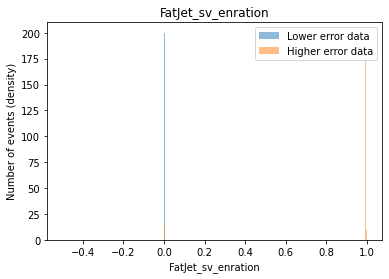

In [51]:
# bins = np.linspace(0, 0.6, 1000)
for idx, feat in enumerate(features):
    if "enration" not in feat:
        continue
    high_err_feat = high_err_test[:, idx]
    low_err_feat = low_err_test[:, idx]
#     print(f"maximum is {high_err_feat[np.argmax(high_err_feat)]}")
#     print(np.sum(high_err_feat))
    not_normal = []
    for element in high_err_feat:
        if element != 0 and element != 1:
            not_normal.append(element)
    
    plt.hist(not_normal, )
    
#     plt.hist(low_err_feat, density=True, bins=bins, alpha=0.5, label="Lower error data")
#     plt.hist(high_err_feat, density=True, bins=bins, alpha=0.5, label="Higher error data")
    plt.hist(low_err_feat, density=True, bins=200, alpha=0.5, label="Lower error data")
    plt.hist(high_err_feat, density=True, bins=200, alpha=0.5, label="Higher error data")
    plt.xlabel(feat)
    plt.ylabel("Number of events (density)")
    # Getting the name of the file we ran on
    plt.title(feat)
    plt.legend()
    plt.show()

### Selecting a new dataset and plotting the error

In [ ]:
# root_dir = "/eos/user/a/afriberg/datasets/vae_err/"
# files = os.listdir(root_dir)

# # Not a good way to do it, would use a dictionary but they're annoying to iterate over
# err_names = []
# errors = []

# print(files)
# for new_file in files:
#     print(f"now working on {new_file}")
#     # inputfile = 'QCD_HT500to700.root'
#     df = get_df(root_dir + new_file, '*')

#     df.dropna(inplace=True)
#     df = df[features]

#     unnormed_new_X = df.to_numpy()
#     unnormed_new_X = unnormed_new_X.astype("float32")

#     # Scale our data using a MinMaxScaler that will scale 
#     # each number so that it will be between 0 and 1
#     scaler = MinMaxScaler()
#     new_data = scaler.fit_transform(unnormed_new_X)
#     predict = model.predict(new_data)
#     err = np.mean(np.abs(predict - new_data), axis=1)
#     print(np.shape(err))
    
    
#     bins = np.linspace(0, 0.4, 1000)
#     # plt.hist(err, density=True)
#     plt.hist(err, density=True, bins=bins)
#     plt.xlabel("Mean Absolute Error")
#     plt.ylabel("Number of events (density)")
#     # Getting the name of the file we ran on
#     title = new_file.rpartition('/')[-1].rpartition('.')[0]
#     plt.title(title)
# #     plt.savefig("images/" + title)
#     plt.show()
    
    
#     err_names.append(title)
#     errors.append(err)

# Data with even more categories (Maybe)
### new_X should be defined previously - if it isn't you have a problem and need to go back

In [ ]:
col = 3
print(np.shape(new_X))
max_idx = np.argmax(new_X[col, :])
new_X[col, max_idx]

In [ ]:
# new_data = scaler.fit_transform(new_X)
new_predict = model.predict(new_X)
new_err = np.mean(np.abs(new_predict - new_X), axis=1)
print(np.shape(new_err))    
    
bins = np.linspace(0, 0.3, 1000)
# bins = np.linspace(0, 50, 200)
# bins = 200
# plt.hist(err, density=True)
plt.hist(new_err, density=True, bins=bins)
plt.xlabel("Mean Absolute Error")
plt.ylabel("Number of events (density)")
# Getting the name of the file we ran on
# title = new_file.rpartition('/')[-1].rpartition('.')[0]
title = "H to BB"
# plt.title(title)
# plt.savefig("images/" + title)
plt.show()
    
# err_names.append(title)
# errors.append(err)

In [ ]:
# There are three humps, so we're plotting those separately to visualize well
first_peaks = []
second_peaks = []
third_peaks = []

first_demarcation = 0.03
second_demarcation = 0.055
max_demarcation = 0.15

for idx, val in enumerate(new_err):
    if val < first_demarcation:
        first_peaks.append(idx)
    elif first_demarcation <= val < second_demarcation:
        second_peaks.append(idx)
    elif 0.13 <= val < max_demarcation:
        third_peaks.append(idx)
    

new_low_err = new_err[first_peaks]
new_mid_err = new_err[second_peaks]
new_high_err = new_err[third_peaks]

new_low_test = x_test[first_peaks]
new_mid_test = x_test[second_peaks]
new_high_test = x_test[third_peaks]

In [ ]:
# print(np.shape(new_high_err_test))
print(len(first_peaks))
print(len(second_peaks))
print(len(third_peaks))

In [ ]:
# plt.hist(err, density=True)
plt.hist(new_high_err, density=True, bins=bins)
plt.hist(new_mid_err, density=True, bins=bins)
plt.hist(new_low_err, density=True, bins=bins)
plt.xlabel("Mean Absolute Error")
plt.ylabel("Number of events (density)")
# Getting the name of the file we ran on
# title = new_file.rpartition('/')[-1].rpartition('.')[0]
plt.title(title)
# plt.savefig("images/" + title)
plt.show()

# Latent space representation of the new data

In [ ]:
trained_encoder = model.encoder
new_z_mean, new_z_log_var, new_z = trained_encoder.predict(new_X)

Plotting all of the B quark data at once

In [ ]:
alpha = 0.7
plt.scatter(z_high[:num_high, 0], z_high[:num_high, 1], s=1, alpha=alpha, label="high error data")
plt.scatter(z_low[:num_low, 0], z_low[:num_low, 1], s=1, alpha=alpha, label="low error data")
# plt.scatter(new)
plt.scatter(new_z[:, 0], new_z[:, 1], s=1, alpha=alpha, label=f"{title[:10]}")
plt.title("latent space representation")
plt.xlabel("z_0")
plt.ylabel("z_1")
plt.legend()
plt.show()

Plotting the lowest error B quark data

In [ ]:
new_low_z_mean, new_low_z_log_var, new_low_z = trained_encoder.predict(new_low_test)
alpha = 0.7
plt.scatter(z_high[:num_high, 0], z_high[:num_high, 1], s=1, alpha=alpha, label="high error data")
plt.scatter(z_low[:num_low, 0], z_low[:num_low, 1], s=1, alpha=alpha, label="low error data")
plt.scatter(new_low_z[:, 0], new_low_z[:, 1], s=1, alpha=alpha, label=f"{title[:10]} lowest error data")
plt.title("latent space representation")
plt.xlabel("z_0")
plt.ylabel("z_1")
plt.legend()
plt.show()

Plotting the medium error B quark data

In [ ]:
new_mid_z_mean, new_mid_z_log_var, new_mid_z = trained_encoder.predict(new_mid_test)
alpha = 0.7
plt.scatter(z_high[:num_high, 0], z_high[:num_high, 1], s=1, alpha=alpha, label="high error data")
plt.scatter(z_low[:num_low, 0], z_low[:num_low, 1], s=1, alpha=alpha, label="low error data")
plt.scatter(new_mid_z[:, 0], new_mid_z[:, 1], s=1, alpha=alpha, label=f"{title[:10]} medium error data")
plt.title("latent space representation")
plt.xlabel("z_0")
plt.ylabel("z_1")
plt.legend()
plt.show()

Plotting the highest error B quark data

In [ ]:
new_high_z_mean, new_high_z_log_var, new_high_z = trained_encoder.predict(new_high_test)
alpha = 0.7
plt.scatter(z_high[:num_high, 0], z_high[:num_high, 1], s=1, alpha=alpha, label="high error data")
plt.scatter(z_low[:num_low, 0], z_low[:num_low, 1], s=1, alpha=alpha, label="low error data")
plt.scatter(new_high_z[:, 0], new_high_z[:, 1], s=1, alpha=alpha, label=f"{title[:10]} highest error data")
plt.title("latent space representation")
plt.xlabel("z_0")
plt.ylabel("z_1")
plt.legend()
plt.show()

### Plotting the errors separately

In [ ]:
plt.scatter(new_z[:, 0], new_z[:, 1], s=1, alpha=alpha, label=title[:10])
plt.xlim(-3, 3)
plt.legend()
plt.show()
plt.scatter(new_high_z[:, 0], new_high_z[:, 1], s=1, alpha=alpha, label=f"{title[:10]} high error")
plt.xlim(-3, 3)
plt.legend()
plt.show()
plt.scatter(new_mid_z[:, 0], new_mid_z[:, 1], s=1, alpha=alpha, label=f"{title[:10]} medium error")
plt.xlim(-3, 3)
plt.legend()
plt.show()
plt.scatter(new_low_z[:, 0], new_low_z[:, 1], s=1, alpha=alpha, label=f"{title[:10]} low error")
plt.xlim(-3, 3)
plt.legend()
plt.show()

# Now for the OG data

plt.scatter(z_high[:num_high, 0], z_high[:num_high, 1], s=1, alpha=alpha, label="high error QCD data")
plt.legend()
plt.show()
plt.scatter(z_low[:num_low, 0], z_low[:num_low, 1], s=1, alpha=alpha, label="low error QCD data")
plt.legend()
plt.show()

## Plotting the features of the three peaks

In [ ]:
# For reference, these are the names of the data in each of the peaks
# new_low_test
# new_mid_test
# new_high_test

# bins = np.linspace(0, 0.6, 1000)
bins=200
alpha = 0.3
for idx, feat in enumerate(features):
#     if "FatJet_pt" not in feat and "phi" not in feat and "eta" not in feat:
#         continue
#     if "sv" not in feat:
#         continue
    high_err_feat = new_high_test[:, idx]
    mid_err_feat = new_mid_test[:, idx]
    low_err_feat = new_low_test[:, idx]
    
#     plt.hist(low_err_feat, density=True, bins=bins, alpha=0.5, label="Lower error data")
#     plt.hist(high_err_feat, density=True, bins=bins, alpha=0.5, label="Higher error data")
    plt.hist(high_err_feat, density=True, bins=bins, alpha=alpha, label="Higher error data")
    plt.hist(mid_err_feat, density=True, bins=bins, alpha=alpha, label="Medium error data")
    plt.hist(low_err_feat, density=True, bins=bins, alpha=alpha, label="Lower error data")
    plt.xlabel(feat)
    plt.ylabel("Number of events (density)")
    # Getting the name of the file we ran on
    plt.title(feat)
    plt.legend()
    plt.show()

## Plotting the distribution of B and QCD data together (scaled)

In [ ]:
# For reference, these are the names of the data in each of the peaks
# new_low_test
# new_mid_test
# new_high_test

bins = np.linspace(0, 1, 200)
# bins=200
alpha = 0.3
print("Got here")
for idx, feat in enumerate(features):
#     plt.hist(new_X[idx], density=True, bins=bins, alpha=alpha, label="QCD Data")
    plt.hist(new_mid_test[idx], density=True, bins=bins, alpha=alpha, label="QCD Data")
    plt.hist(x_test[idx], density=True, bins=bins, alpha=alpha, label="B Data")
    plt.xlabel(feat)
    plt.ylabel("Number of events (density)")
    # Getting the name of the file we ran on
    plt.title(feat)
    plt.legend()
    plt.show()

# (Don't have to run this all the time, and it might even crash) Checking the errors of the training data

In [ ]:
predict = model.predict(x_train)
err = np.mean(np.abs(predict - x_train), axis=1)
print(np.shape(err))

In [ ]:
bins = np.linspace(0, 0.4, 1000)
plt.hist(err, bins=bins)
plt.xlabel("Error (MAE)")
plt.ylabel("Number of Events")
plt.title("Training data")
plt.show()